In [1]:
# MURA dataset is located in my googe drive, can also mount from file system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [164]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import preprocessing
from skimage import io
import os
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
# import train and test csv's from google drive

train = pd.read_csv('drive/MyDrive/MURA-v1.1/train_labeled_studies.csv', header = None, names = ['image_path', 'target'])
test = pd.read_csv('drive/MyDrive/MURA-v1.1/valid_labeled_studies.csv', header = None, names = ['image_path', 'target'])

# Analysis with 2 targets

In [4]:
train.head()

image_path  target
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1
1  MURA-v1.1/train/XR_SHOULDER/patient00002/study...       1
2  MURA-v1.1/train/XR_SHOULDER/patient00003/study...       1
3  MURA-v1.1/train/XR_SHOULDER/patient00004/study...       1
4  MURA-v1.1/train/XR_SHOULDER/patient00005/study...       1

In [5]:
test.head()

image_path  target
0  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...       1
1  MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...       1
2  MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...       1
3  MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...       1
4  MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...       1

In [7]:
# get shape of train and test data
print(f'train:{train.shape}\ntest:{test.shape}')

train:(13457, 2)
test:(1199, 2)


In [8]:
# helper funtion to extract info from train and test dataframes
def clean_df(df):
  temp = df['image_path'].str.split('/', expand=True)
  new_df = pd.DataFrame(df['image_path'])
  new_df['patient_id'] = temp[3]
  new_df['study'] = temp[4].str.split('_', expand = True)[0].str[-1:].astype(int)
  new_df['study_type'] = temp[4].str.split('_', expand = True)[1]
  new_df['region'] = temp[2].str.split('_', expand = True)[1]
  new_df['target'] = df['target']
  map = {'positive':'abnormal', 'negative':'normal'}
  new_df['study_type'] = new_df['study_type'].map(map)
  map1 = {1:'abnormal', 0:'normal'}
  new_df['target'] = new_df['target'].map(map1)
  #add google drive location to image path
  new_df['image_path'] = 'drive/MyDrive/' + new_df['image_path']

  return new_df

In [9]:
# exctract data from train and test files
train = clean_df(train)
test = clean_df(test)

In [10]:
train.dtypes

image_path    object
patient_id    object
study          int64
study_type    object
region        object
target        object
dtype: object

In [11]:
train.head()

image_path    patient_id  study  \
0  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00001      1   
1  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00002      1   
2  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00003      1   
3  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00004      1   
4  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00005      1   

  study_type    region    target  
0   abnormal  SHOULDER  abnormal  
1   abnormal  SHOULDER  abnormal  
2   abnormal  SHOULDER  abnormal  
3   abnormal  SHOULDER  abnormal  
4   abnormal  SHOULDER  abnormal

In [12]:
test.head()

image_path    patient_id  study  \
0  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient...  patient11185      1   
1  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient...  patient11186      1   
2  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient...  patient11186      2   
3  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient...  patient11186      3   
4  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient...  patient11187      1   

  study_type region    target  
0   abnormal  WRIST  abnormal  
1   abnormal  WRIST  abnormal  
2   abnormal  WRIST  abnormal  
3   abnormal  WRIST  abnormal  
4   abnormal  WRIST  abnormal

In [13]:
# combine train and test
all_data = train.append(test)

<ipython-input-13-610d7644ceaa>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = train.append(test)


In [14]:
# check unique values
print(all_data[all_data['study_type']=='abnormal']['target'].unique())
print(all_data[all_data['study_type']=='normal']['target'].unique())

['abnormal']
['normal']


In [19]:
# get shape of all data sets
print(f'train:{train.shape}\ntest:{test.shape}\nall_data:{all_data.shape}')

train:(13457, 6)
test:(1199, 6)
all_data:(14656, 6)


In [17]:
# function that gets unique values of relevant rows
def get_unique(df):
  print(df['study'].unique())
  print(df['study_type'].unique())
  print(df['region'].unique())
  print(df['target'].unique())

In [18]:
# check unique values
get_unique(test)
get_unique(train)

[1 2 3 4]
['abnormal' 'normal']
['WRIST' 'FOREARM' 'HAND' 'HUMERUS' 'SHOULDER' 'ELBOW' 'FINGER']
['abnormal' 'normal']
[1 2 3 4]
['abnormal' 'normal']
['SHOULDER' 'HUMERUS' 'FINGER' 'ELBOW' 'WRIST' 'FOREARM' 'HAND']
['abnormal' 'normal']


In [20]:
# function to get patient count by study with visulization
def study_count(df):
  stud_df = df.groupby('study').count()['image_path'].reset_index()
  stud_df.columns = ['Study','Count']
  display(stud_df)

  fig, ax = plt.subplots(figsize = (8,8))

  ax.bar(stud_df['Study'], stud_df['Count'], color = '#C8DDE7')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Studies', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Image Count', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Amount', fontsize = 14, weight = 'bold')
  tot = stud_df['Count'].sum()
  plt.ylim(0,math.ceil(tot)*1.1)
  plt.show()

Study  Count
0      1  12934
1      2    480
2      3     35
3      4      8

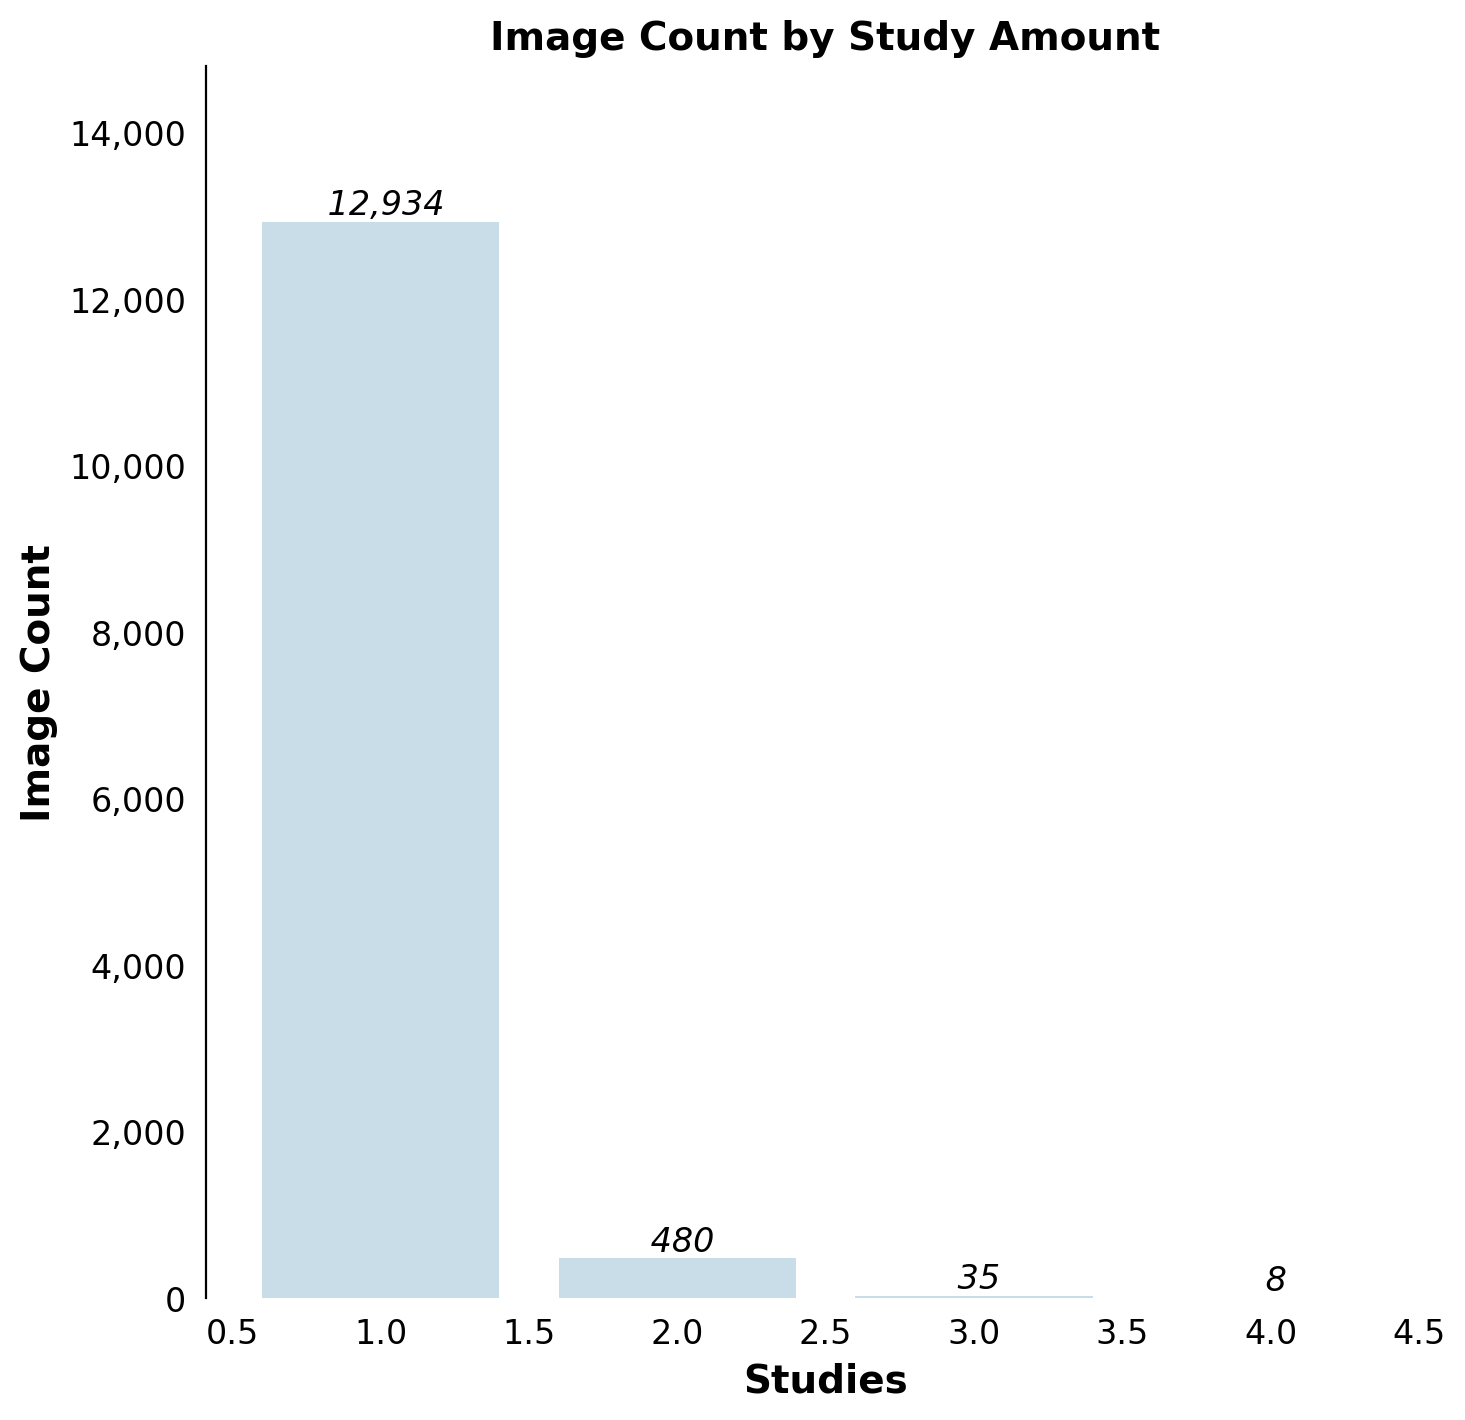

In [21]:
# train data patient count by study with visulization
study_count(train)

Study  Count
0      1   1118
1      2     70
2      3     10
3      4      1

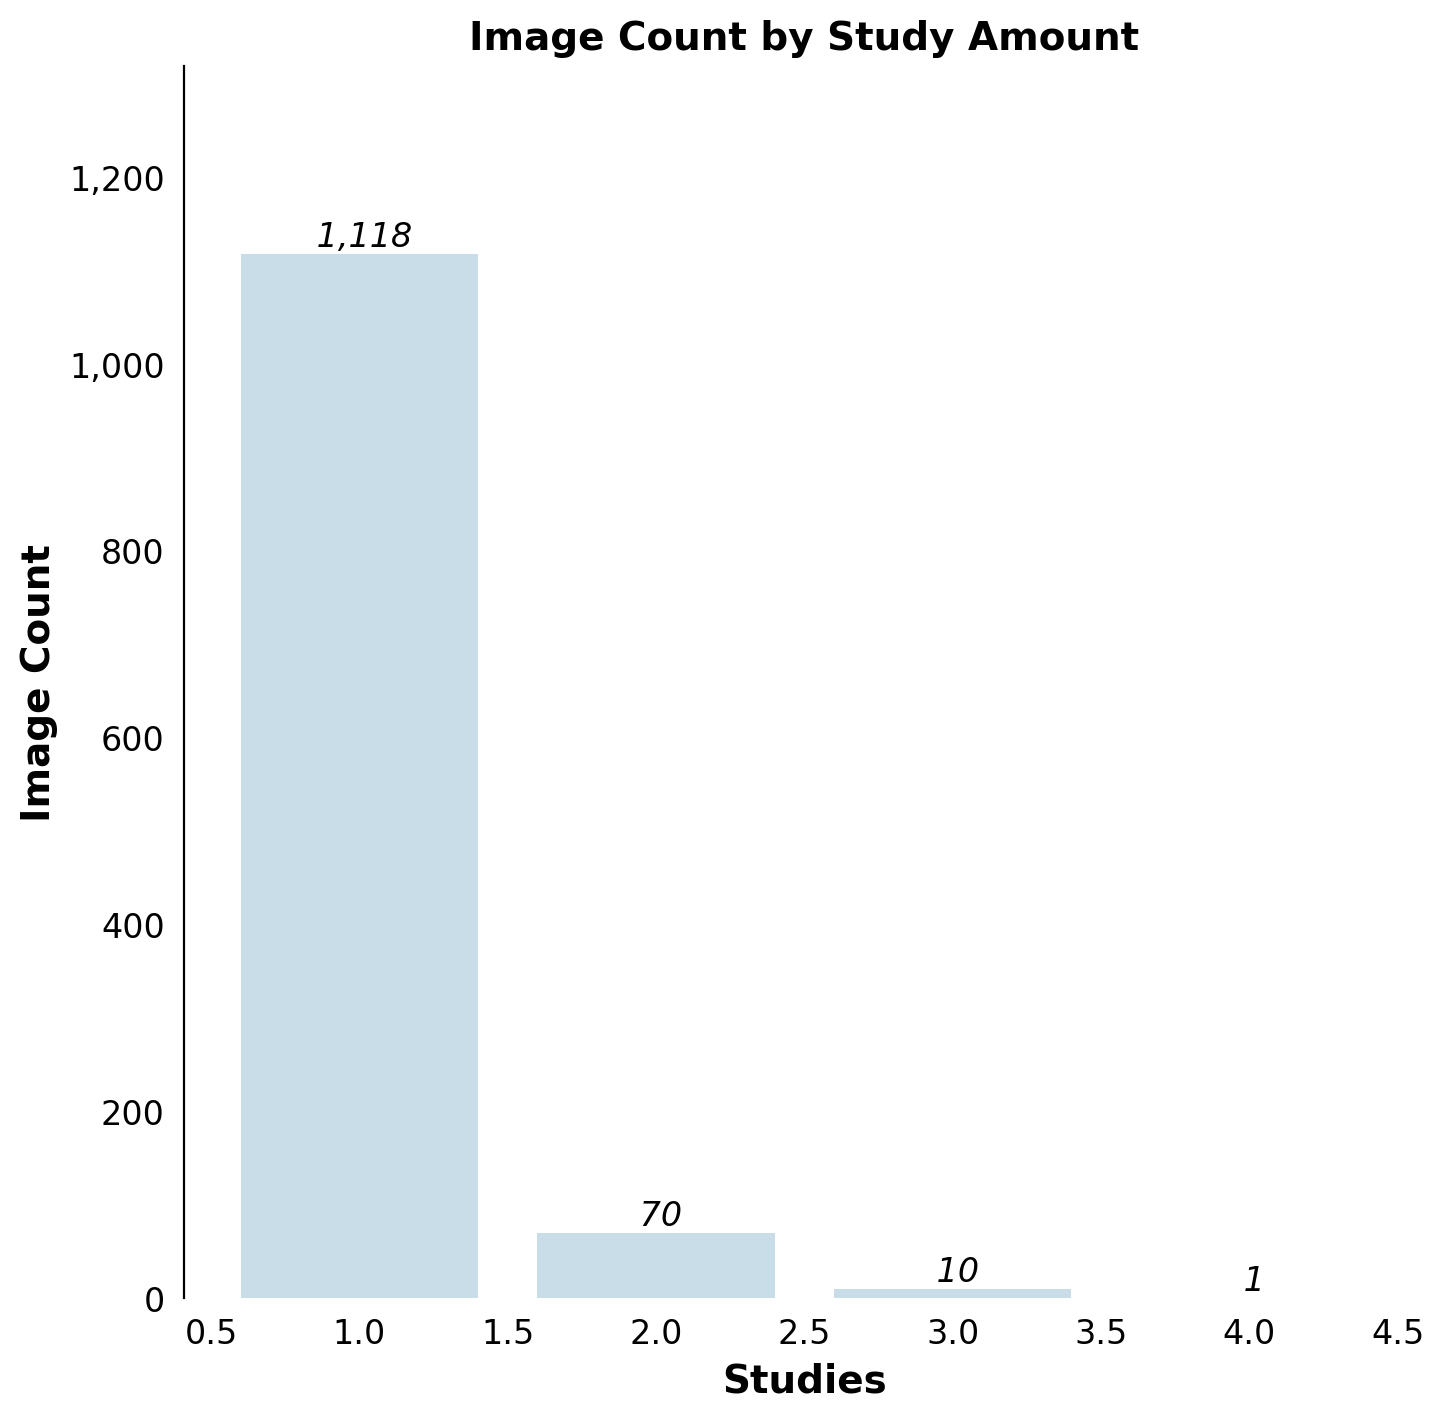

In [23]:
# test data patient count by study with visulization
study_count(test)

Study  Count
0      1  14052
1      2    550
2      3     45
3      4      9

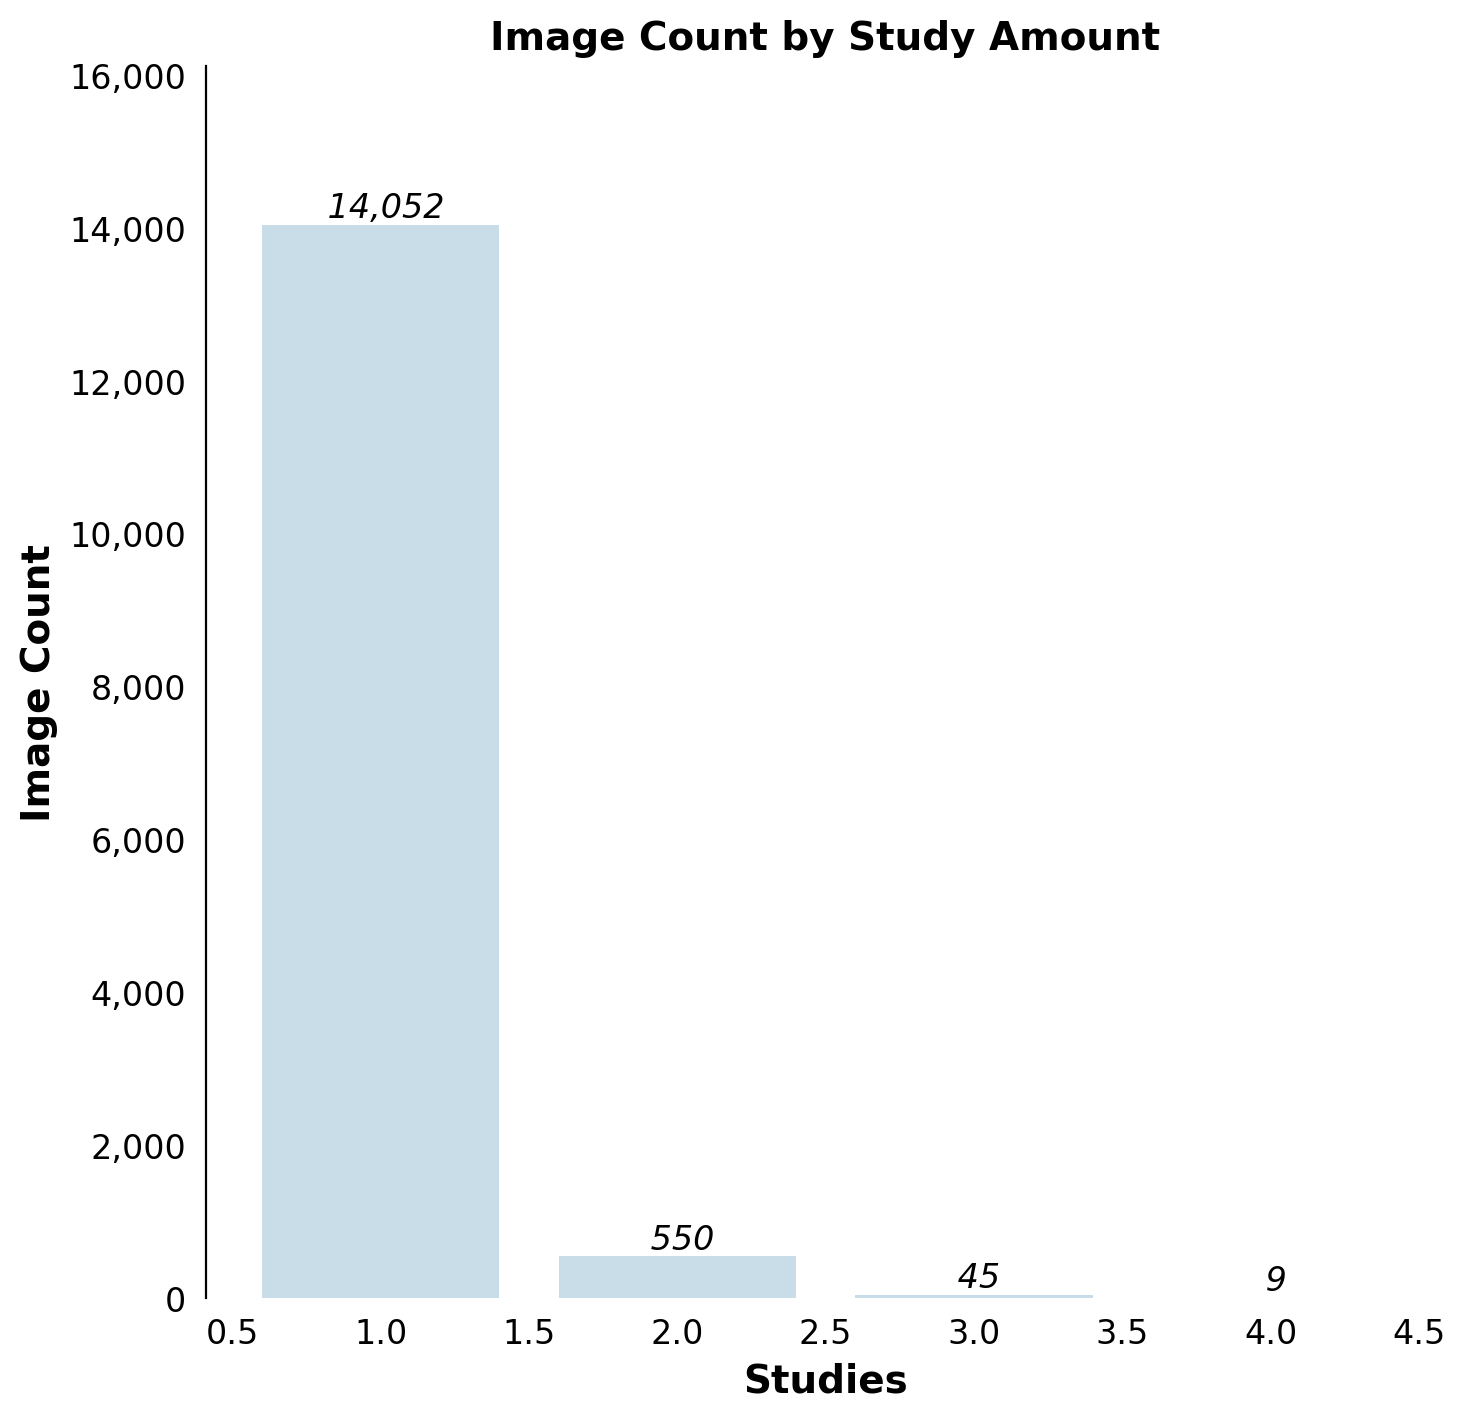

In [25]:
# combined data patient count by study with visulization
study_count(all_data)

In [27]:
# functon to get patient count by study type with visulization
def study_type_count(df):
  styp_df = df.groupby('study_type').count()['image_path'].reset_index()
  styp_df.columns = ['Study Type','Count']
  display(styp_df)

  fig, ax = plt.subplots(figsize = (8,8))

  ax.bar(styp_df['Study Type'], styp_df['Count'], color = '#0097a7')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Study Type', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Image Count', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  tot = styp_df['Count'].sum()
  plt.ylim(0,math.ceil(tot)*.8)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Type', fontsize = 14, weight = 'bold')
  plt.show()

Study Type  Count
0   abnormal   5177
1     normal   8280

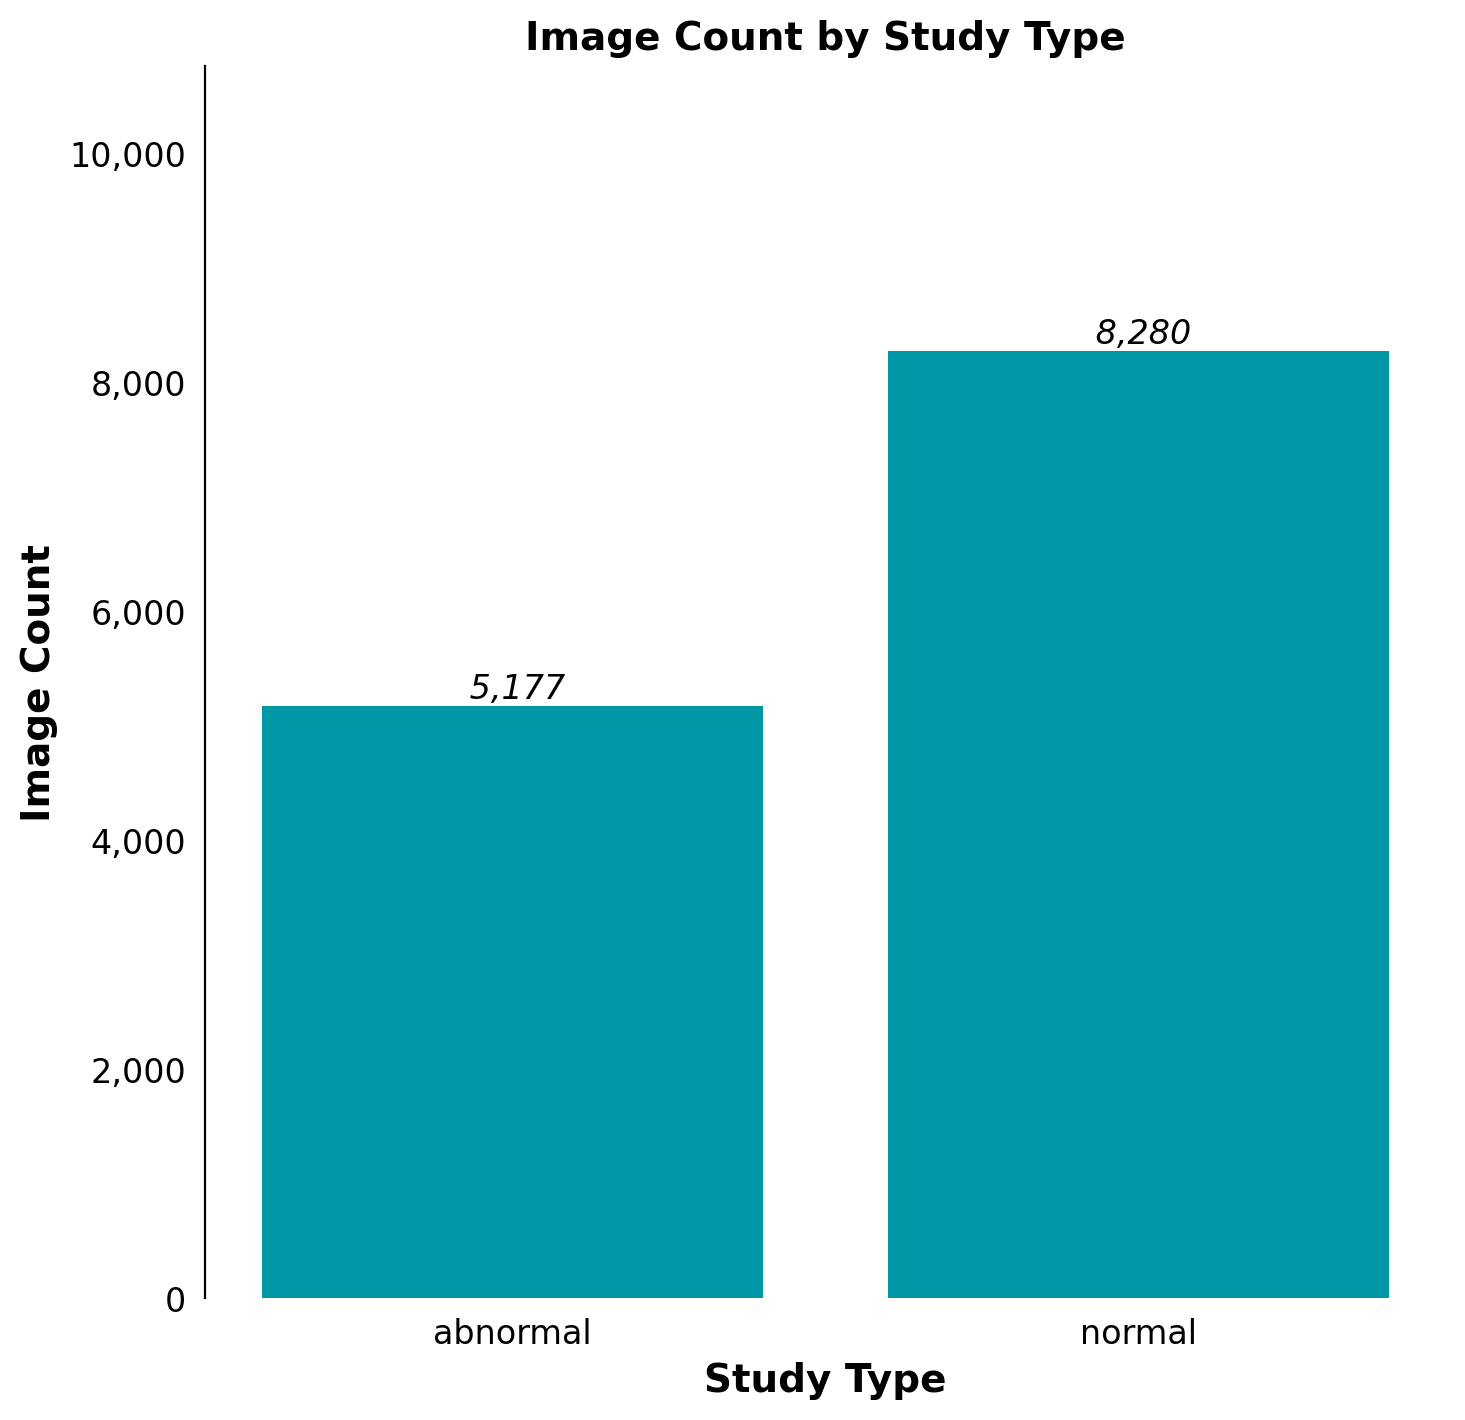

In [28]:
# train data patient count by study type with visulization
study_type_count(train)

Study Type  Count
0   abnormal    538
1     normal    661

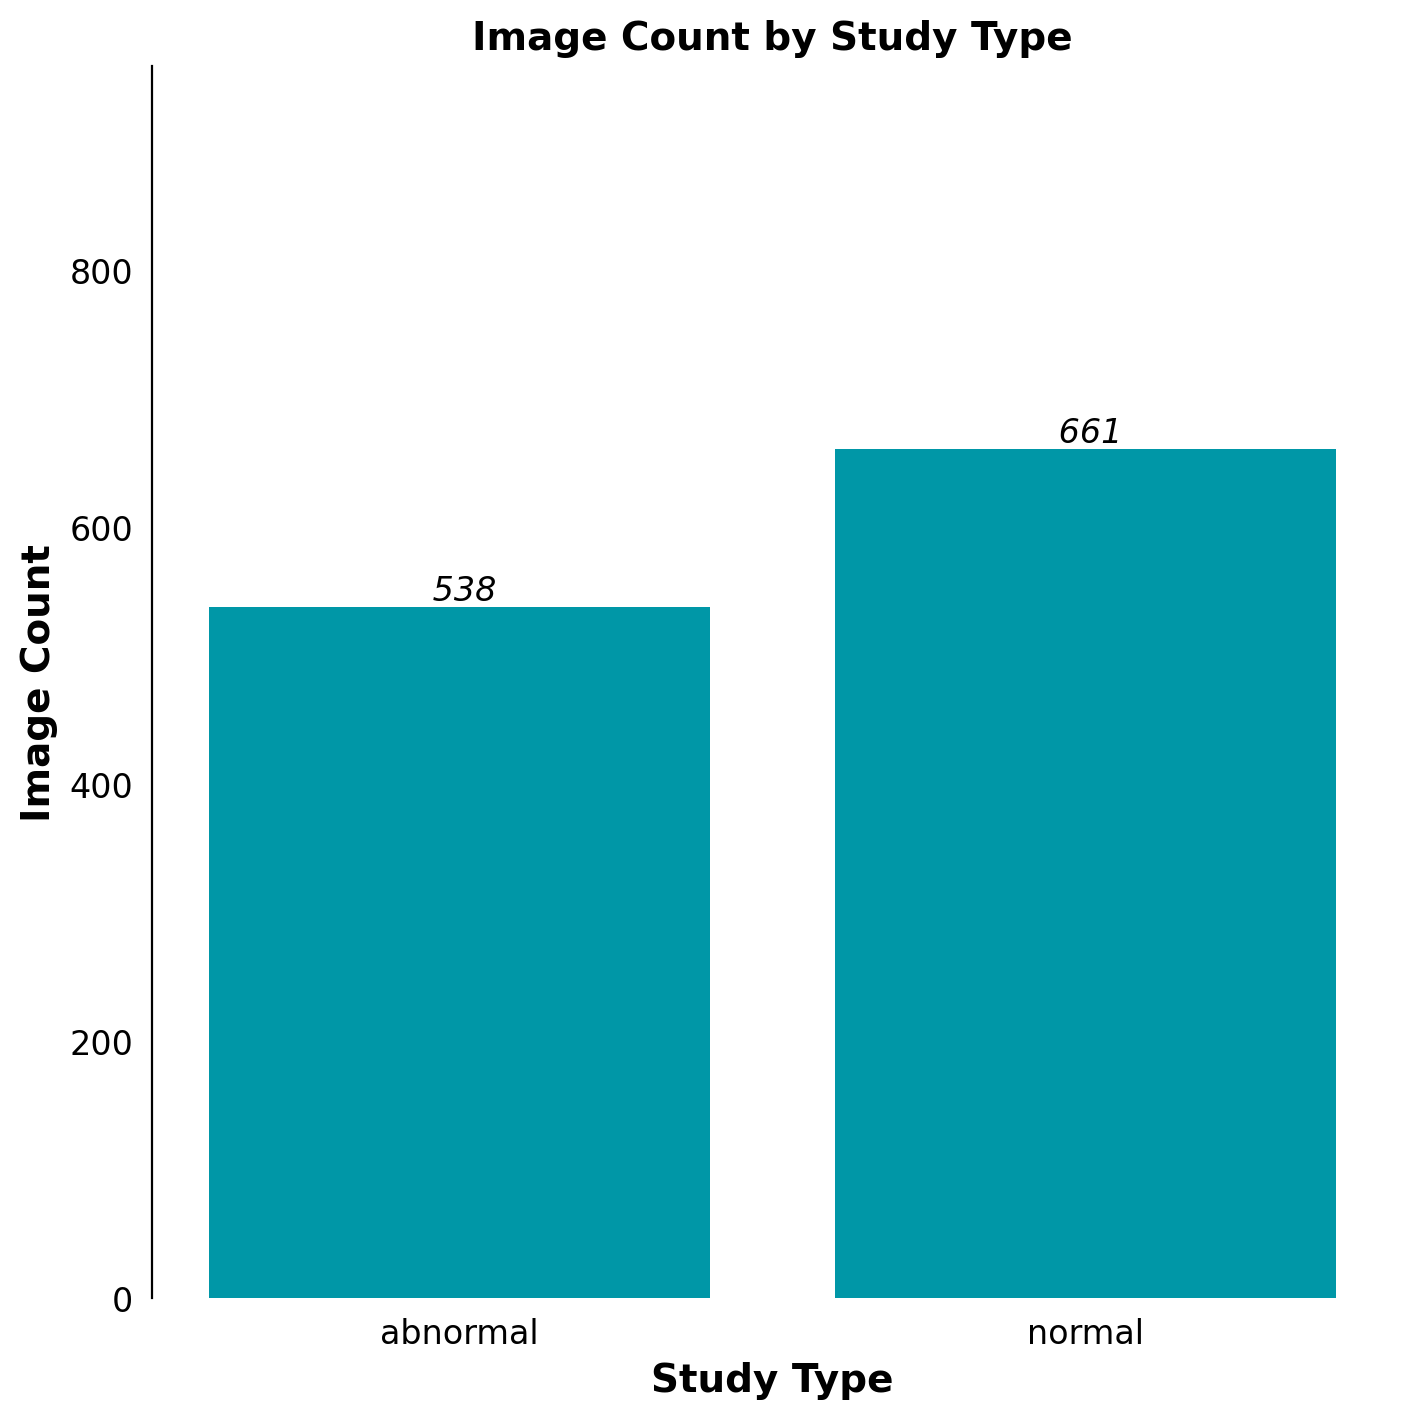

In [29]:
# test data patient count by study type with visulization
study_type_count(test)

Study Type  Count
0   abnormal   5715
1     normal   8941

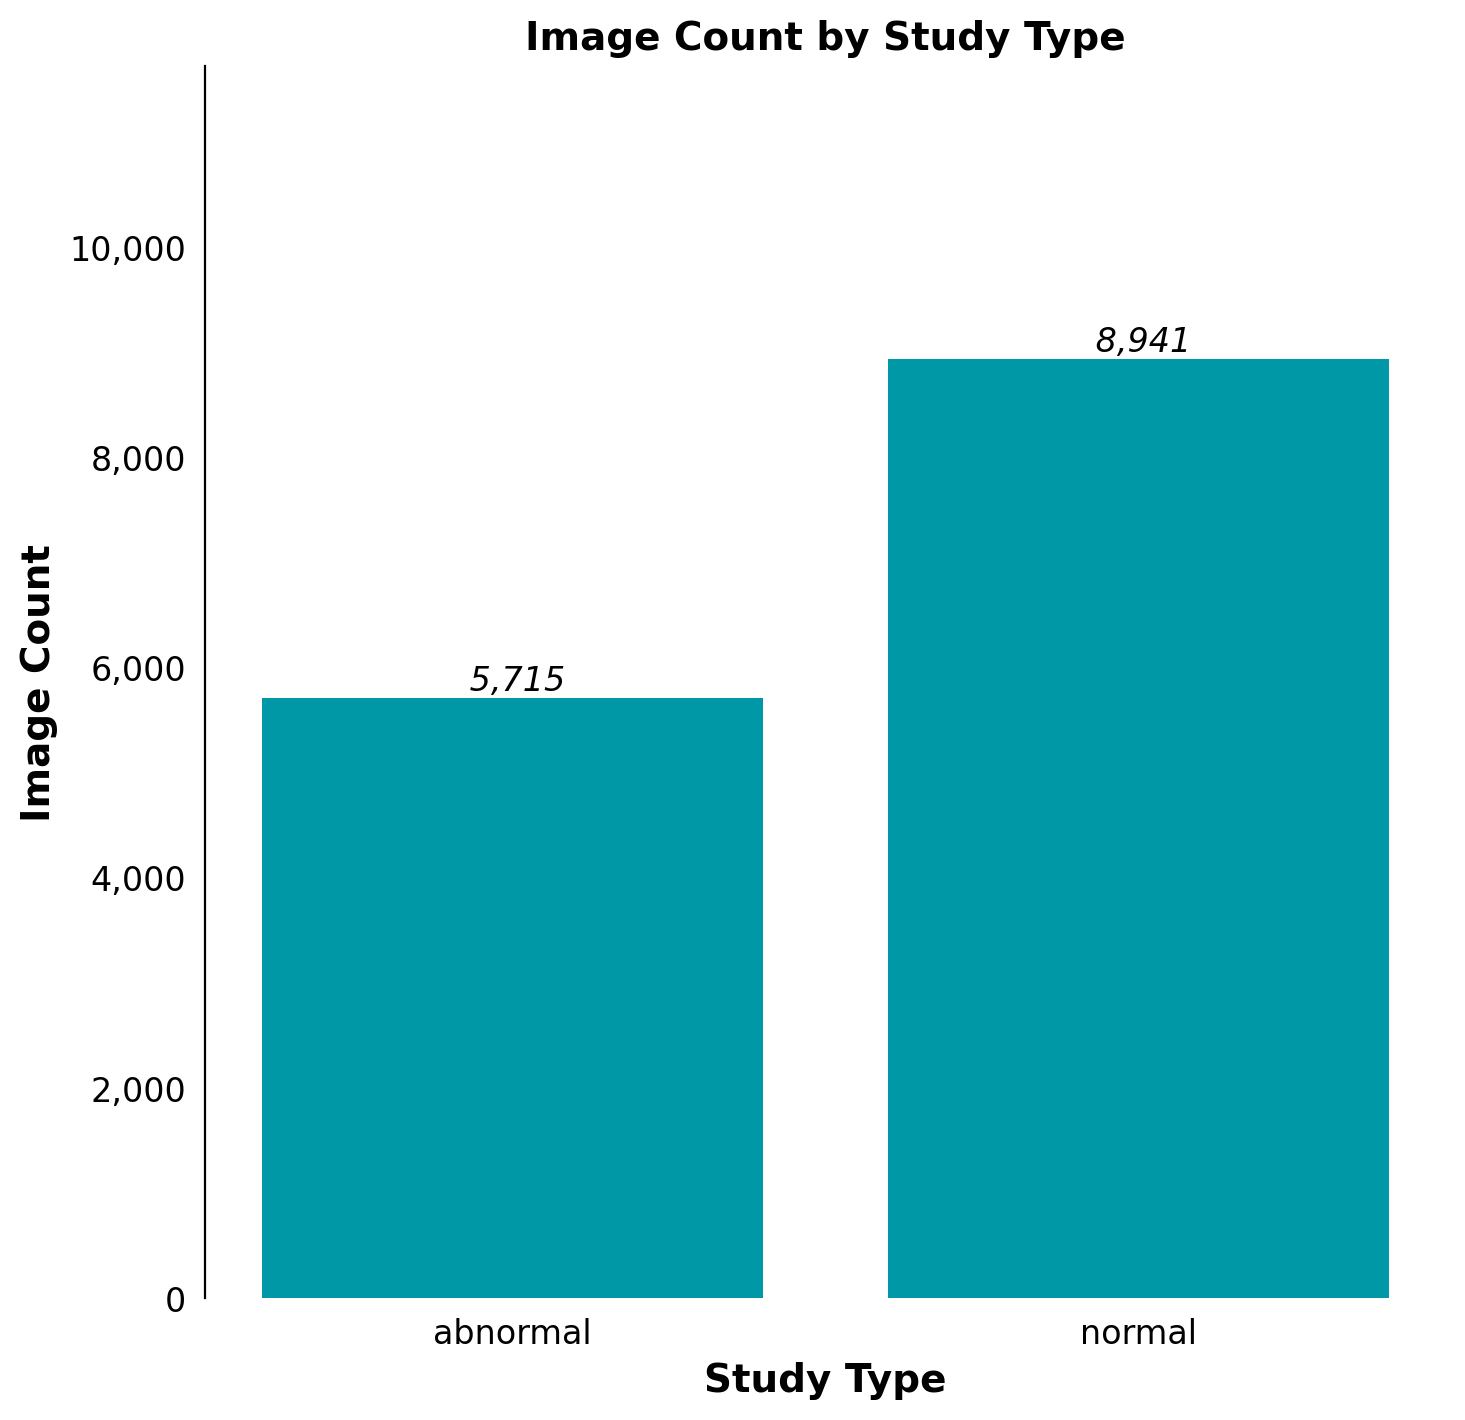

In [30]:
# combined data patient count by study type with visulization
study_type_count(all_data)

In [31]:
# function to get region count with visualisation
def region_count(df):
  # patient count by body part
  bdpt_df = df.groupby('region').count()['image_path'].reset_index()
  bdpt_df.columns = ['Region','Count']
  display(bdpt_df)

  # patient count by body part bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  ax.barh(bdpt_df['Region'], bdpt_df['Count'], color = '#A8D3E3')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  plt.tick_params(left = False, bottom = False)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.title('Image Count by Region', fontsize = 14, weight = 'bold')
  plt.show()

Region  Count
0     ELBOW   1754
1    FINGER   1935
2   FOREARM    877
3      HAND   2018
4   HUMERUS    592
5  SHOULDER   2821
6     WRIST   3460

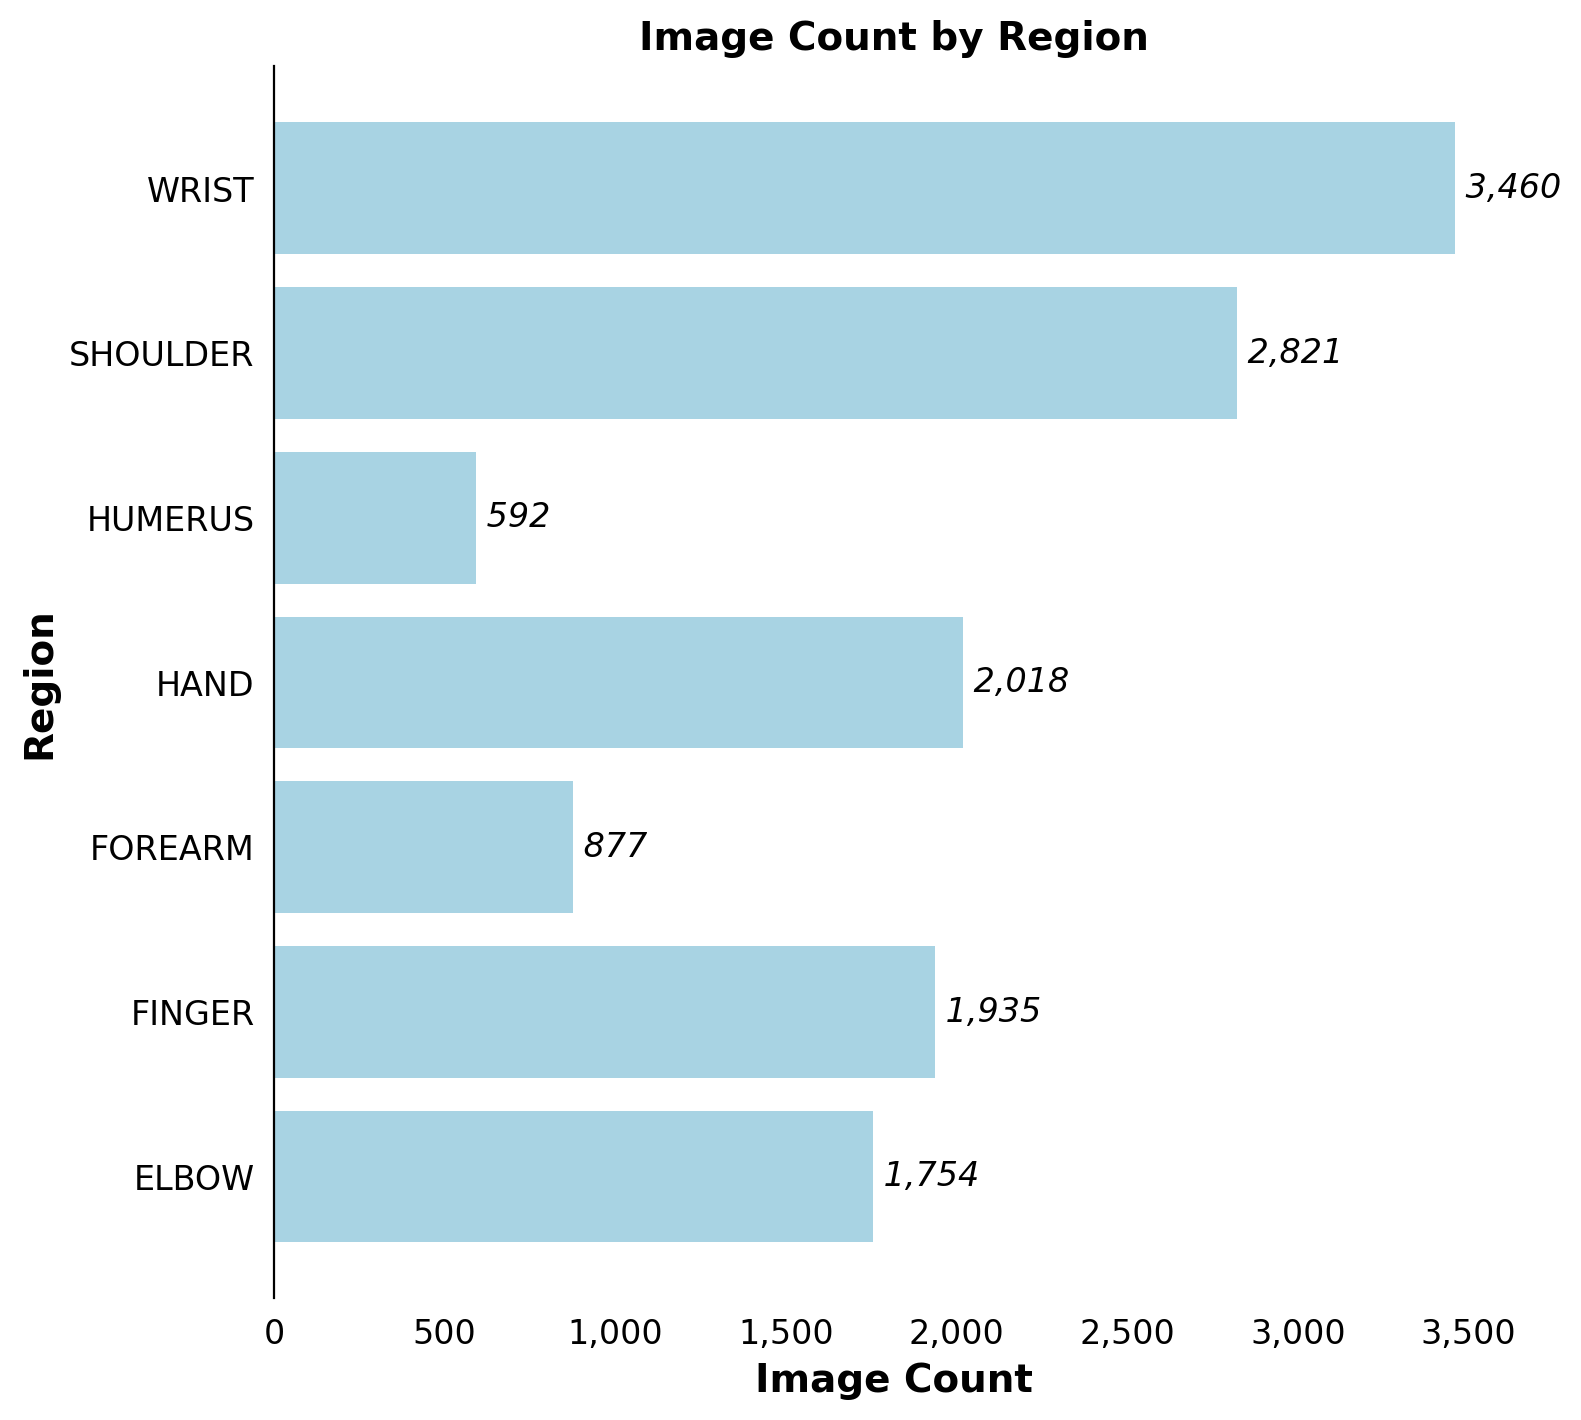

In [32]:
# train data region count with visualisation
region_count(train)

Region  Count
0     ELBOW    158
1    FINGER    175
2   FOREARM    133
3      HAND    167
4   HUMERUS    135
5  SHOULDER    194
6     WRIST    237

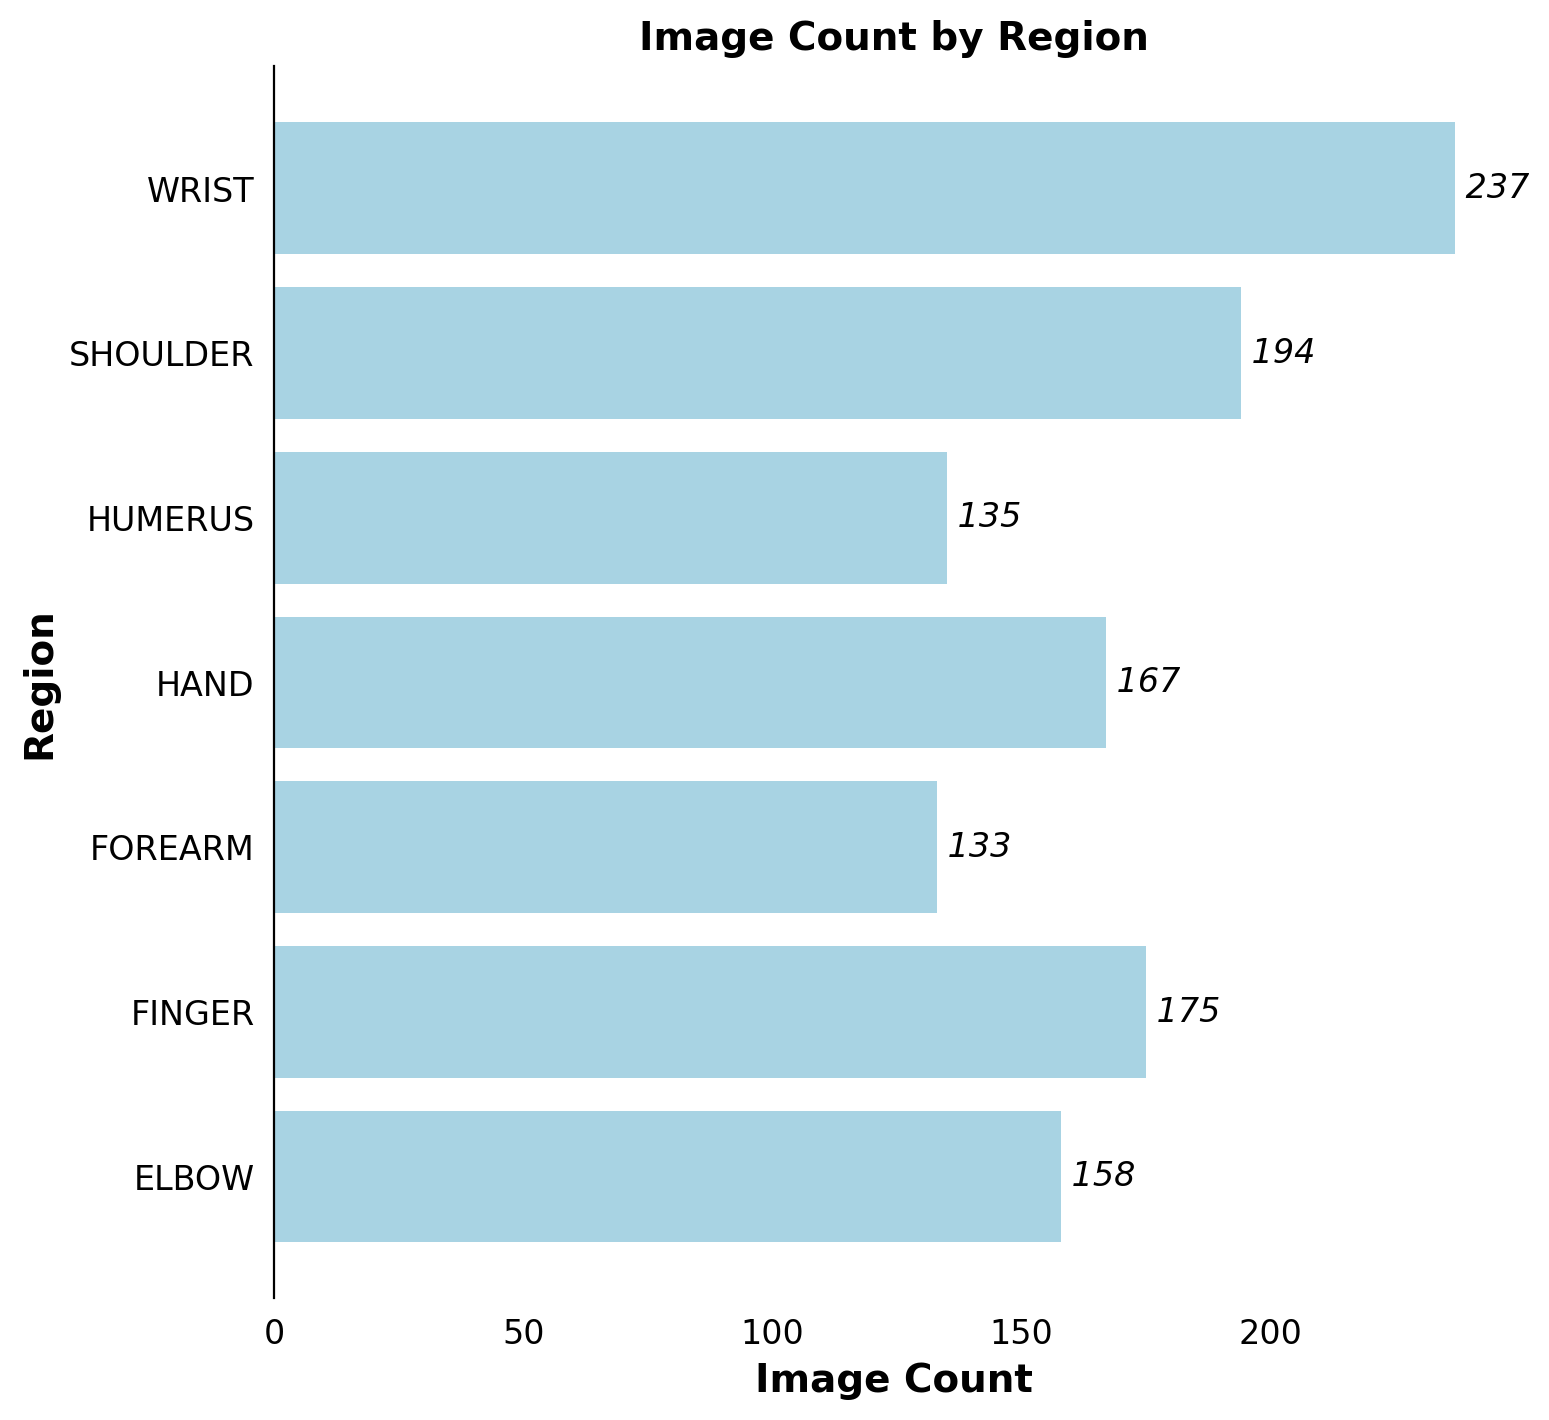

In [33]:
# test data region count with visualisation
region_count(test)

Region  Count
0     ELBOW   1912
1    FINGER   2110
2   FOREARM   1010
3      HAND   2185
4   HUMERUS    727
5  SHOULDER   3015
6     WRIST   3697

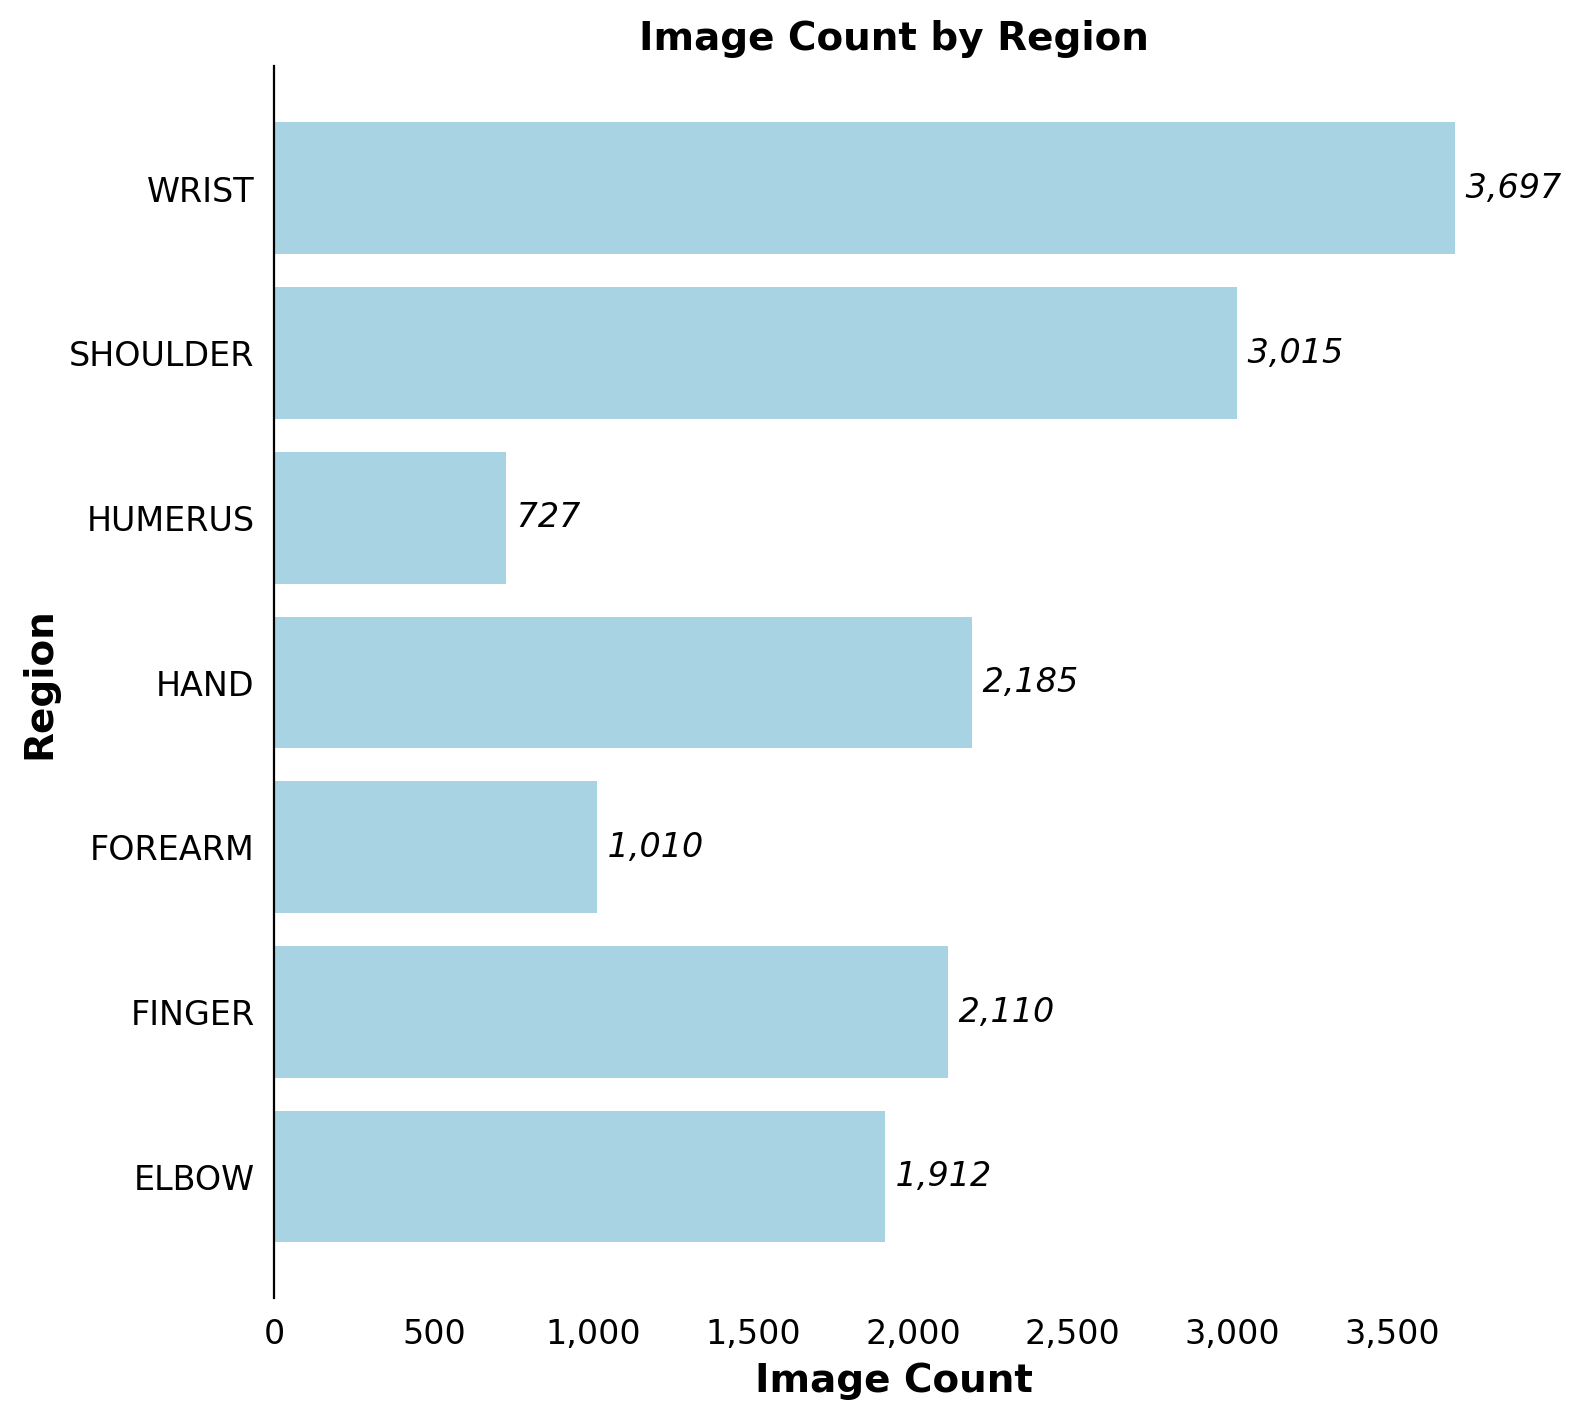

In [34]:
# combined data region count with visualisation
region_count(all_data)

In [167]:
# function to get patient count by study type and region with visulization
def type_region(df):  
  stack = df.groupby(['region', 'study_type']).count()['image_path'].reset_index()
  stack.columns = ['Region','Study Type','Count']
  stack_neg = stack[stack['Study Type'] == 'normal']
  stack_pos = stack[stack['Study Type'] == 'abnormal']
  stack_all = stack_pos.merge(stack_neg, on = 'Region', how = 'left')
  stack_all['Count_z'] = stack_all['Count_x'] + stack_all['Count_y']
  display(stack_all)

  # patient count by study type and region stacked bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  x = stack_all['Region']
  y1 = stack_all['Count_x']
  y2 = stack_all['Count_y']
  y3 = stack_all['Count_z']
  
  ax.barh(x, y1, color = '#A8D3E3', label = 'Abnormal')
  ax.barh(x, y2, left = y1, color = '#0097a7', label = 'Normal')
  container = ax.containers[0]
  container2 = ax.containers[1]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.bar_label(container2, labels = [' ' + f'{x:,.0f}' for x in container2.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  #ax.set_yticks(x, rotation = 90)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Type and Region', fontsize = 14, weight = 'bold')
  ax.legend()

  plt.show()

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal      660       normal     1094     1754
1    FINGER     abnormal      655       normal     1280     1935
2   FOREARM     abnormal      287       normal      590      877
3      HAND     abnormal      521       normal     1497     2018
4   HUMERUS     abnormal      271       normal      321      592
5  SHOULDER     abnormal     1457       normal     1364     2821
6     WRIST     abnormal     1326       normal     2134     3460

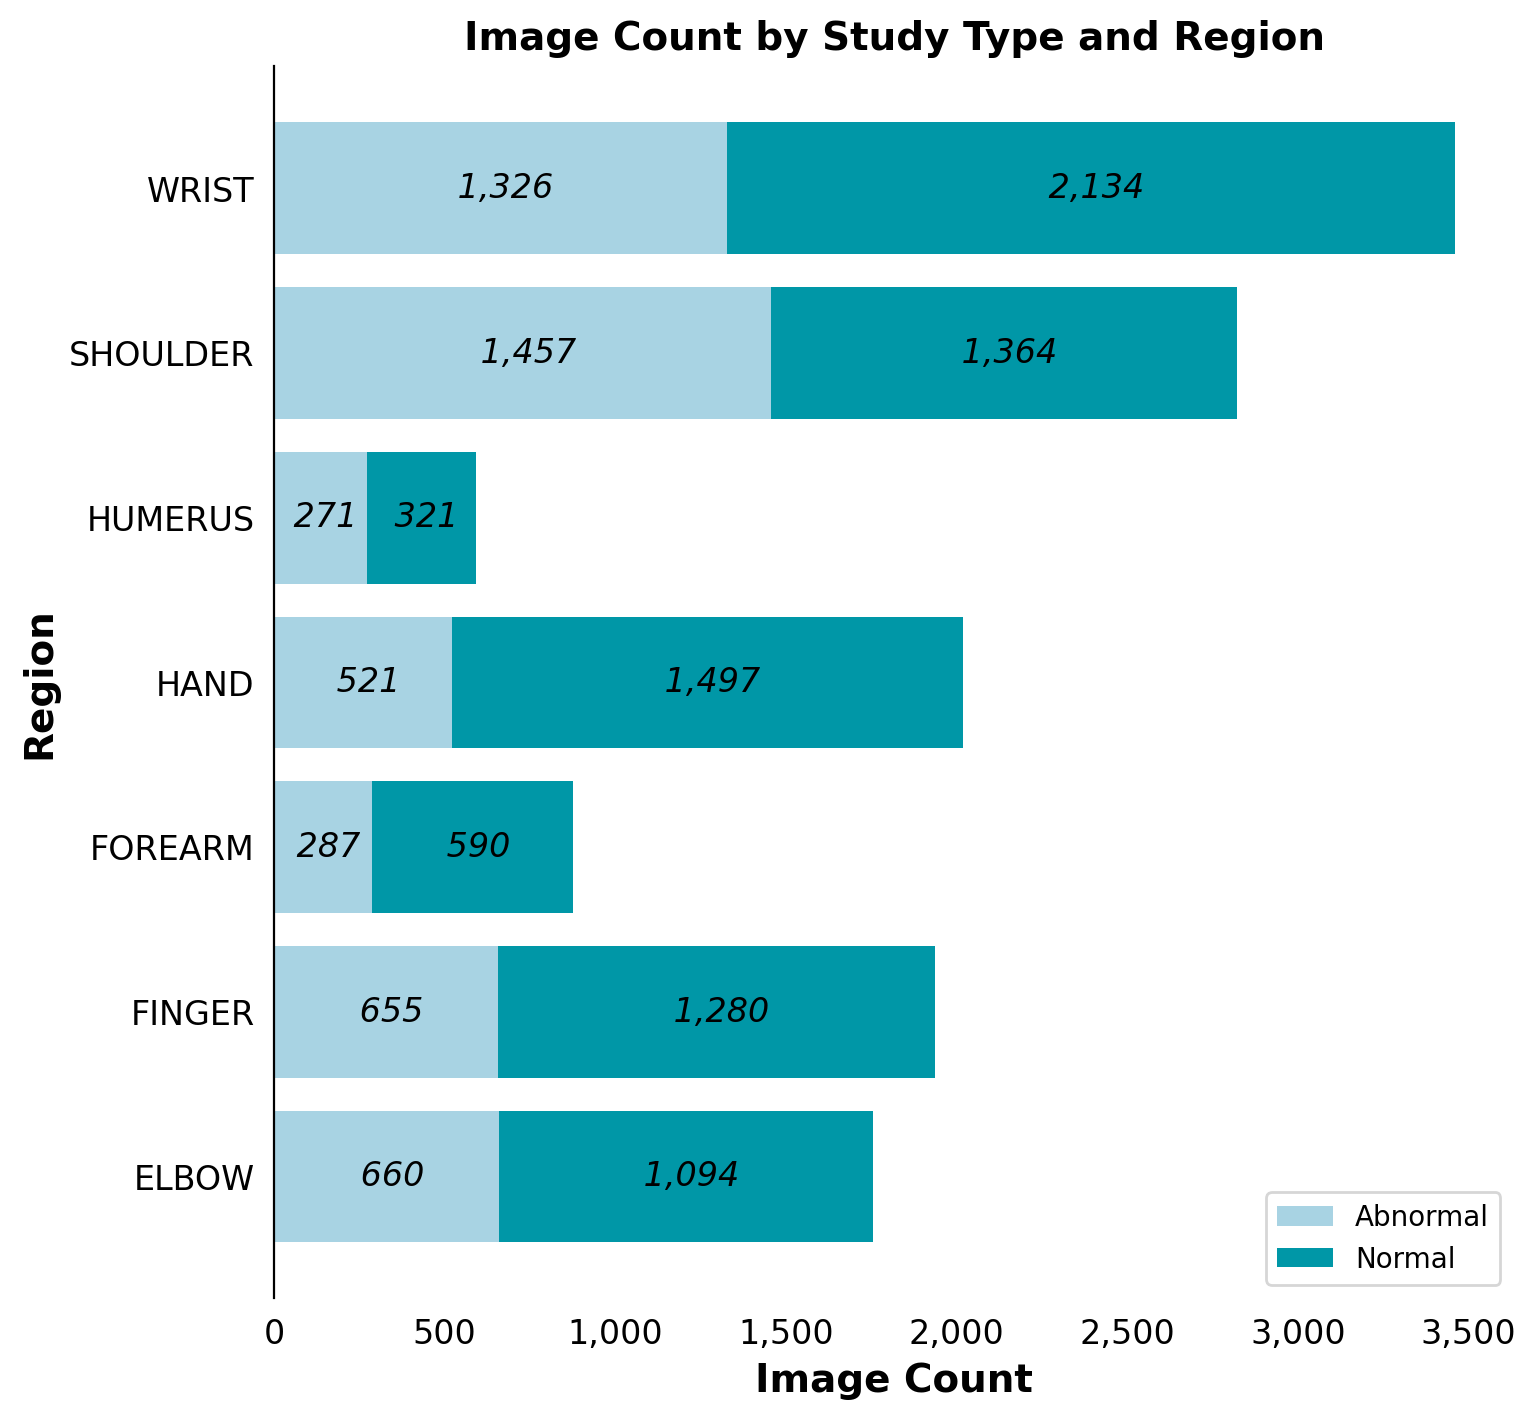

In [168]:
# train data patient count by study type and region with visulization
type_region(train)

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal       66       normal       92      158
1    FINGER     abnormal       83       normal       92      175
2   FOREARM     abnormal       64       normal       69      133
3      HAND     abnormal       66       normal      101      167
4   HUMERUS     abnormal       67       normal       68      135
5  SHOULDER     abnormal       95       normal       99      194
6     WRIST     abnormal       97       normal      140      237

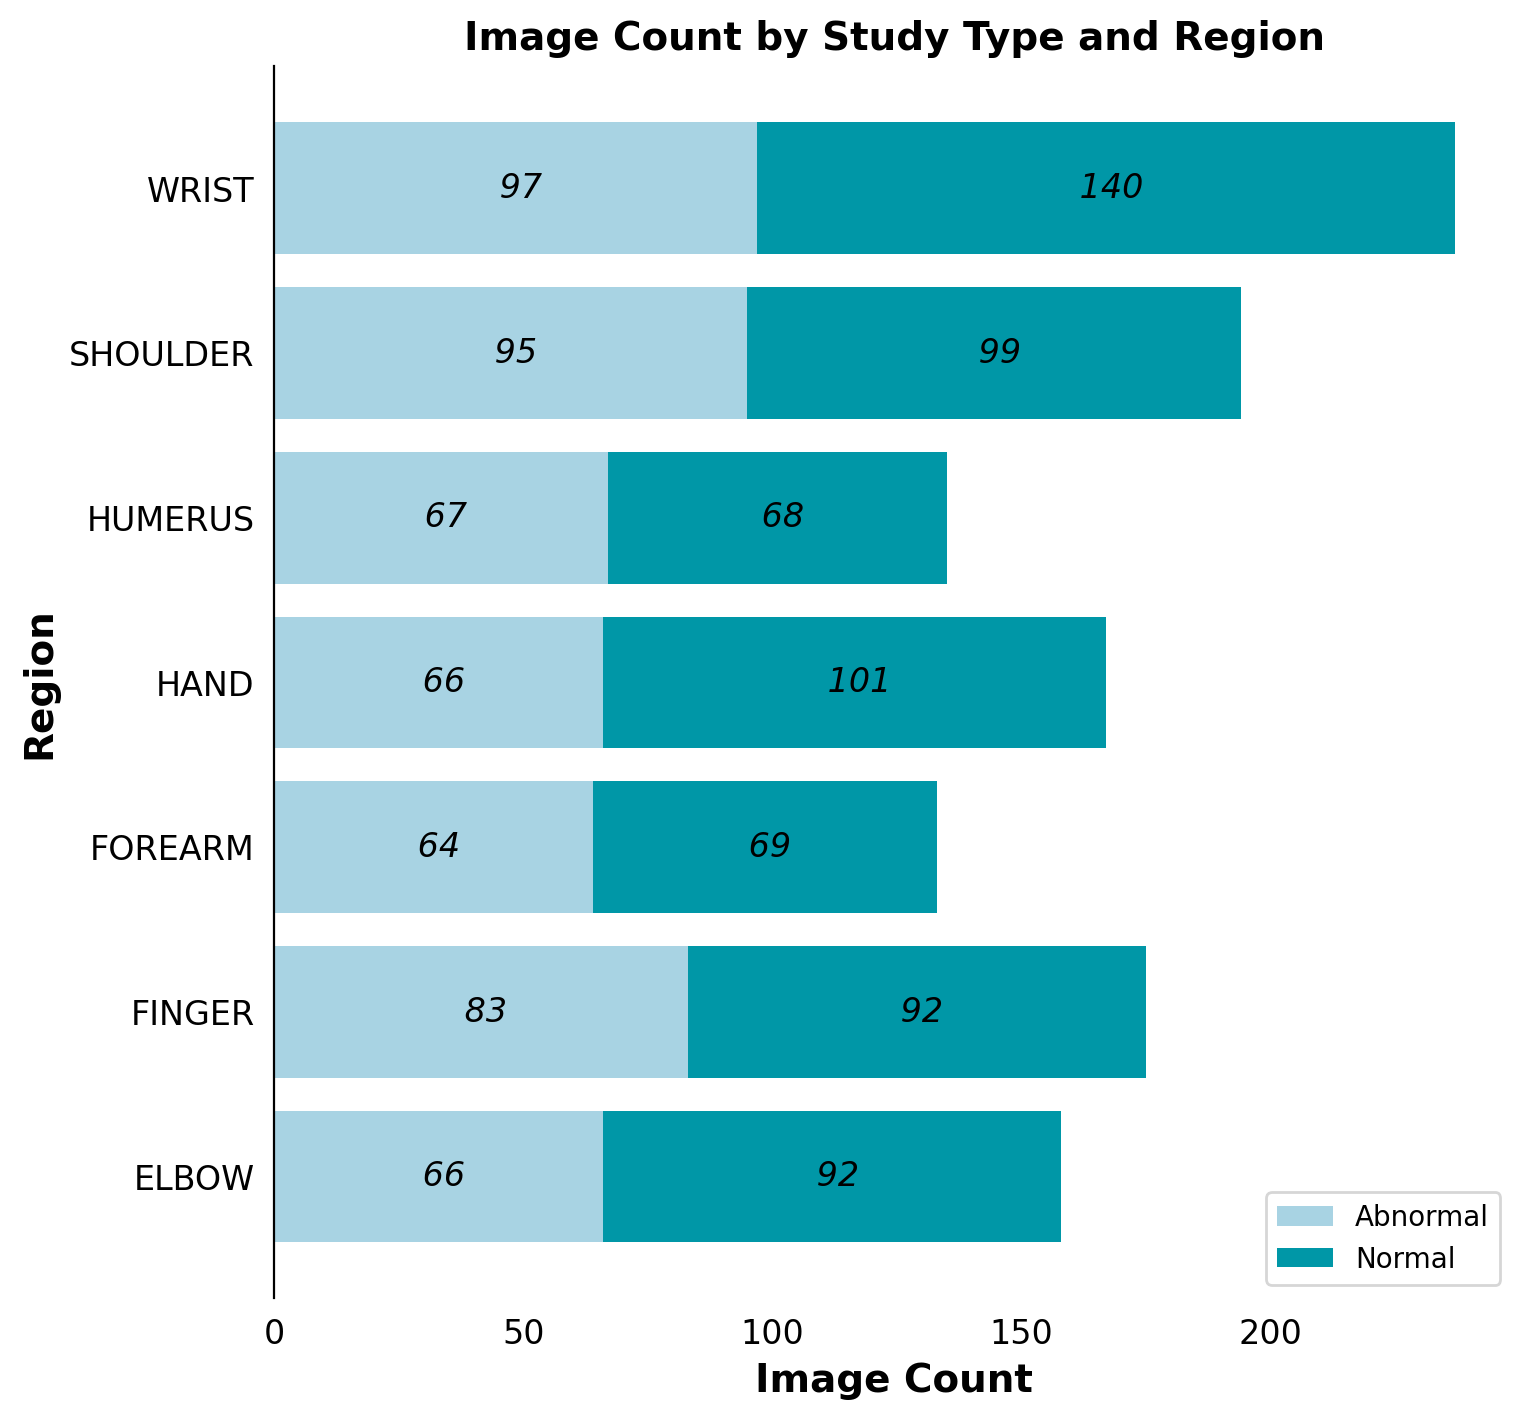

In [169]:
# test data patient count by study type and region with visulization
type_region(test)

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal      726       normal     1186     1912
1    FINGER     abnormal      738       normal     1372     2110
2   FOREARM     abnormal      351       normal      659     1010
3      HAND     abnormal      587       normal     1598     2185
4   HUMERUS     abnormal      338       normal      389      727
5  SHOULDER     abnormal     1552       normal     1463     3015
6     WRIST     abnormal     1423       normal     2274     3697

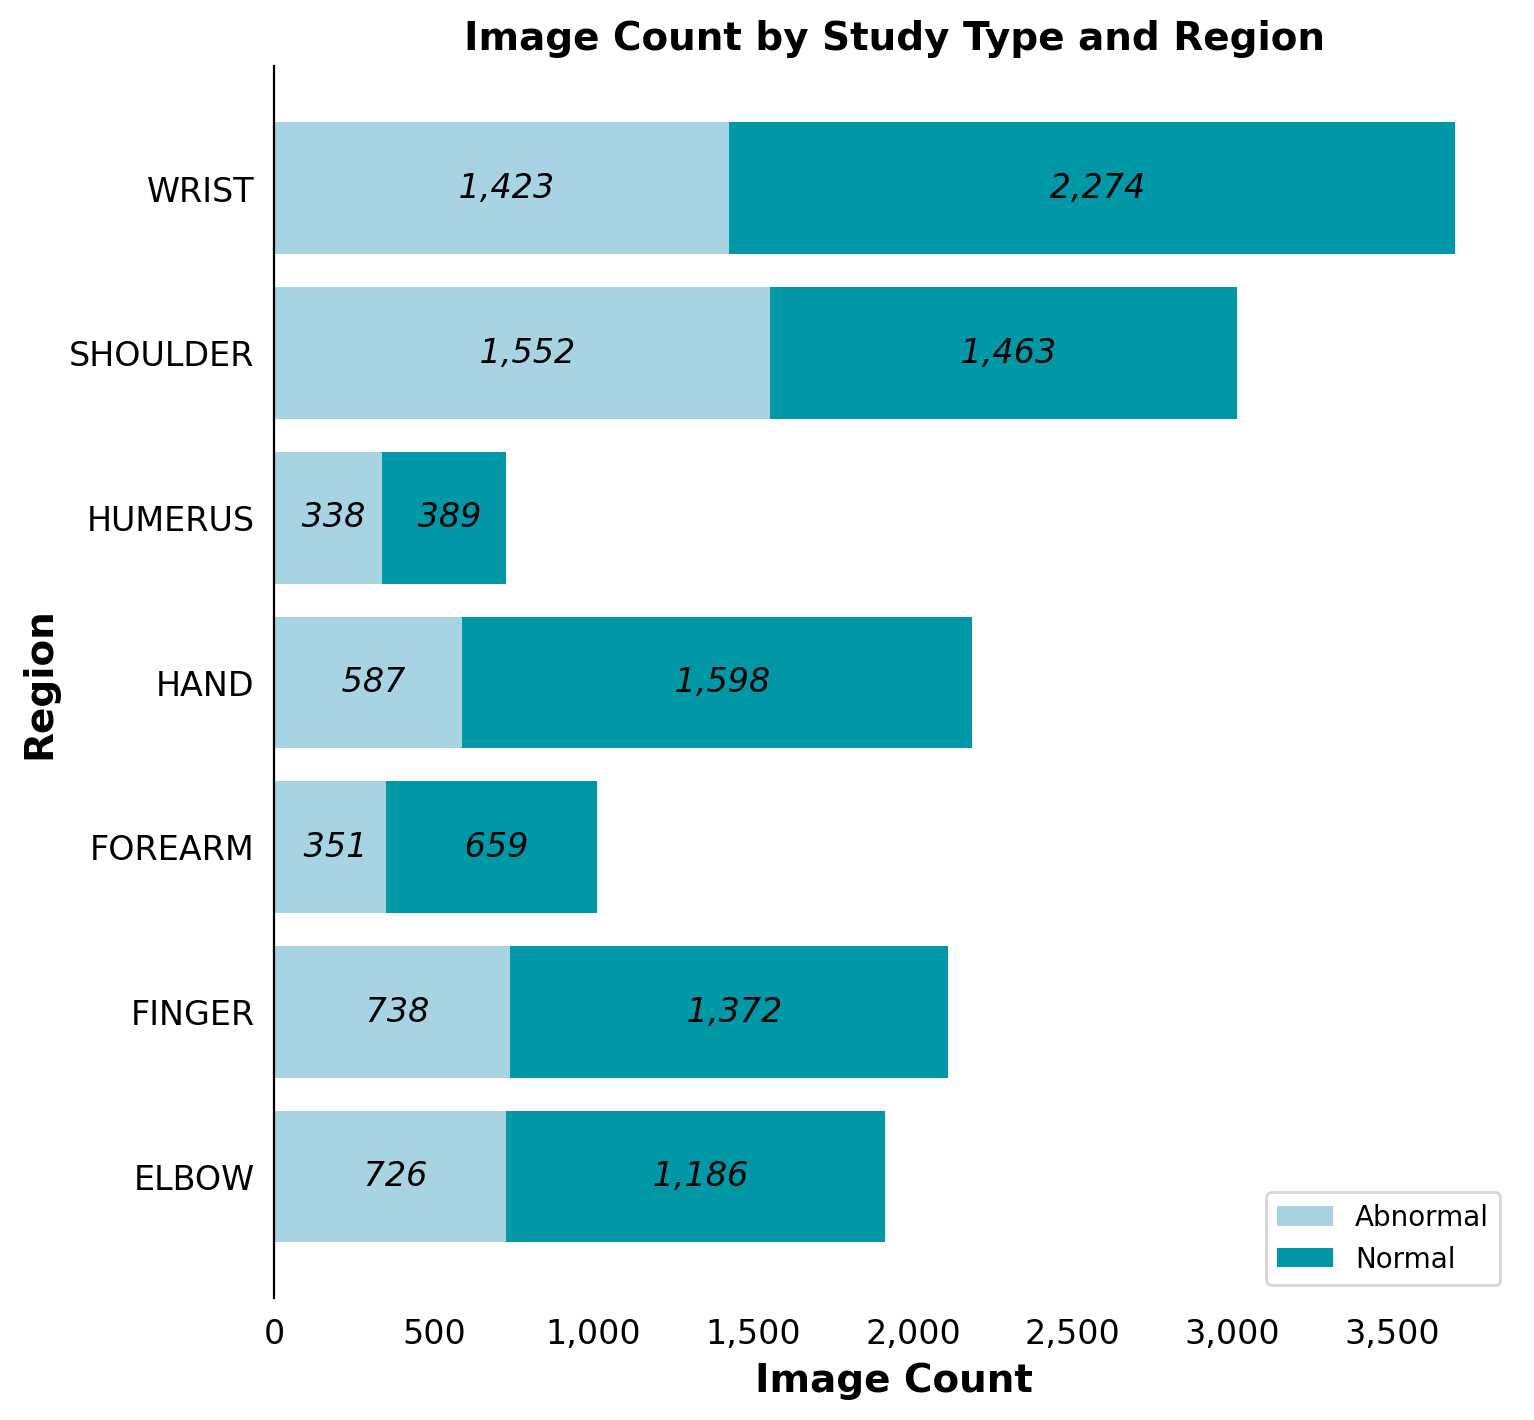

In [170]:
# combined data patient count by study type and region with visulization
type_region(all_data)

# Analysis with 14 targets

In [41]:
# function that combines target and region to create new target variable
def make_new_target(df):
  df['type'] = df['study_type'] + "_" + df['region']
  df['new_target'] = df['region']+"_"+ df['target']

  target_map = {'WRIST_abnormal':'0', 'WRIST_normal':'1','FOREARM_abnormal' : '2', 'FOREARM_normal' : '3',
                      'HAND_abnormal': '4', 'HAND_normal' : '5', 'HUMERUS_abnormal': '6', 'HUMERUS_normal' : '7',
                      'ELBOW_abnormal': '8', 'ELBOW_normal' : '9', 'SHOULDER_abnormal' :'10', 'SHOULDER_normal': '11',
                      'FINGER_abnormal': '12', 'FINGER_normal' : '13'}

  df['target'] = df['new_target'].map(target_map)
  new_df = df[['image_path', 'patient_id','study_type',  'region', 'type','target']]
  return new_df

In [42]:
# create 14 target train and test data
train_14 = make_new_target(train.copy())
test_14 = make_new_target(test.copy())

In [43]:
# create 14 target combined data
all_data_14 = train_14.append(test_14)

<ipython-input-43-a915ffa53309>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data_14 = train_14.append(test_14)


In [44]:
all_data_14.head()

image_path    patient_id study_type  \
0  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00001   abnormal   
1  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00002   abnormal   
2  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00003   abnormal   
3  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00004   abnormal   
4  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/pati...  patient00005   abnormal   

     region               type target  
0  SHOULDER  abnormal_SHOULDER     10  
1  SHOULDER  abnormal_SHOULDER     10  
2  SHOULDER  abnormal_SHOULDER     10  
3  SHOULDER  abnormal_SHOULDER     10  
4  SHOULDER  abnormal_SHOULDER     10

In [47]:
# check data shape
print(f'train:{train_14.shape}\ntest:{test_14.shape}\nall_data:{all_data_14.shape}')

train:(13457, 6)
test:(1199, 6)
all_data:(14656, 6)


In [48]:
# functino to get unique values from 14 targets datasets
def get_unique_14(df):
  print(df['type'].unique())
  print(df['target'].unique())

In [49]:
# get unique values
get_unique_14(test_14)
get_unique_14(train_14)

['abnormal_WRIST' 'normal_WRIST' 'abnormal_FOREARM' 'normal_FOREARM'
 'abnormal_HAND' 'normal_HAND' 'abnormal_HUMERUS' 'normal_HUMERUS'
 'abnormal_SHOULDER' 'normal_SHOULDER' 'abnormal_ELBOW' 'normal_ELBOW'
 'abnormal_FINGER' 'normal_FINGER']
['0' '1' '2' '3' '4' '5' '6' '7' '10' '11' '8' '9' '12' '13']
['abnormal_SHOULDER' 'normal_SHOULDER' 'abnormal_HUMERUS' 'normal_HUMERUS'
 'abnormal_FINGER' 'normal_FINGER' 'abnormal_ELBOW' 'normal_ELBOW'
 'abnormal_WRIST' 'normal_WRIST' 'abnormal_FOREARM' 'normal_FOREARM'
 'abnormal_HAND' 'normal_HAND']
['10' '11' '6' '7' '12' '13' '8' '9' '0' '1' '2' '3' '4' '5']


In [50]:
# function that gets patient count by study type with visulization
def study_type_count_14(df):
  styp_df = df.groupby('type').count()['image_path'].reset_index()
  styp_df.columns = ['type','Count']
  display(styp_df)

  fig, ax = plt.subplots(figsize = (10,10))

  ax.barh(styp_df['type'],styp_df['Count'],   color = '#0097a7')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  plt.tick_params(left = False, bottom = False)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Study Type' , fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.title('Image Count by Study Type', fontsize = 14, weight = 'bold')
  plt.show()
  return


type  Count
0      abnormal_ELBOW    660
1     abnormal_FINGER    655
2    abnormal_FOREARM    287
3       abnormal_HAND    521
4    abnormal_HUMERUS    271
5   abnormal_SHOULDER   1457
6      abnormal_WRIST   1326
7        normal_ELBOW   1094
8       normal_FINGER   1280
9      normal_FOREARM    590
10        normal_HAND   1497
11     normal_HUMERUS    321
12    normal_SHOULDER   1364
13       normal_WRIST   2134

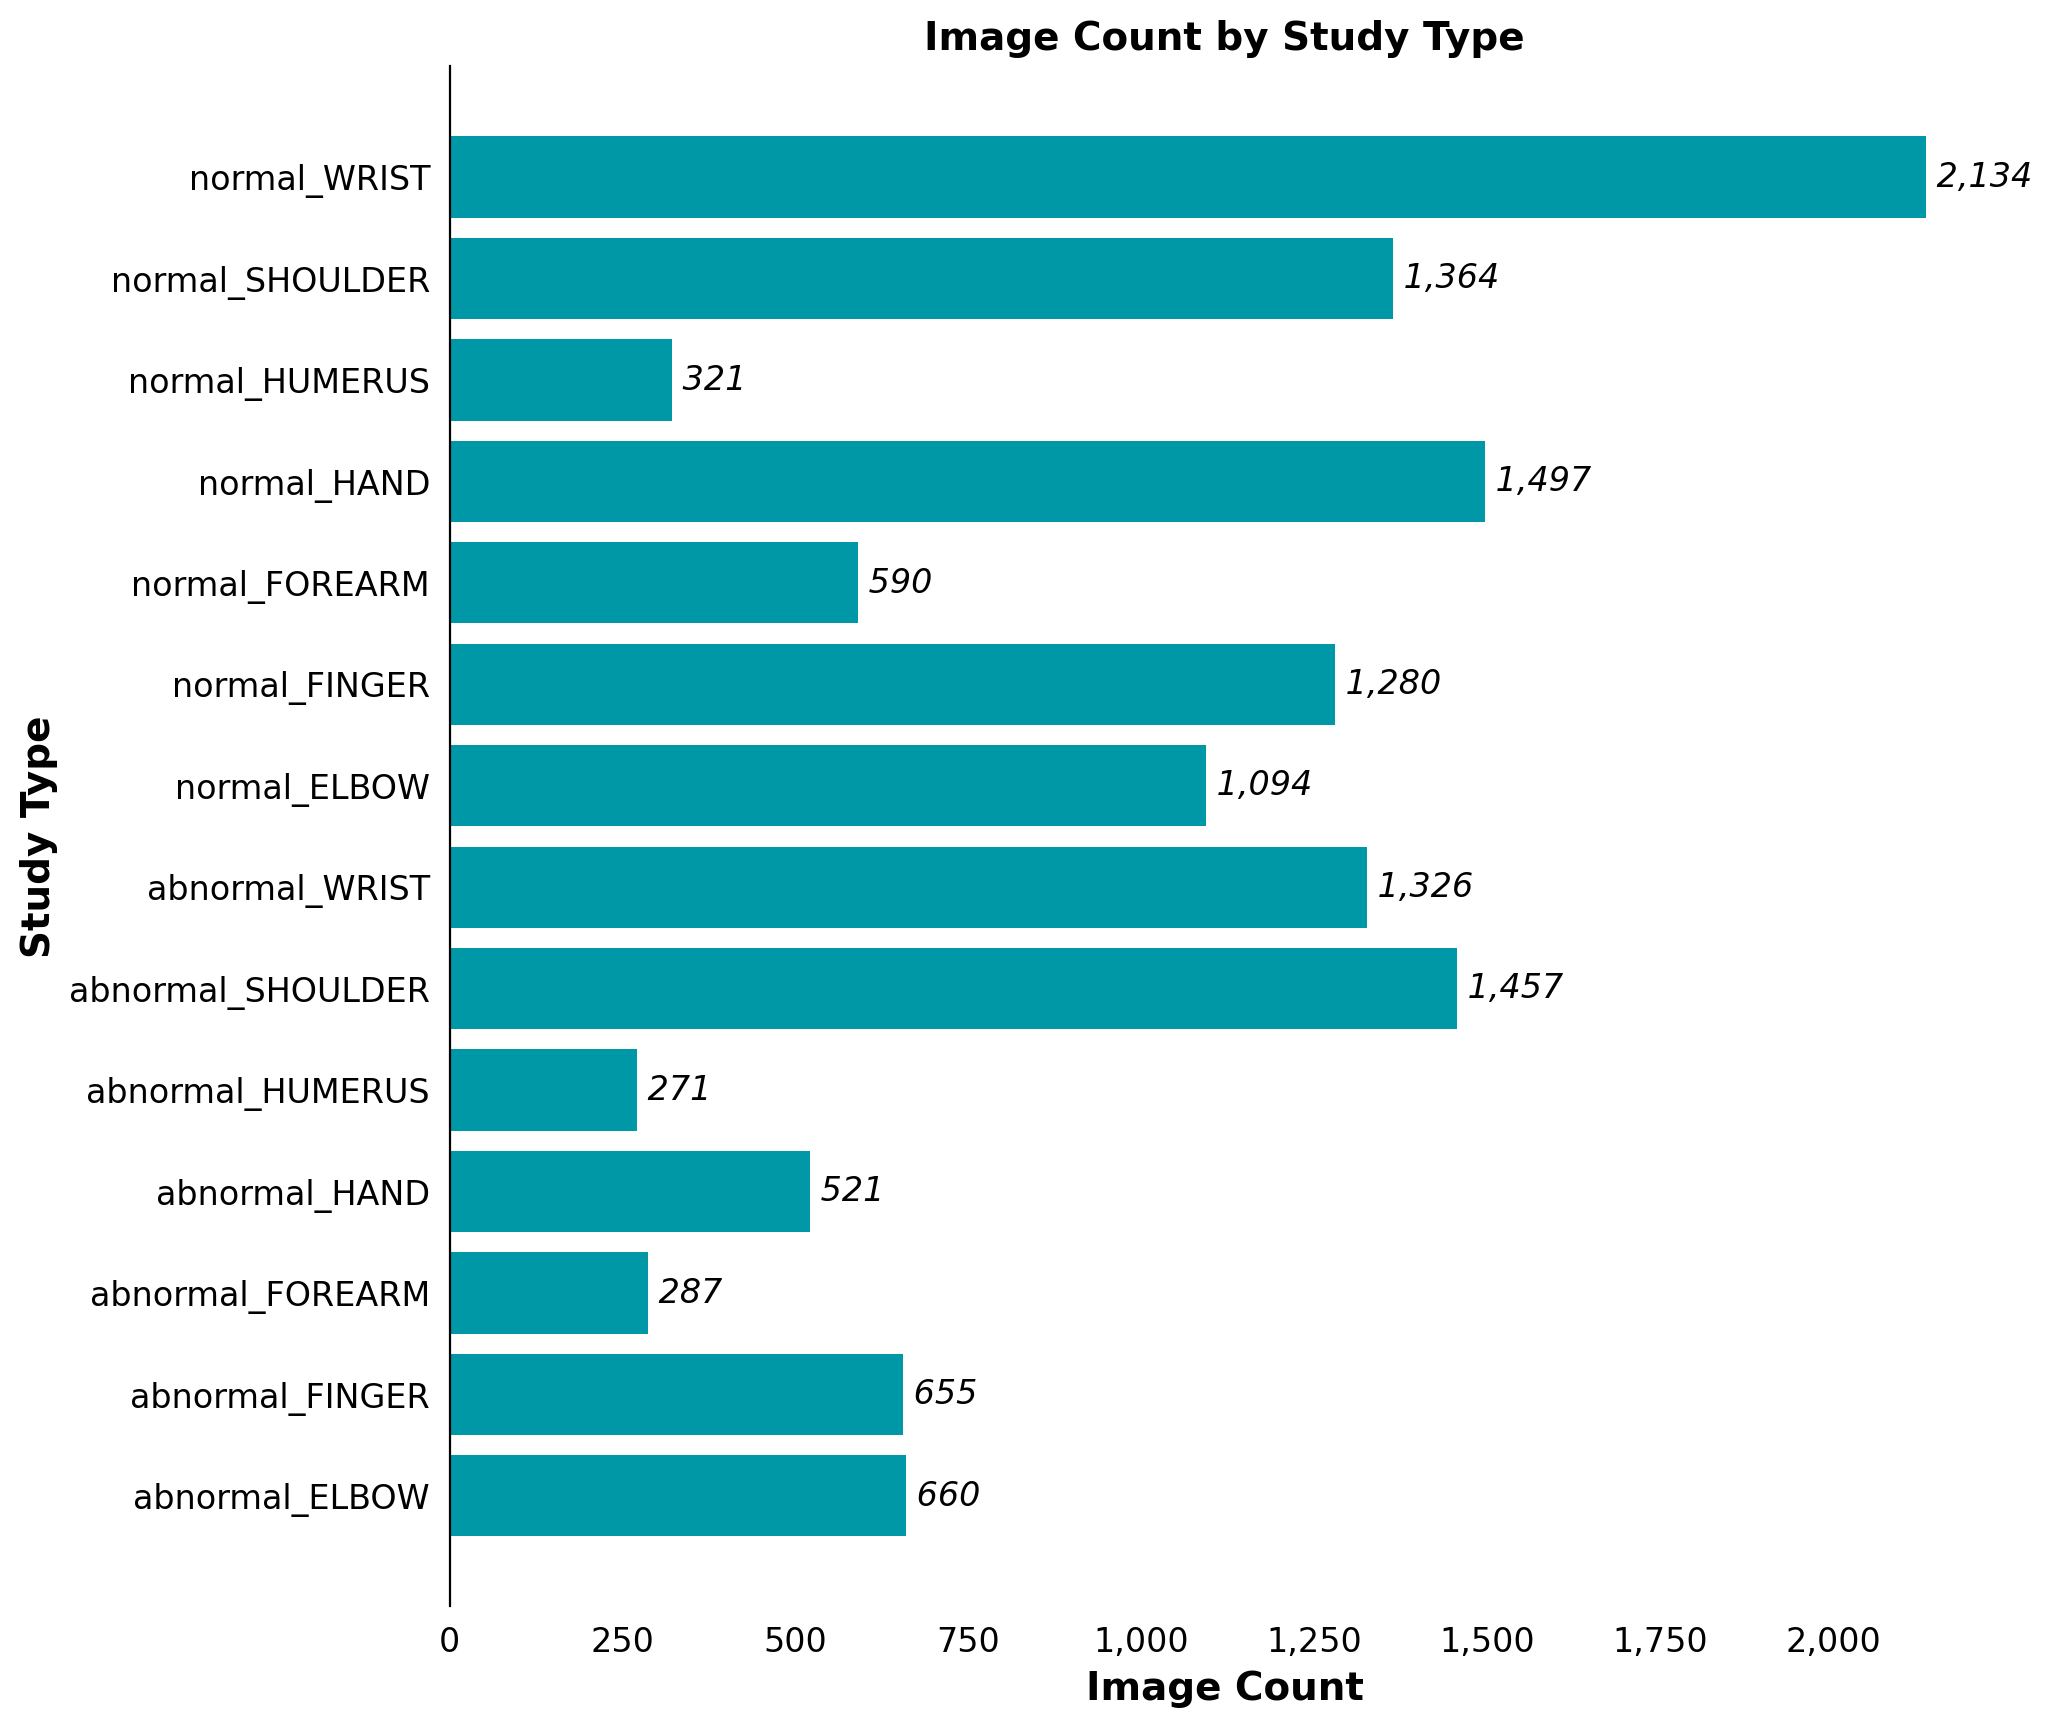

In [53]:
# train data patient count by study type with visulization
study_type_count_14(train_14)

type  Count
0      abnormal_ELBOW     66
1     abnormal_FINGER     83
2    abnormal_FOREARM     64
3       abnormal_HAND     66
4    abnormal_HUMERUS     67
5   abnormal_SHOULDER     95
6      abnormal_WRIST     97
7        normal_ELBOW     92
8       normal_FINGER     92
9      normal_FOREARM     69
10        normal_HAND    101
11     normal_HUMERUS     68
12    normal_SHOULDER     99
13       normal_WRIST    140

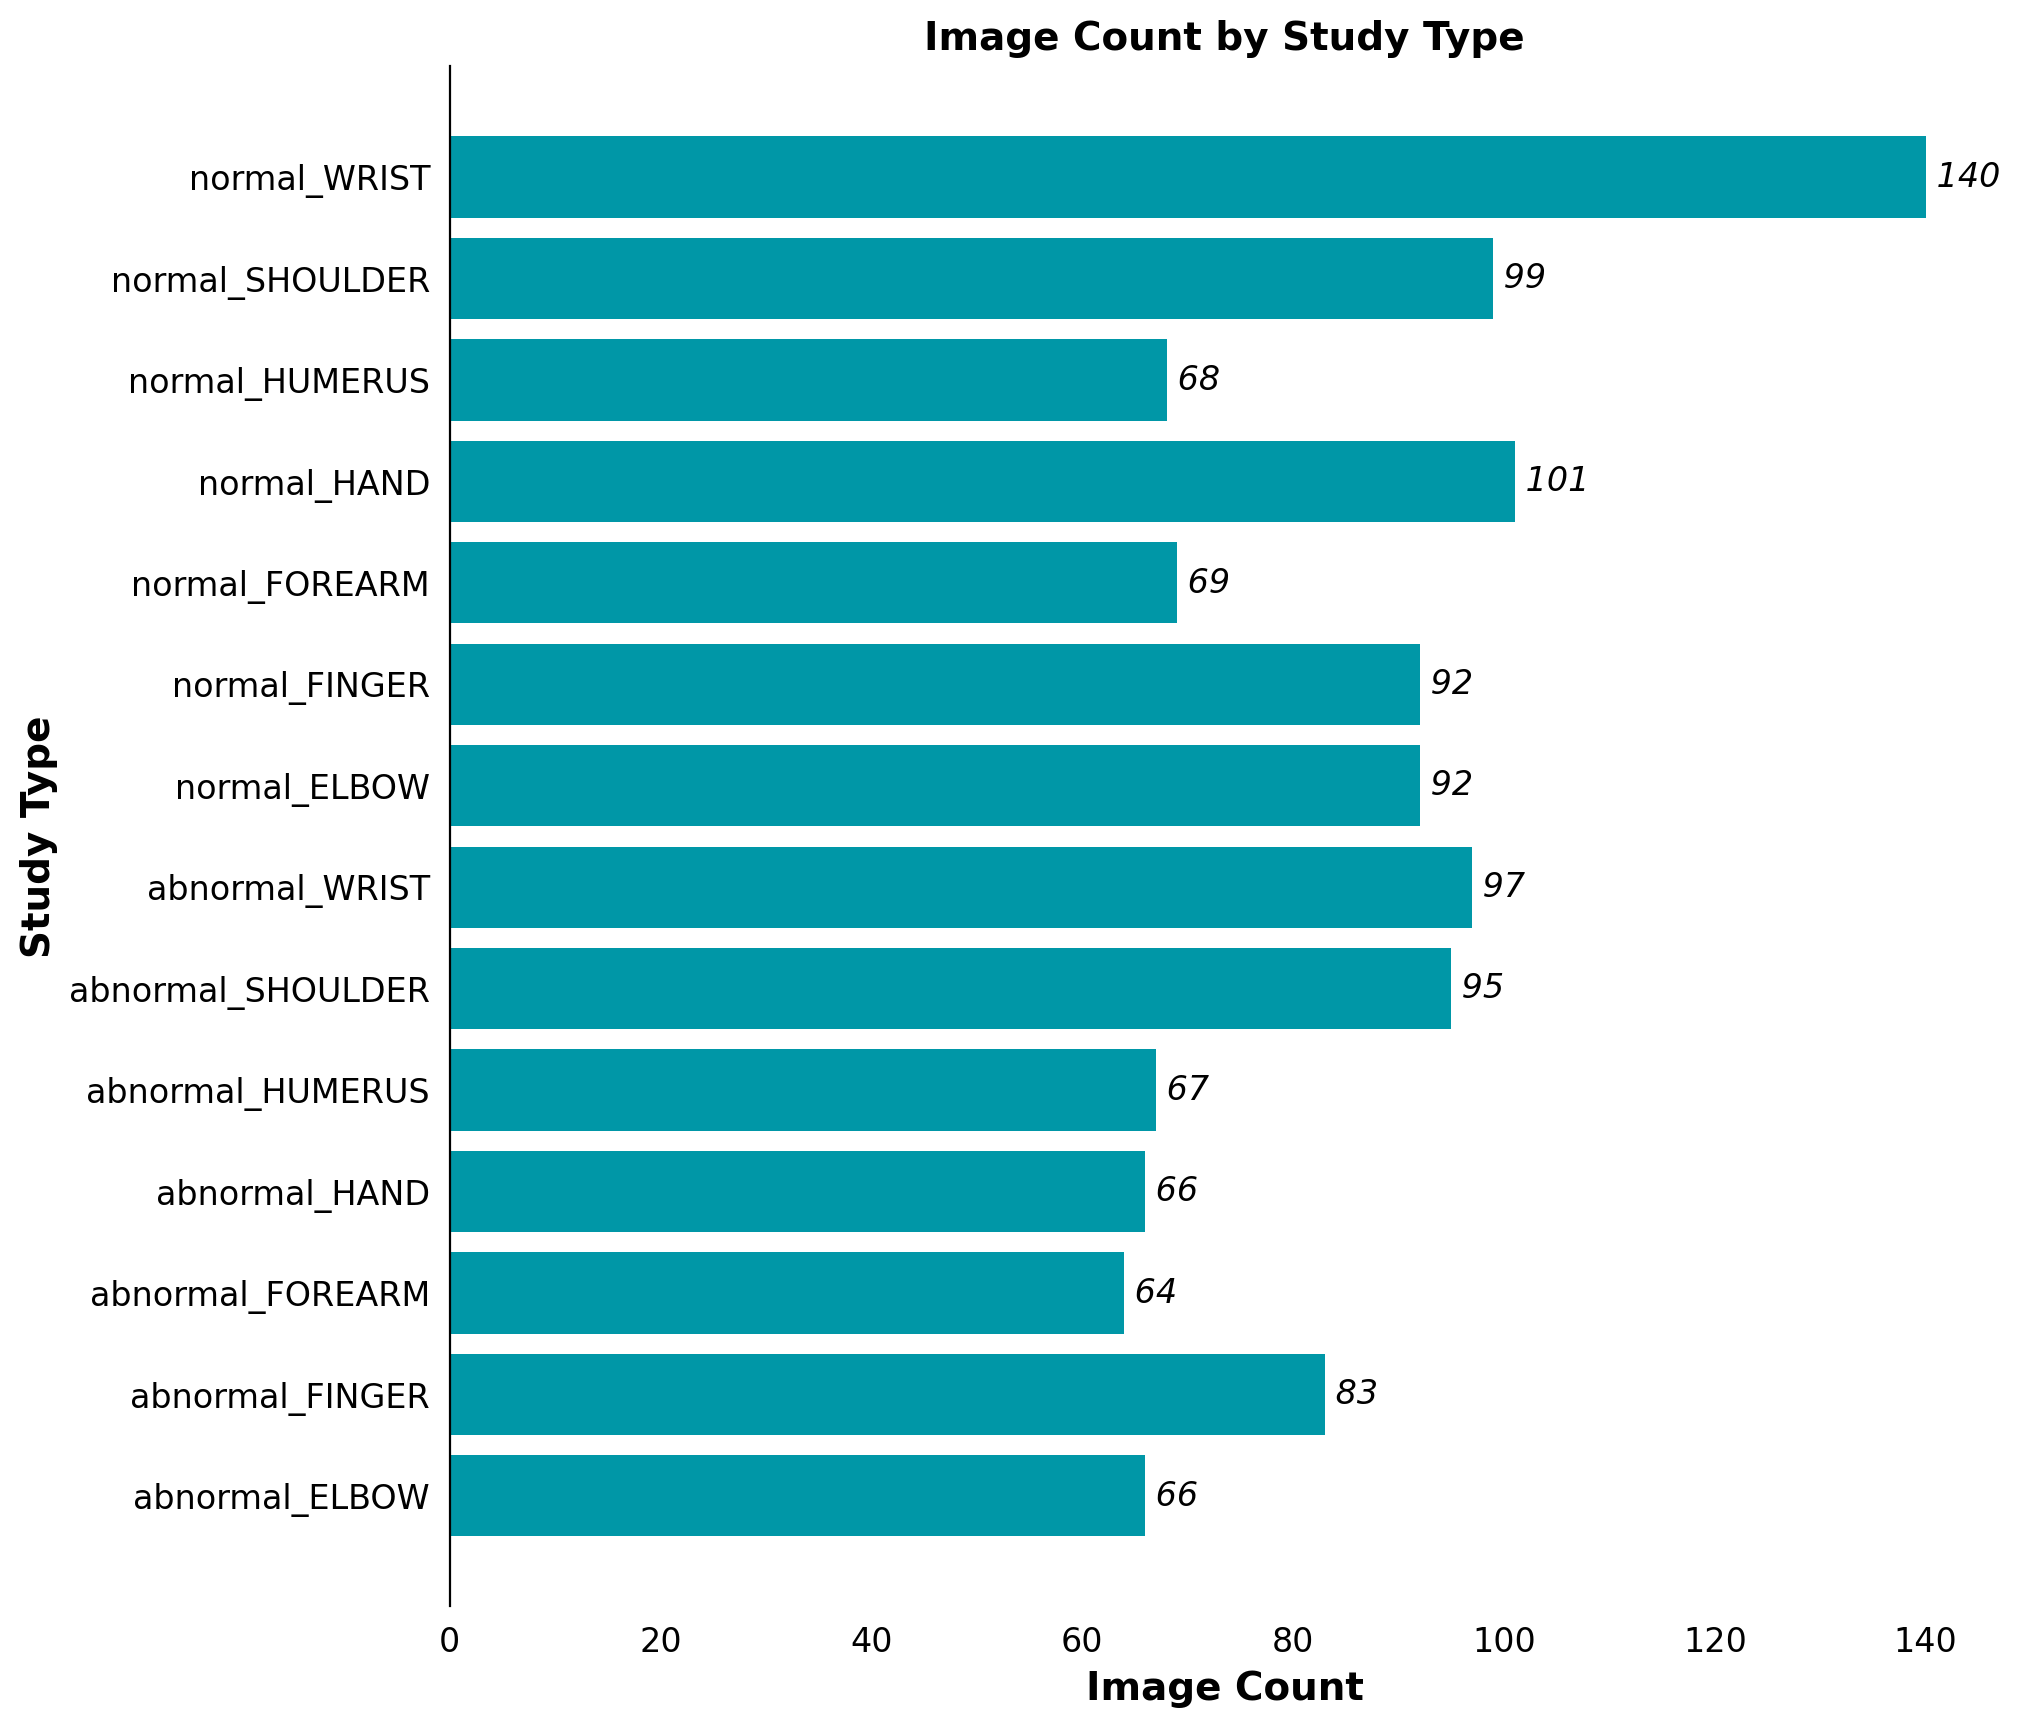

In [54]:
# test data patient count by study type with visulization
study_type_count_14(test_14)

type  Count
0      abnormal_ELBOW    726
1     abnormal_FINGER    738
2    abnormal_FOREARM    351
3       abnormal_HAND    587
4    abnormal_HUMERUS    338
5   abnormal_SHOULDER   1552
6      abnormal_WRIST   1423
7        normal_ELBOW   1186
8       normal_FINGER   1372
9      normal_FOREARM    659
10        normal_HAND   1598
11     normal_HUMERUS    389
12    normal_SHOULDER   1463
13       normal_WRIST   2274

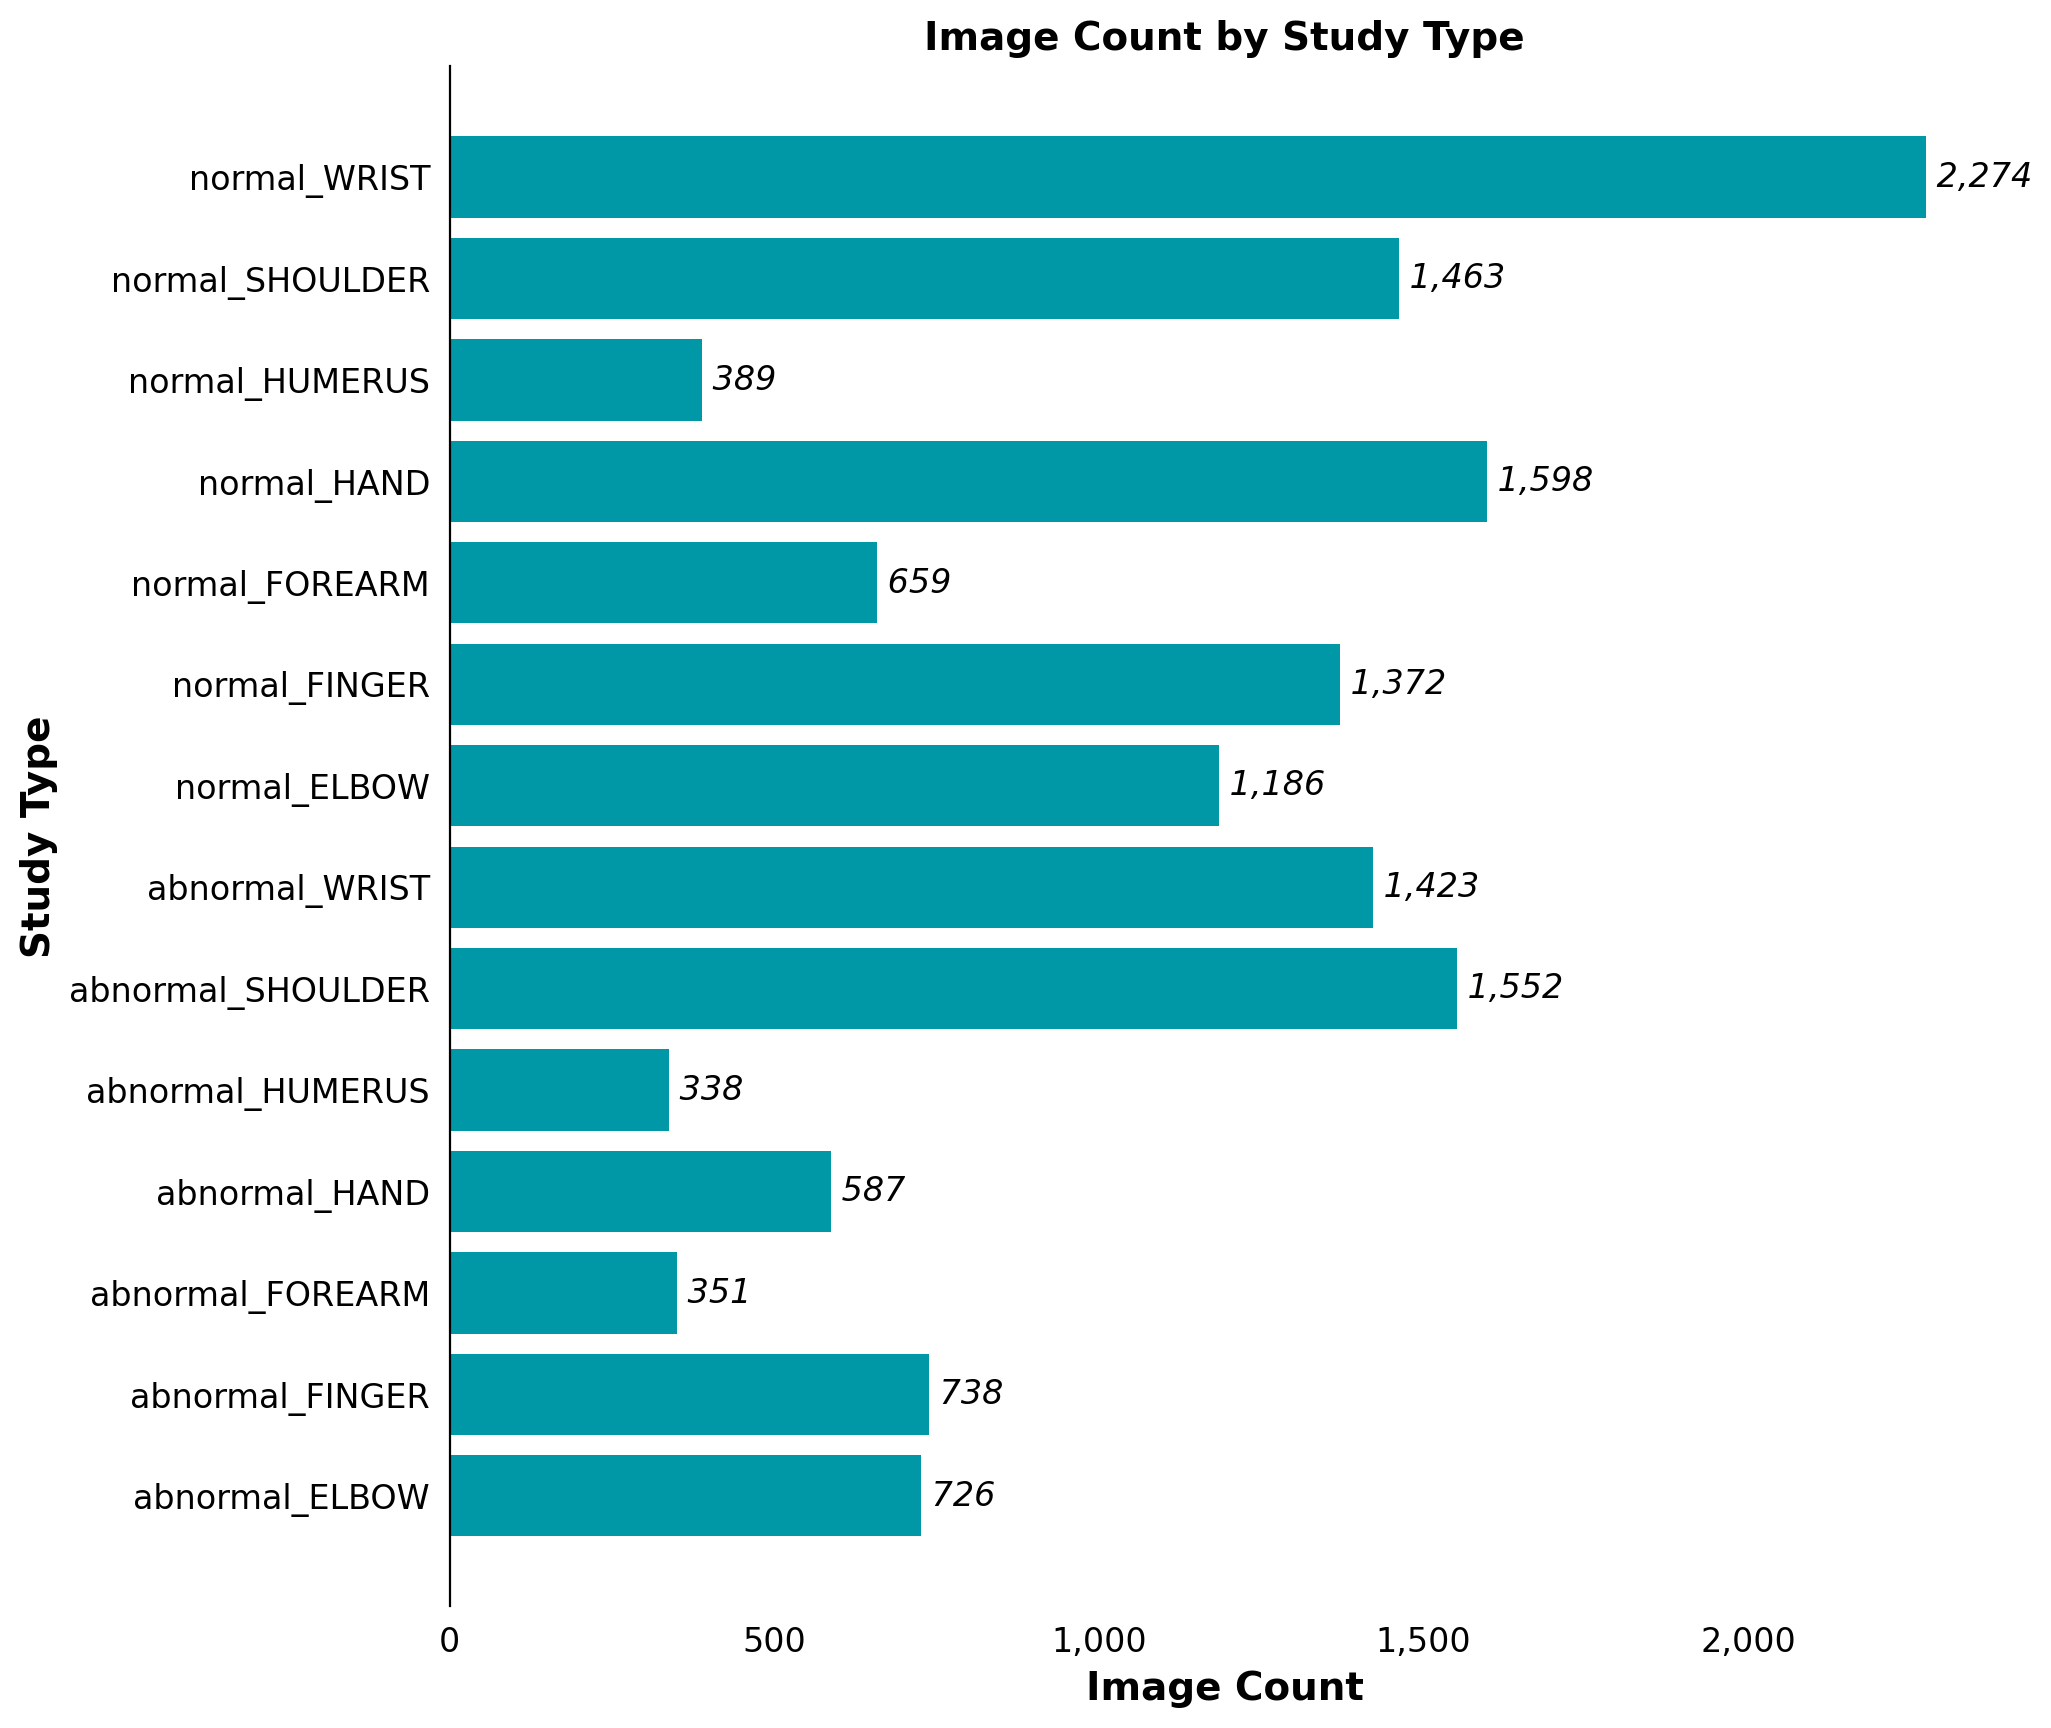

In [52]:
# combined data patient count by study type with visulization
study_type_count_14(all_data_14)

In [55]:
# function to get region count and visualisation
def region_count_14(df):
  # patient count by body part
  bdpt_df = df.groupby('type').count()['image_path'].reset_index()
  bdpt_df.columns = ['Region','Count']
  display(bdpt_df)

  # patient count by body part bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  ax.barh(bdpt_df['Region'], bdpt_df['Count'], color = '#A8D3E3')
  container = ax.containers[0]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12)
  plt.tick_params(left = False, bottom = False)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.title('Image Count by Region', fontsize = 14, weight = 'bold')
  plt.show()
  return

Region  Count
0      abnormal_ELBOW     66
1     abnormal_FINGER     83
2    abnormal_FOREARM     64
3       abnormal_HAND     66
4    abnormal_HUMERUS     67
5   abnormal_SHOULDER     95
6      abnormal_WRIST     97
7        normal_ELBOW     92
8       normal_FINGER     92
9      normal_FOREARM     69
10        normal_HAND    101
11     normal_HUMERUS     68
12    normal_SHOULDER     99
13       normal_WRIST    140

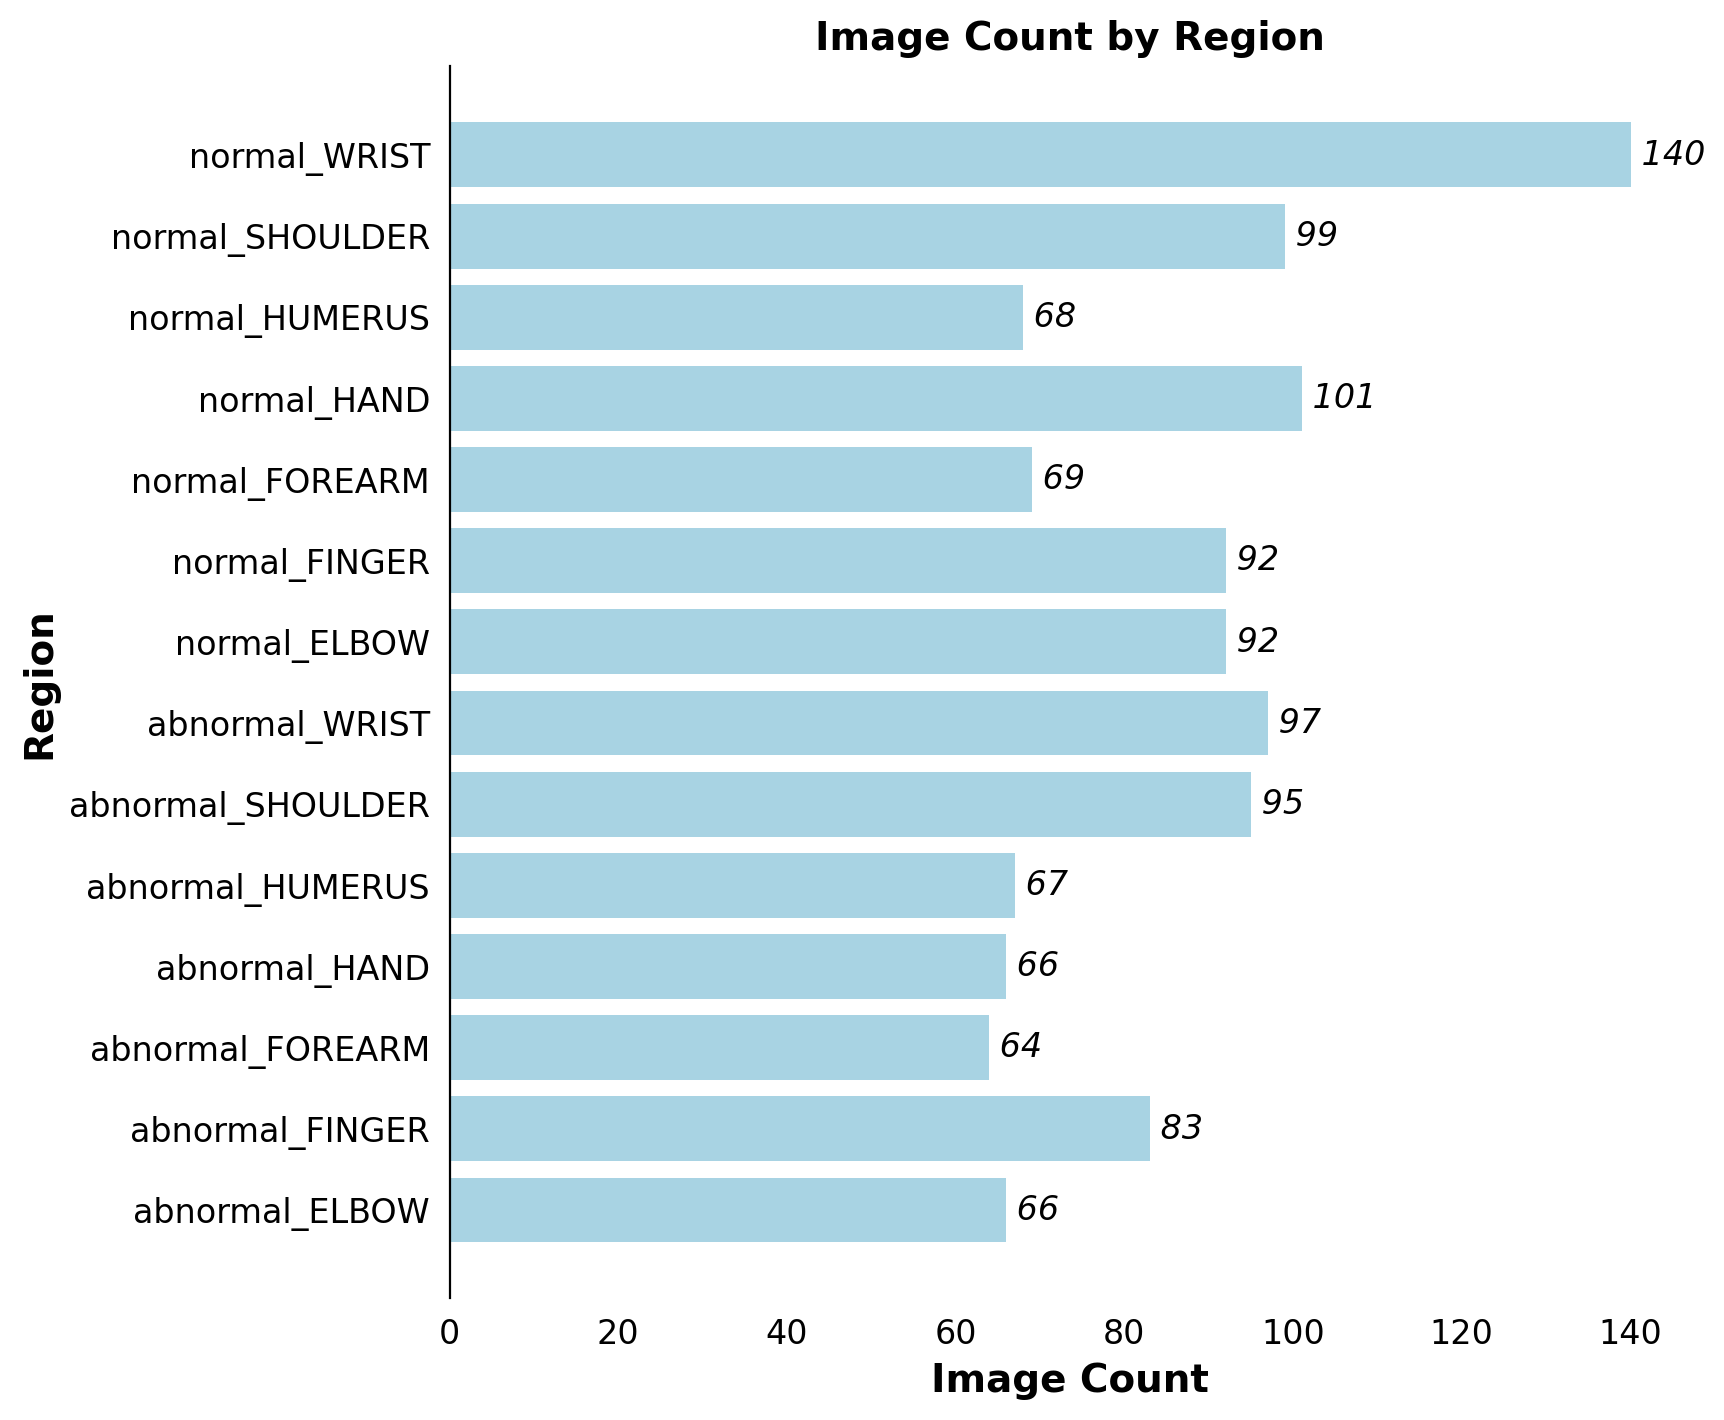

In [56]:
# test data region count and visualisation
region_count_14(test_14)

Region  Count
0      abnormal_ELBOW    660
1     abnormal_FINGER    655
2    abnormal_FOREARM    287
3       abnormal_HAND    521
4    abnormal_HUMERUS    271
5   abnormal_SHOULDER   1457
6      abnormal_WRIST   1326
7        normal_ELBOW   1094
8       normal_FINGER   1280
9      normal_FOREARM    590
10        normal_HAND   1497
11     normal_HUMERUS    321
12    normal_SHOULDER   1364
13       normal_WRIST   2134

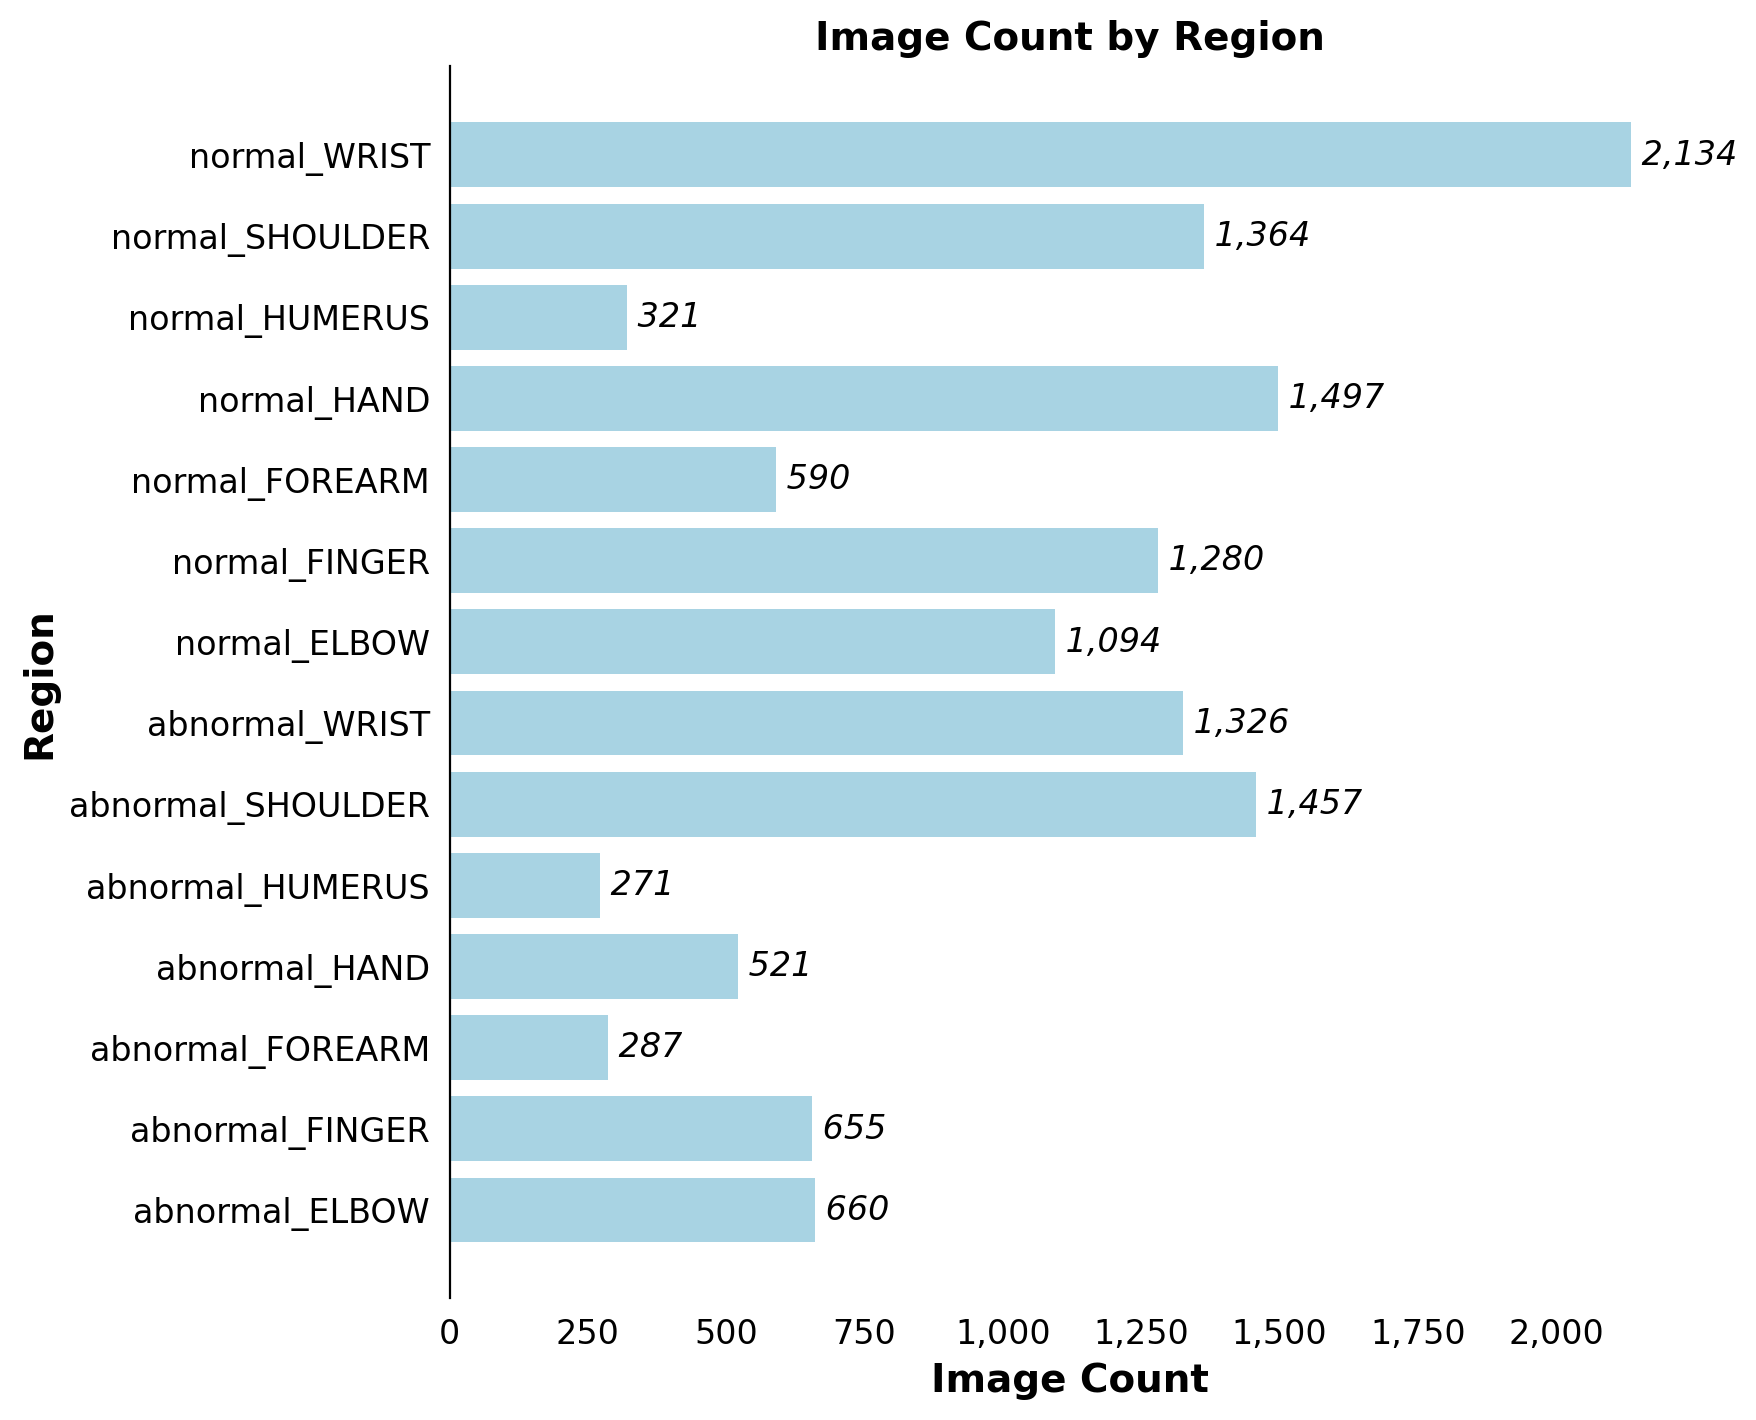

In [57]:
# train data region count and visualisation
region_count_14(train_14)

Region  Count
0      abnormal_ELBOW    726
1     abnormal_FINGER    738
2    abnormal_FOREARM    351
3       abnormal_HAND    587
4    abnormal_HUMERUS    338
5   abnormal_SHOULDER   1552
6      abnormal_WRIST   1423
7        normal_ELBOW   1186
8       normal_FINGER   1372
9      normal_FOREARM    659
10        normal_HAND   1598
11     normal_HUMERUS    389
12    normal_SHOULDER   1463
13       normal_WRIST   2274

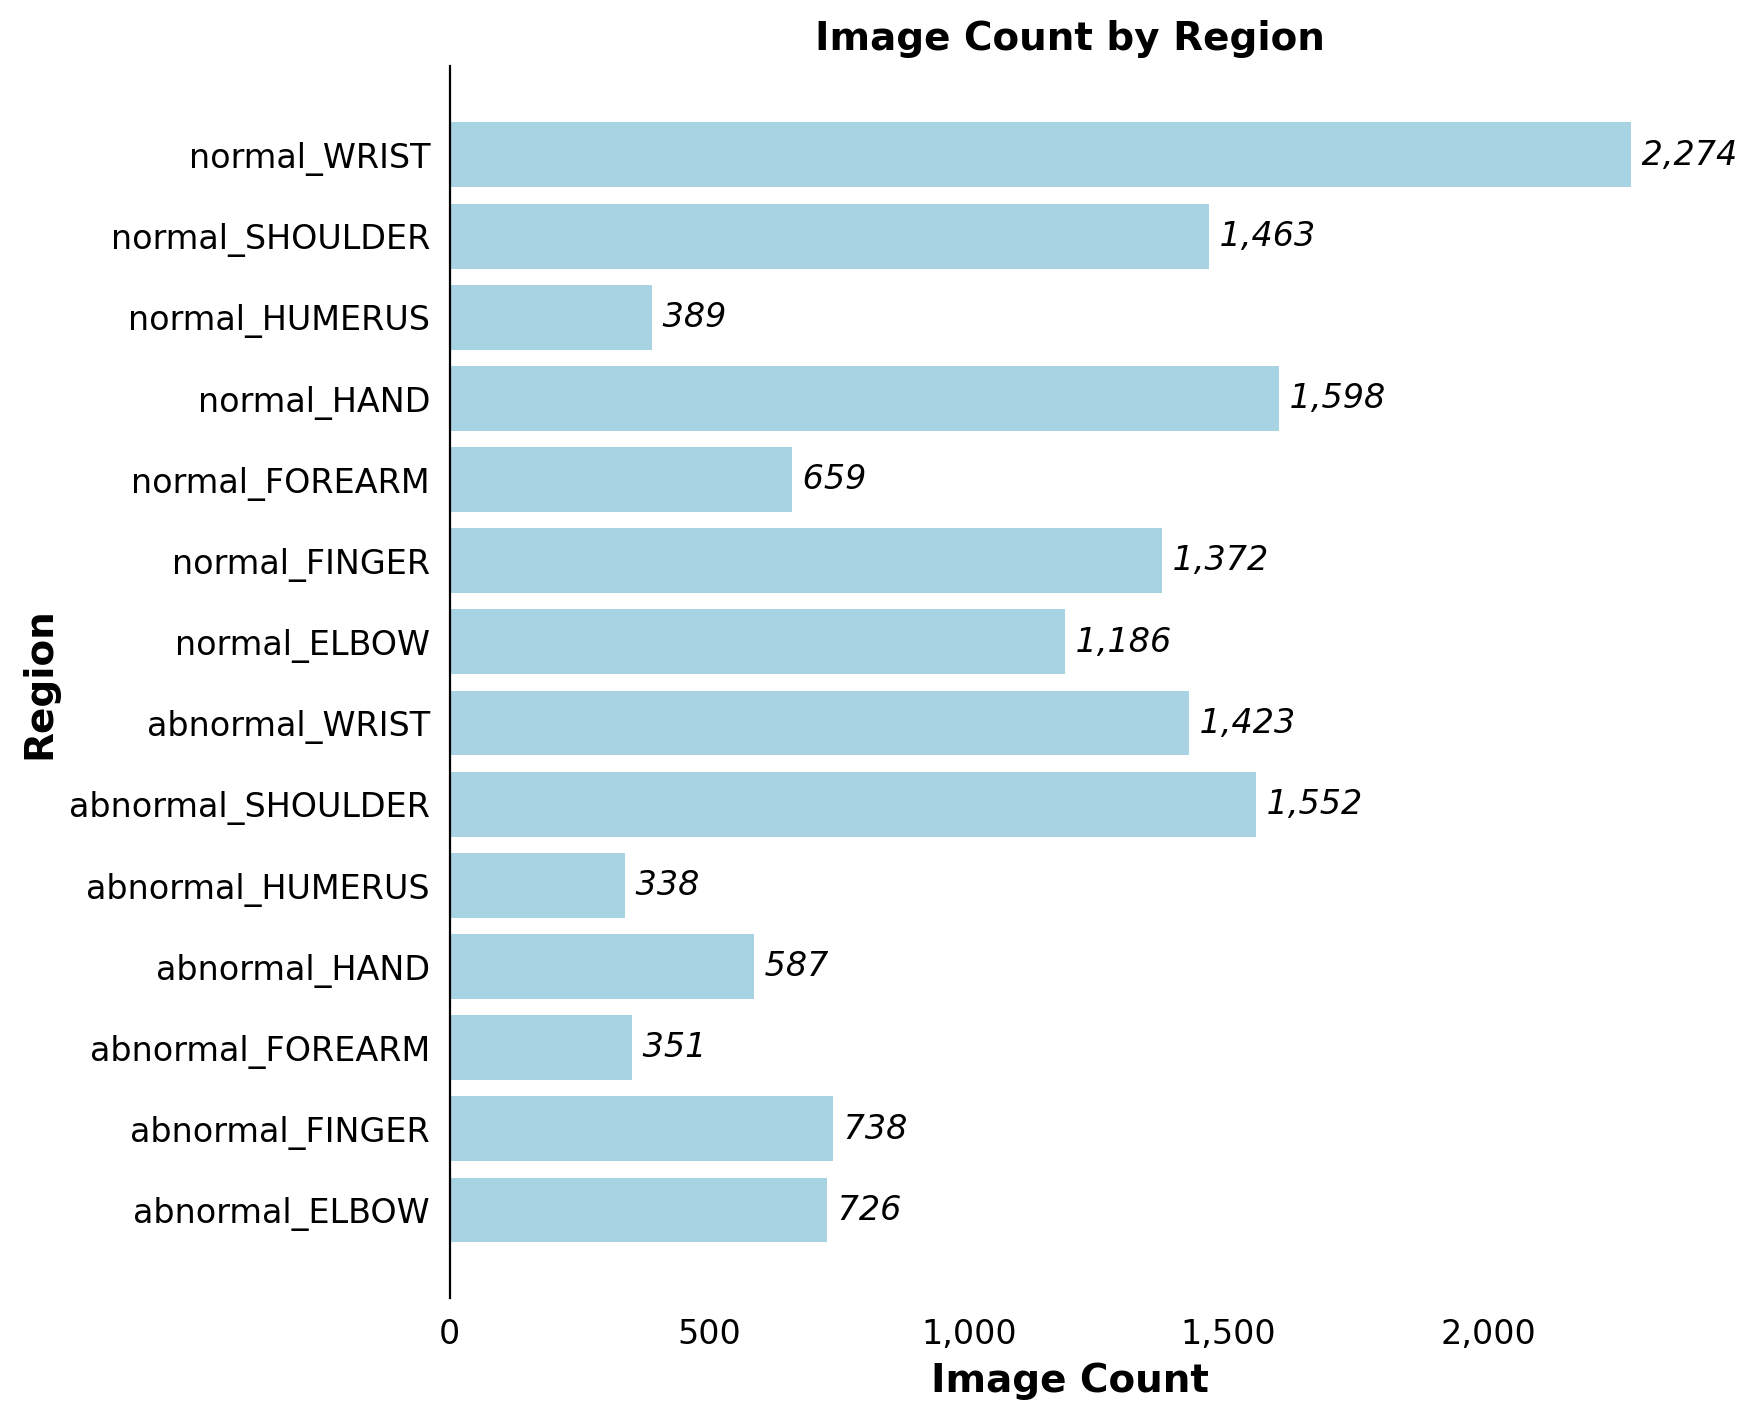

In [58]:
# combined data data region count and visualisation
region_count_14(all_data_14)

In [171]:
# function to get patient count by study type and region with visulization
def type_region_14(df):  
  stack = df.groupby(['region', 'study_type']).count()['image_path'].reset_index()
  stack.columns = ['Region','Study Type','Count']
  stack_neg = stack[stack['Study Type'] == 'normal']
  stack_pos = stack[stack['Study Type'] == 'abnormal']
  stack_all = stack_pos.merge(stack_neg, on = 'Region', how = 'left')
  stack_all['Count_z'] = stack_all['Count_x'] + stack_all['Count_y']
  display(stack_all)

  # patient count by study type and region stacked bargraph
  fig, ax = plt.subplots(figsize = (8,8))

  x = stack_all['Region']
  y1 = stack_all['Count_x']
  y2 = stack_all['Count_y']
  y3 = stack_all['Count_z']
  
  ax.barh(x, y1, color = '#A8D3E3', label = 'Abnormal')
  ax.barh(x, y2, left = y1, color = '#0097a7', label = 'Normal')
  container = ax.containers[0]
  container2 = ax.containers[1]
  ax.bar_label(container, labels = [' ' + f'{x:,.0f}' for x in container.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.bar_label(container2, labels = [' ' + f'{x:,.0f}' for x in container2.datavalues], style = 'italic', fontsize = 12, label_type = 'center')
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
  ax.set_xlabel('Image Count', fontsize = 14, weight = 'bold')
  ax.set_ylabel('Region', fontsize = 14, weight = 'bold')
  #ax.set_yticks(x, rotation = 90)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(False)
  plt.tick_params(left = False, bottom = False)
  plt.title('Image Count by Study Type and Region', fontsize = 14, weight = 'bold')
  ax.legend()

  plt.show()
  return

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal       66       normal       92      158
1    FINGER     abnormal       83       normal       92      175
2   FOREARM     abnormal       64       normal       69      133
3      HAND     abnormal       66       normal      101      167
4   HUMERUS     abnormal       67       normal       68      135
5  SHOULDER     abnormal       95       normal       99      194
6     WRIST     abnormal       97       normal      140      237

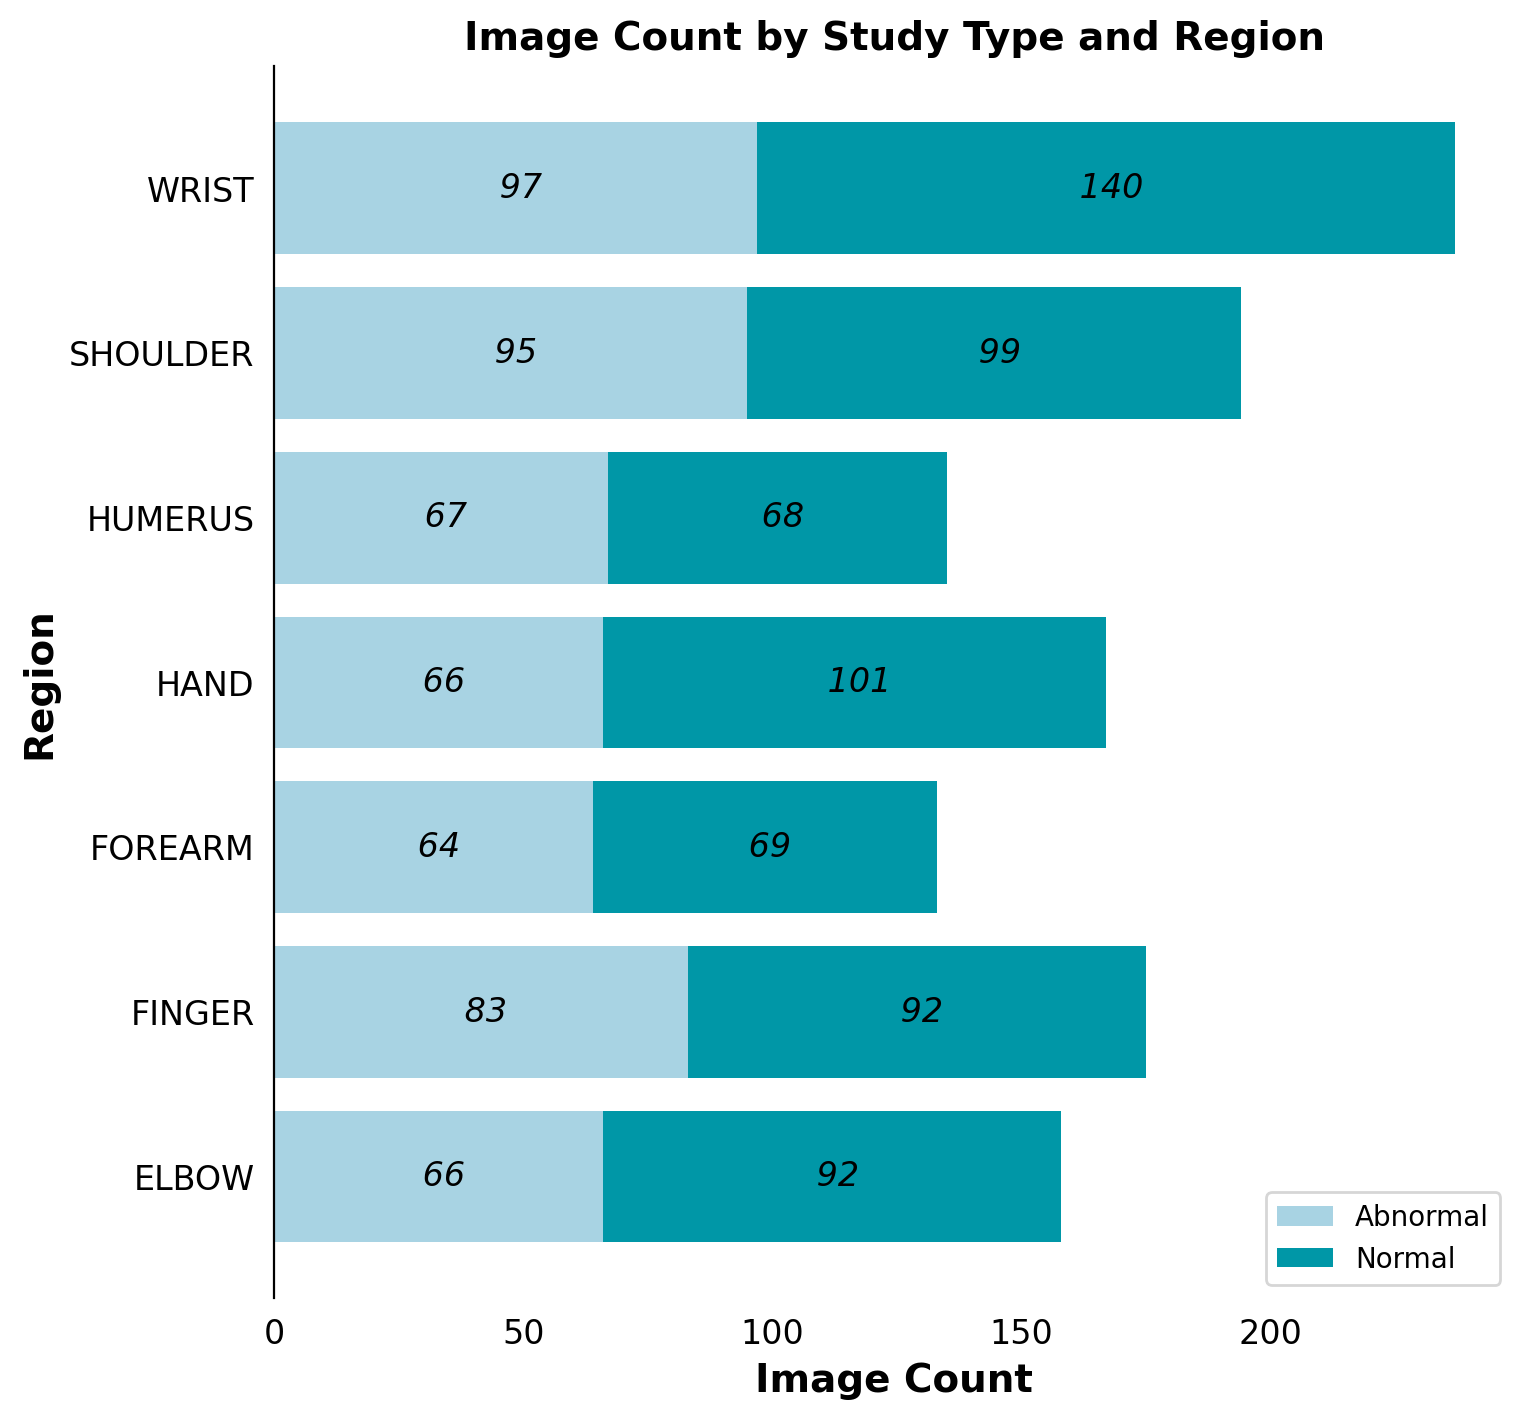

In [172]:
# test data patient count by study type and region with visulization
type_region_14(test_14)

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal      660       normal     1094     1754
1    FINGER     abnormal      655       normal     1280     1935
2   FOREARM     abnormal      287       normal      590      877
3      HAND     abnormal      521       normal     1497     2018
4   HUMERUS     abnormal      271       normal      321      592
5  SHOULDER     abnormal     1457       normal     1364     2821
6     WRIST     abnormal     1326       normal     2134     3460

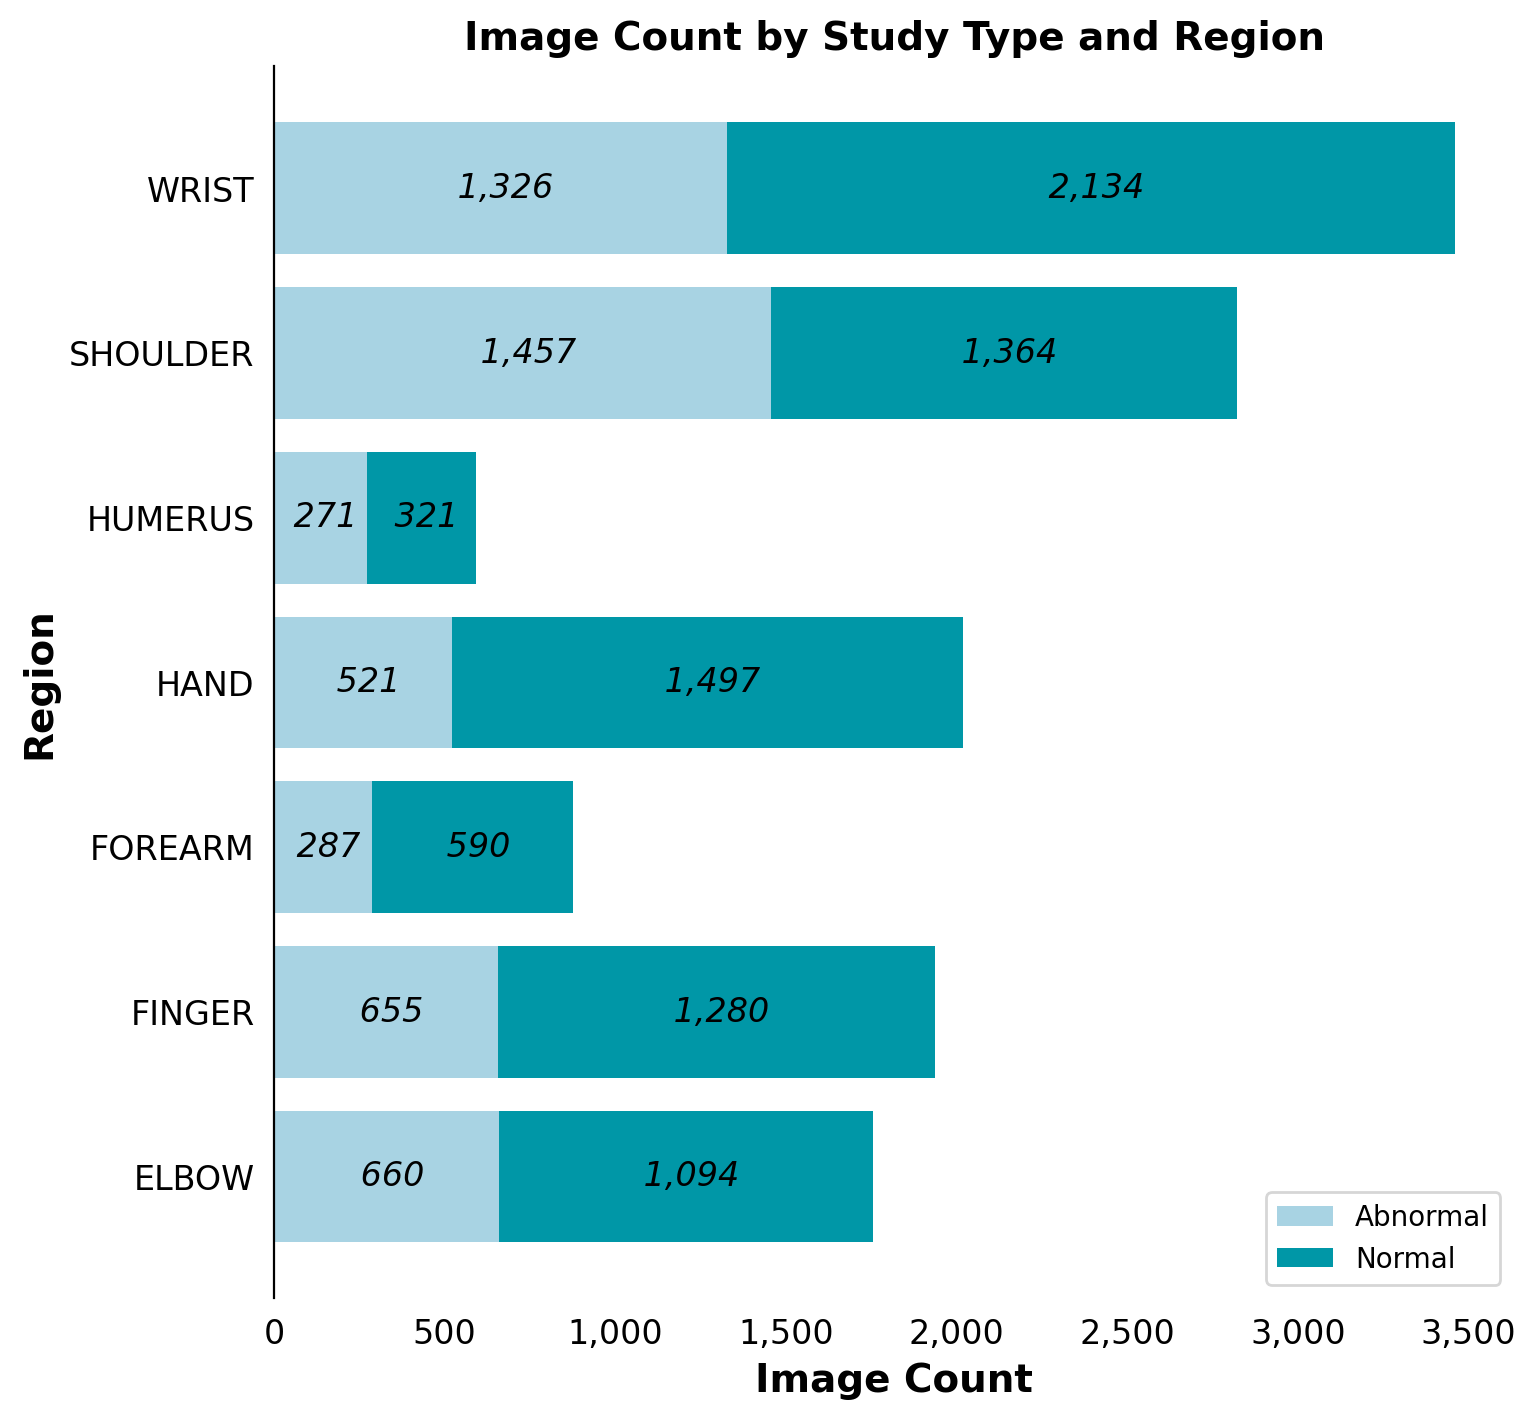

In [173]:
# train data patient count by study type and region with visulization
type_region_14(train_14)

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal      726       normal     1186     1912
1    FINGER     abnormal      738       normal     1372     2110
2   FOREARM     abnormal      351       normal      659     1010
3      HAND     abnormal      587       normal     1598     2185
4   HUMERUS     abnormal      338       normal      389      727
5  SHOULDER     abnormal     1552       normal     1463     3015
6     WRIST     abnormal     1423       normal     2274     3697

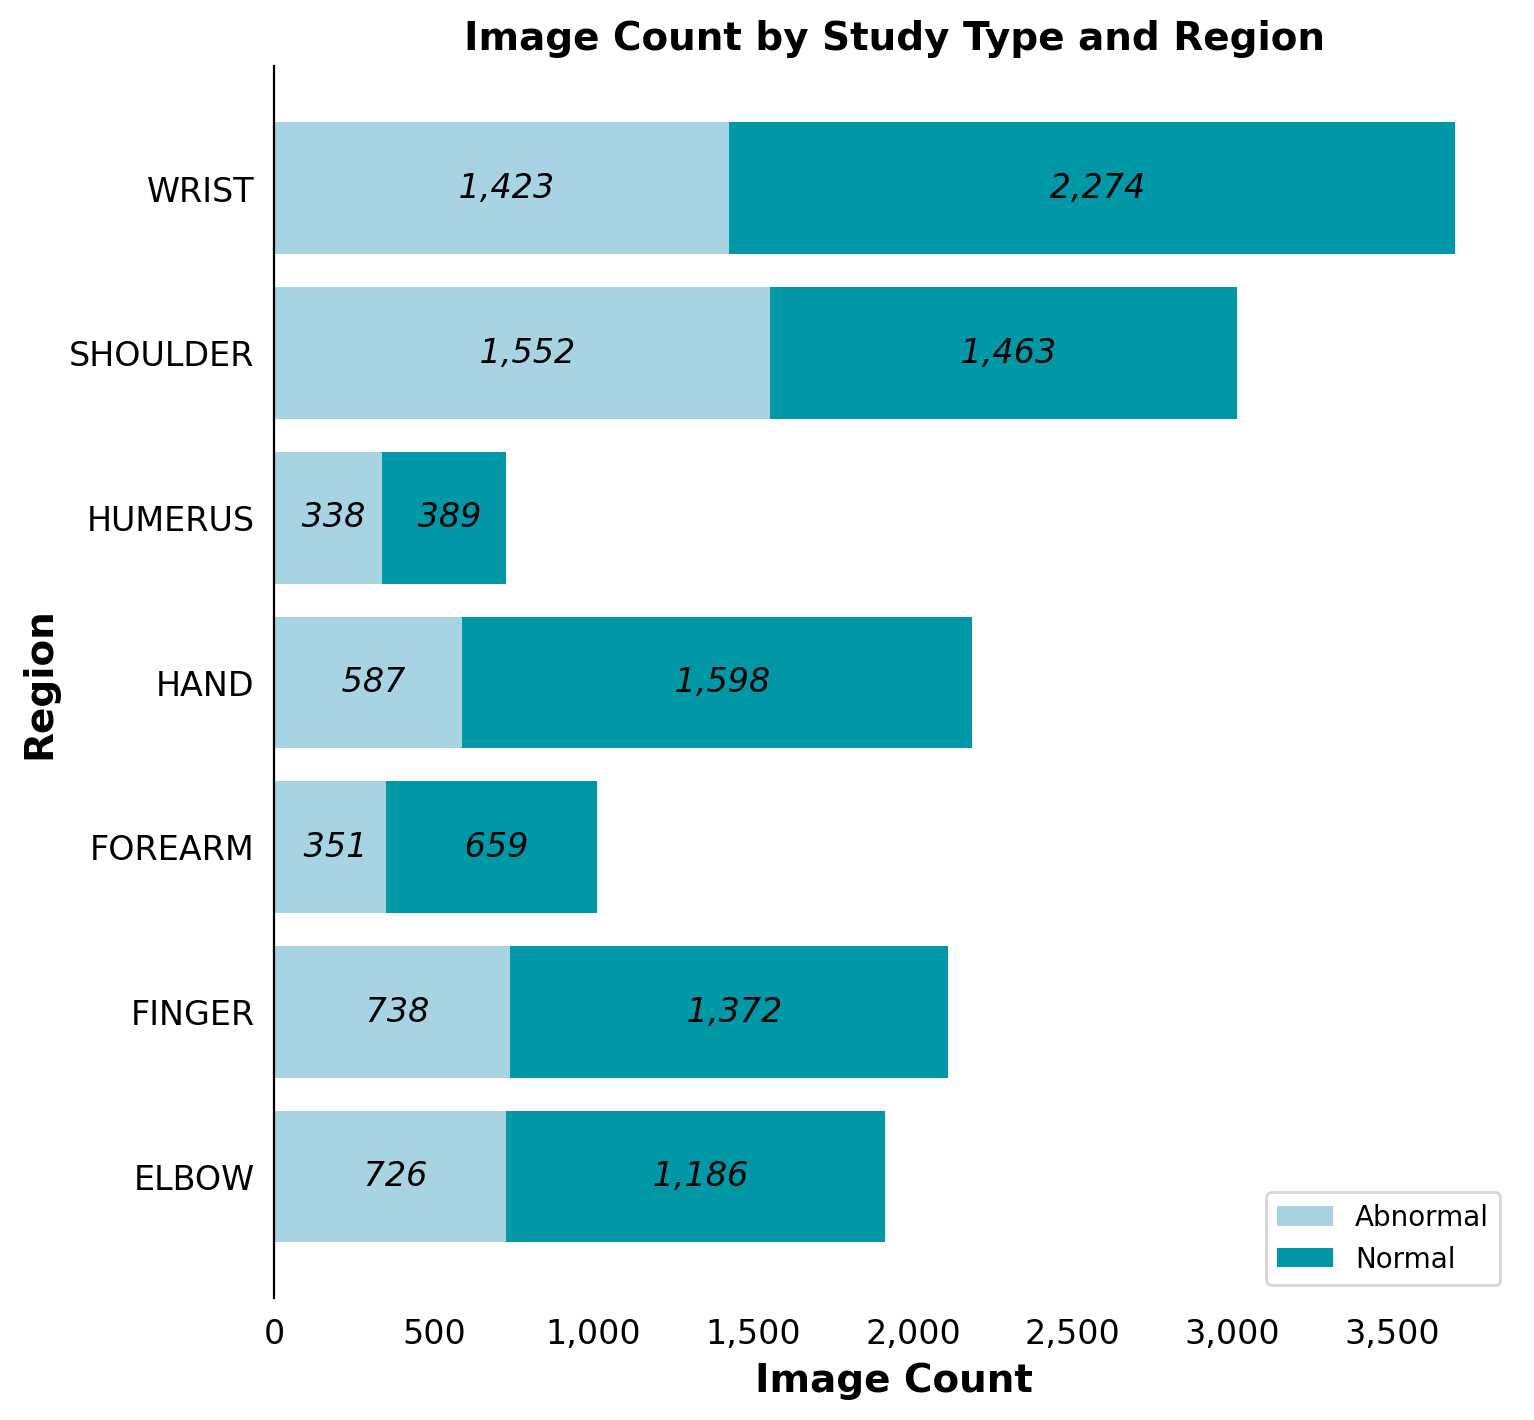

In [174]:
# combined data patient count by study type and region with visulization
type_region_14(all_data_14)

# Data Preprocessing

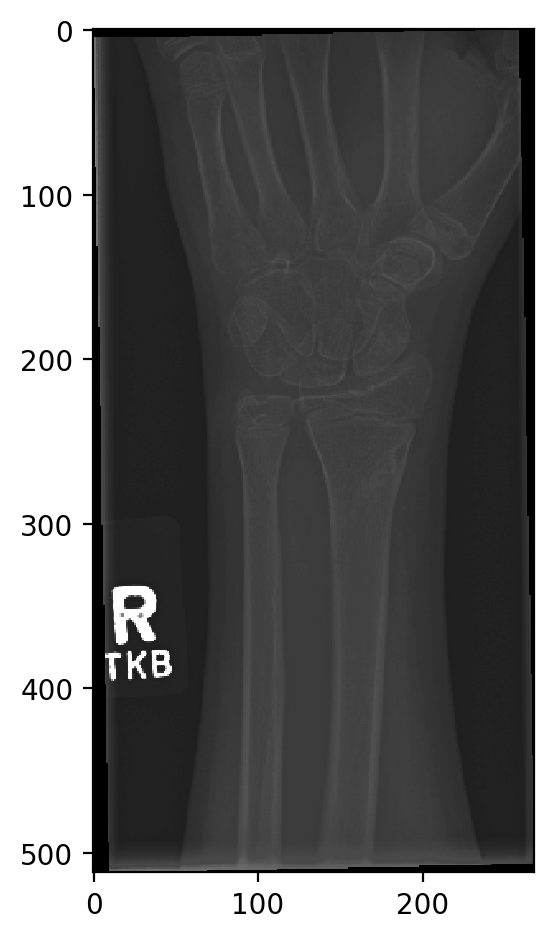

In [95]:
# look at an image
io.imshow(test.iloc[0,0] + 'image1.png')

In [96]:
# patients with 4 studies
all_data[all_data['study'] == 4]

image_path  \
82    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00074/study4_negative/   
163   drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00147/study4_negative/   
602   drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00551/study4_positive/   
1437  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient01344/study4_negative/   
7554     drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient04110/study4_negative/   
8023     drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient04282/study4_negative/   
8049     drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient06096/study4_negative/   
8900     drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient07718/study4_negative/   
107      drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study4_negative/   

        patient_id  study study_type    region    target  
82    patient00074      4     normal  SHOULDER    normal  
163   patient00147      4     normal  SHOULDER    normal  
602   patient00551      4   abnormal  SHOULDER  abnormal  
1437  patient01344      4     normal  SHOULDER    normal  
7554  patient04110      4     normal     WRIST    normal  
8023  patient04282      4     normal     WRIST    normal  
8049  patient06096      4     normal     WRIST    normal  
8900  patient07718      4     normal     WRIST    normal  
107   patient11272      4     normal     WRIST    normal

In [100]:
# lets look at one of these patients
all_data[all_data['patient_id'] == 'patient11272']

image_path  \
104      drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study1_positive/   
105      drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study2_negative/   
106      drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study3_negative/   
107      drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study4_negative/   
864   drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11272/study1_negative/   
1106    drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11272/study1_positive/   

        patient_id  study study_type    region    target  
104   patient11272      1   abnormal     WRIST  abnormal  
105   patient11272      2     normal     WRIST    normal  
106   patient11272      3     normal     WRIST    normal  
107   patient11272      4     normal     WRIST    normal  
864   patient11272      1     normal  SHOULDER    normal  
1106  patient11272      1   abnormal    FINGER  abnormal

In [101]:
# lets see patients with 3 studies
all_data[all_data['study'] == 3]

image_path  \
81     drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00074/study3_negative/   
162    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00147/study3_negative/   
319    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00293/study3_negative/   
325    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00297/study3_positive/   
352    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00321/study3_negative/   
419    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00382/study3_negative/   
504    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00461/study3_positive/   
601    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00551/study3_positive/   
661    drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00604/study3_negative/   
1436   drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient01344/study3_negative/   
1884   drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient01772/study3_negative/   
3817     drive/MyDrive/MURA-v1.1/train/XR_FINGER/patient03570/study3_negative/   
4070     drive/MyDrive/MURA-v1.1/train/XR_FINGER/patient03787/study3_negative/   
4279     drive/MyDrive/MURA-v1.1/train/XR_FINGER/patient03970/study3_negative/   
4363     drive/MyDrive/MURA-v1.1/train/XR_FINGER/patient04043/study3_negative/   
5548      drive/MyDrive/MURA-v1.1/train/XR_ELBOW/patient00466/study3_negative/   
7152      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient04471/study3_negative/   
7159      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient06396/study3_negative/   
7250      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient06473/study3_negative/   
7299      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient06513/study3_negative/   
7381      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient02919/study3_negative/   
7423      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient04568/study3_negative/   
7553      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient04110/study3_negative/   
8022      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient04282/study3_negative/   
8048      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient06096/study3_positive/   
8116      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient04320/study3_negative/   
8162      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient01669/study3_negative/   
8308      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient07257/study3_negative/   
8385      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient00949/study3_negative/   
8640      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient03549/study3_negative/   
8899      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient07718/study3_negative/   
9567      drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient05090/study3_negative/   
11785      drive/MyDrive/MURA-v1.1/train/XR_HAND/patient09984/study3_negative/   
12117      drive/MyDrive/MURA-v1.1/train/XR_HAND/patient04695/study3_negative/   
12872      drive/MyDrive/MURA-v1.1/train/XR_HAND/patient05372/study3_negative/   
3         drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/   
51        drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11227/study3_negative/   
95        drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11264/study3_negative/   
106       drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11272/study3_negative/   
270     drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11418/study3_negative/   
480        drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11218/study3_negative/   
691    drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11707/study3_negative/   
711    drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11417/study3_negative/   
723    drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11300/study3_negative/   
1105     drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/   

         patient_id  study study_type    region    target  
81     patient00074      3     normal  SHOULDER    normal  
162    patient00147      3     normal  SHOULDER    normal  
319    patient00293      3     normal  SHOULDER    normal  
325    patient00297      3   abnormal  SHOULDER  abnorm

In [102]:
# now lets look at one of these 3 study patients
all_data[all_data['patient_id'] == 'patient11186']

image_path  \
1       drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/   
2       drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/   
3       drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/   
548   drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11186/study1_positive/   
697  drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/   
872     drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/   

       patient_id  study study_type    region    target  
1    patient11186      1   abnormal     WRIST  abnormal  
2    patient11186      2   abnormal     WRIST  abnormal  
3    patient11186      3   abnormal     WRIST  abnormal  
548  patient11186      1   abnormal   HUMERUS  abnormal  
697  patient11186      1   abnormal  SHOULDER  abnormal  
872  patient11186      1   abnormal     ELBOW  abnormal

In [104]:
# now lets look at what is in the file paths
path = test.iloc[107,0]
f = os.listdir(path)
print(f)

['image3.png', 'image1.png', 'image2.png']


In [107]:
# lets get one of these images and view the raw data
images = []
for i, img in enumerate(os.listdir(path)):
  images.append(io.imread(path + img))

In [71]:
images

[array([[ 0,  0,  0, ..., 74, 74, 75],
        [ 0,  0,  0, ..., 74, 74, 74],
        [ 0,  0,  0, ..., 72, 71, 71],
        ...,
        [44, 40, 36, ..., 37, 36, 36],
        [45, 40, 36, ..., 36, 36, 36],
        [45, 40, 36, ..., 36, 35, 36]], dtype=uint8),
 array([[ 0,  0,  0, ..., 63, 66, 66],
        [ 0,  0,  0, ..., 62, 63, 64],
        [41, 42, 42, ..., 59, 61, 60],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[ 0,  0,  0, ..., 51, 49, 48],
        [ 0,  0,  0, ..., 51, 45, 45],
        [ 0,  0,  0, ..., 49, 45, 44],
        ...,
        [29, 30, 30, ...,  0,  0,  0],
        [29, 29, 29, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)]

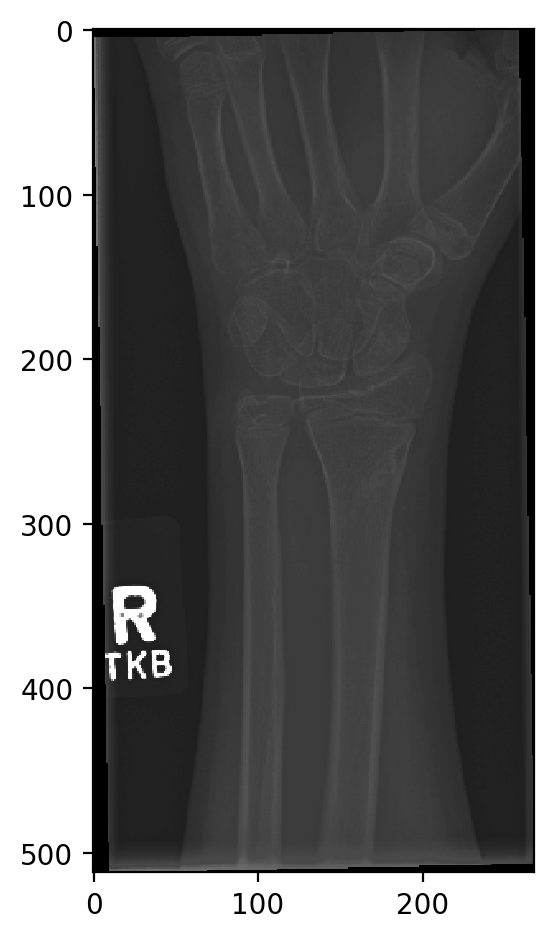

In [109]:
# lets view an image
a = io.imread(test.iloc[0,0] + 'image1.png')
io.imshow(a)

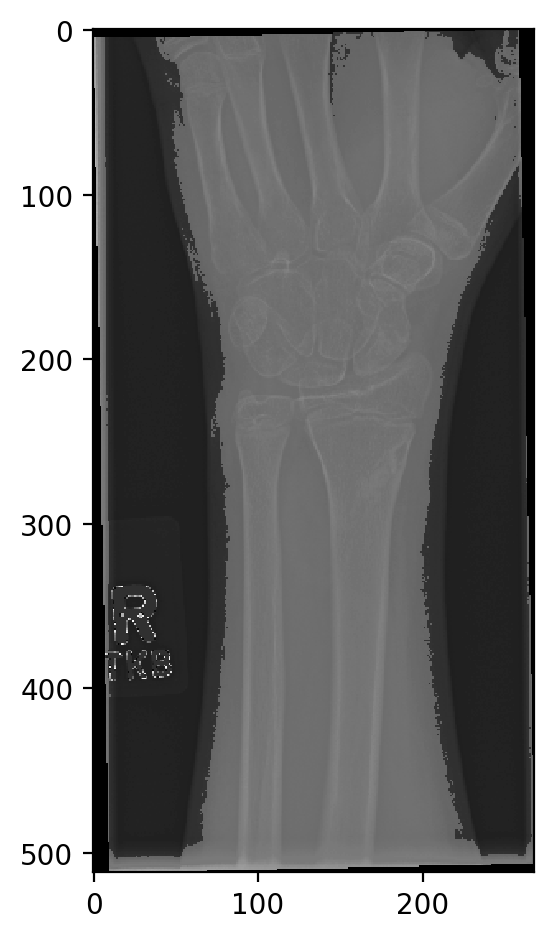

In [111]:
# lets brighten the image
a[a>50] +=50
io.imshow(a)

In [112]:
# lets look at the image shape
a.shape

(512, 268)

In [113]:
# now lets read the image as a tensor
b = read_image(test.iloc[0,0] + 'image1.png')

In [114]:
b

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [115]:
b.shape

torch.Size([1, 512, 268])

We should check the sizes of all the shape to see the differences

In [116]:
pd.set_option('max_colwidth', 400)
p = pull_images_target(test[0:20])
p.head()

image  \
0  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png   
1  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png   
2  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png   
3  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png   
4  drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png   

     target  
0  abnormal  
1  abnormal  
2  abnormal  
3  abnormal  
4  abnormal

In [151]:
# lets make a custom dataset for our data
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#https://blog.paperspace.com/working-with-custom-image-datasets-in-pytorch/

class MuraDataset(Dataset):
    def __init__(self, mura_df, transform=None):
        self.mura_df = mura_df
        self.transform = transform

    def __len__(self):
        return len(self.mura_df)

    def __getitem__(self, idx):
        image = read_image(self.mura_df.iloc[idx]['image_path'])
        label = self.mura_df.iloc[idx]['target']

        if self.transform:
            image = self.transform(sample)

        return image, label


***Each patient have multi-view images for the same region. Hence using all those images for training the model.***

In [118]:
#using the file with 36K image paths for data modelling

train_df = pd.read_csv('drive/MyDrive/MURA-v1.1/train_image_paths.csv', header = None, names = ['image_path'])
test_df = pd.read_csv('drive/MyDrive/MURA-v1.1/valid_image_paths.csv', header = None, names = ['image_path'])

In [119]:
train_df.shape

(36808, 1)

In [84]:
test_df.shape

(3197, 1)

In [120]:
# clean up and extract info from csv
def clean_image_df(df):
  temp = df['image_path'].str.split('/', expand=True)
  new_df = pd.DataFrame(df['image_path'])
  new_df['patient_id'] = temp[3]
  new_df['study'] = temp[4].str.split('_', expand = True)[0].str[-1:].astype(int)
  new_df['study_type'] = temp[4].str.split('_', expand = True)[1]
  new_df['region'] = temp[2].str.split('_', expand = True)[1]
  new_df['target'] = temp[4].str.split('_', expand = True)[1]
  map = {'positive':'abnormal', 'negative':'normal'}
  new_df['study_type'] = new_df['study_type'].map(map)
  new_df['target'] = new_df['target'].map(map)
  #add google drive location to image path
  new_df['image_path'] = 'drive/MyDrive/' + new_df['image_path']

  return new_df

In [122]:
# create new train and test with all images rather than by patient
train_df= clean_image_df(train_df)
test_df= clean_image_df(test_df)

In [124]:
train_df.head()

image_path  \
0  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png   
1  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png   
2  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png   
3  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png   
4  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png   

     patient_id  study study_type    region    target  
0  patient00001      1   abnormal  SHOULDER  abnormal  
1  patient00001      1   abnormal  SHOULDER  abnormal  
2  patient00001      1   abnormal  SHOULDER  abnormal  
3  patient00002      1   abnormal  SHOULDER  abnormal  
4  patient00002      1   abnormal  SHOULDER  abnormal

In [125]:
# create train and test with 14 targets
train_df_14 = make_new_target(train_df.copy())
test_df_14 = make_new_target(test_df.copy())

In [126]:
train_df_14.head()

image_path  \
0  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png   
1  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png   
2  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png   
3  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png   
4  drive/MyDrive/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png   

     patient_id study_type    region               type target  
0  patient00001   abnormal  SHOULDER  abnormal_SHOULDER     10  
1  patient00001   abnormal  SHOULDER  abnormal_SHOULDER     10  
2  patient00001   abnormal  SHOULDER  abnormal_SHOULDER     10  
3  patient00002   abnormal  SHOULDER  abnormal_SHOULDER     10  
4  patient00002   abnormal  SHOULDER  abnormal_SHOULDER     10

Region  Count
0      abnormal_ELBOW   2006
1     abnormal_FINGER   1968
2    abnormal_FOREARM    661
3       abnormal_HAND   1484
4    abnormal_HUMERUS    599
5   abnormal_SHOULDER   4168
6      abnormal_WRIST   3987
7        normal_ELBOW   2925
8       normal_FINGER   3138
9      normal_FOREARM   1164
10        normal_HAND   4059
11     normal_HUMERUS    673
12    normal_SHOULDER   4211
13       normal_WRIST   5765

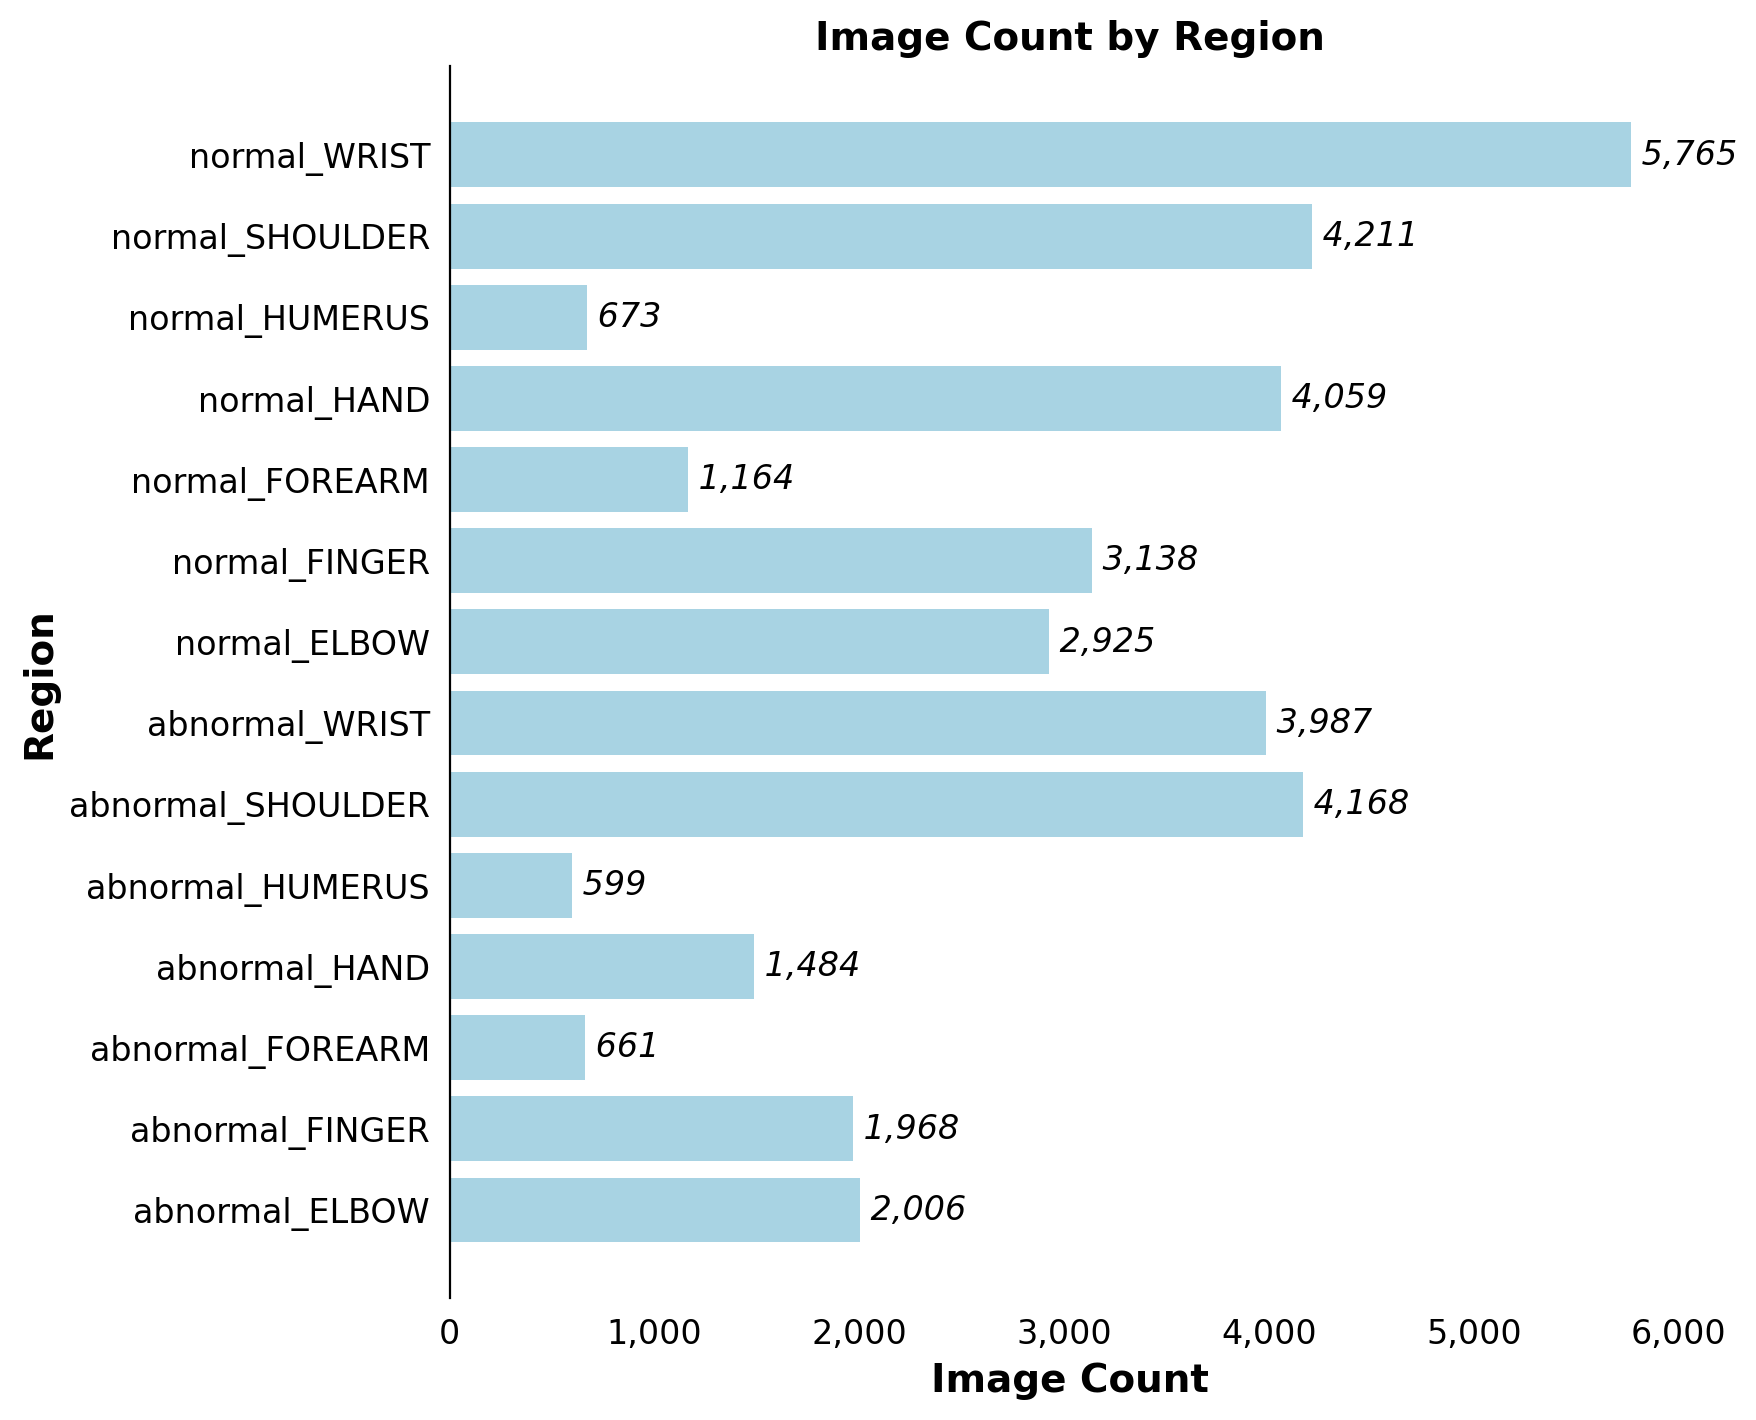

In [131]:
# get count of regions of train images with 14 targets
region_count_14(train_df_14)

Region  Count
0      abnormal_ELBOW    230
1     abnormal_FINGER    247
2    abnormal_FOREARM    151
3       abnormal_HAND    189
4    abnormal_HUMERUS    140
5   abnormal_SHOULDER    278
6      abnormal_WRIST    295
7        normal_ELBOW    235
8       normal_FINGER    214
9      normal_FOREARM    150
10        normal_HAND    271
11     normal_HUMERUS    148
12    normal_SHOULDER    285
13       normal_WRIST    364

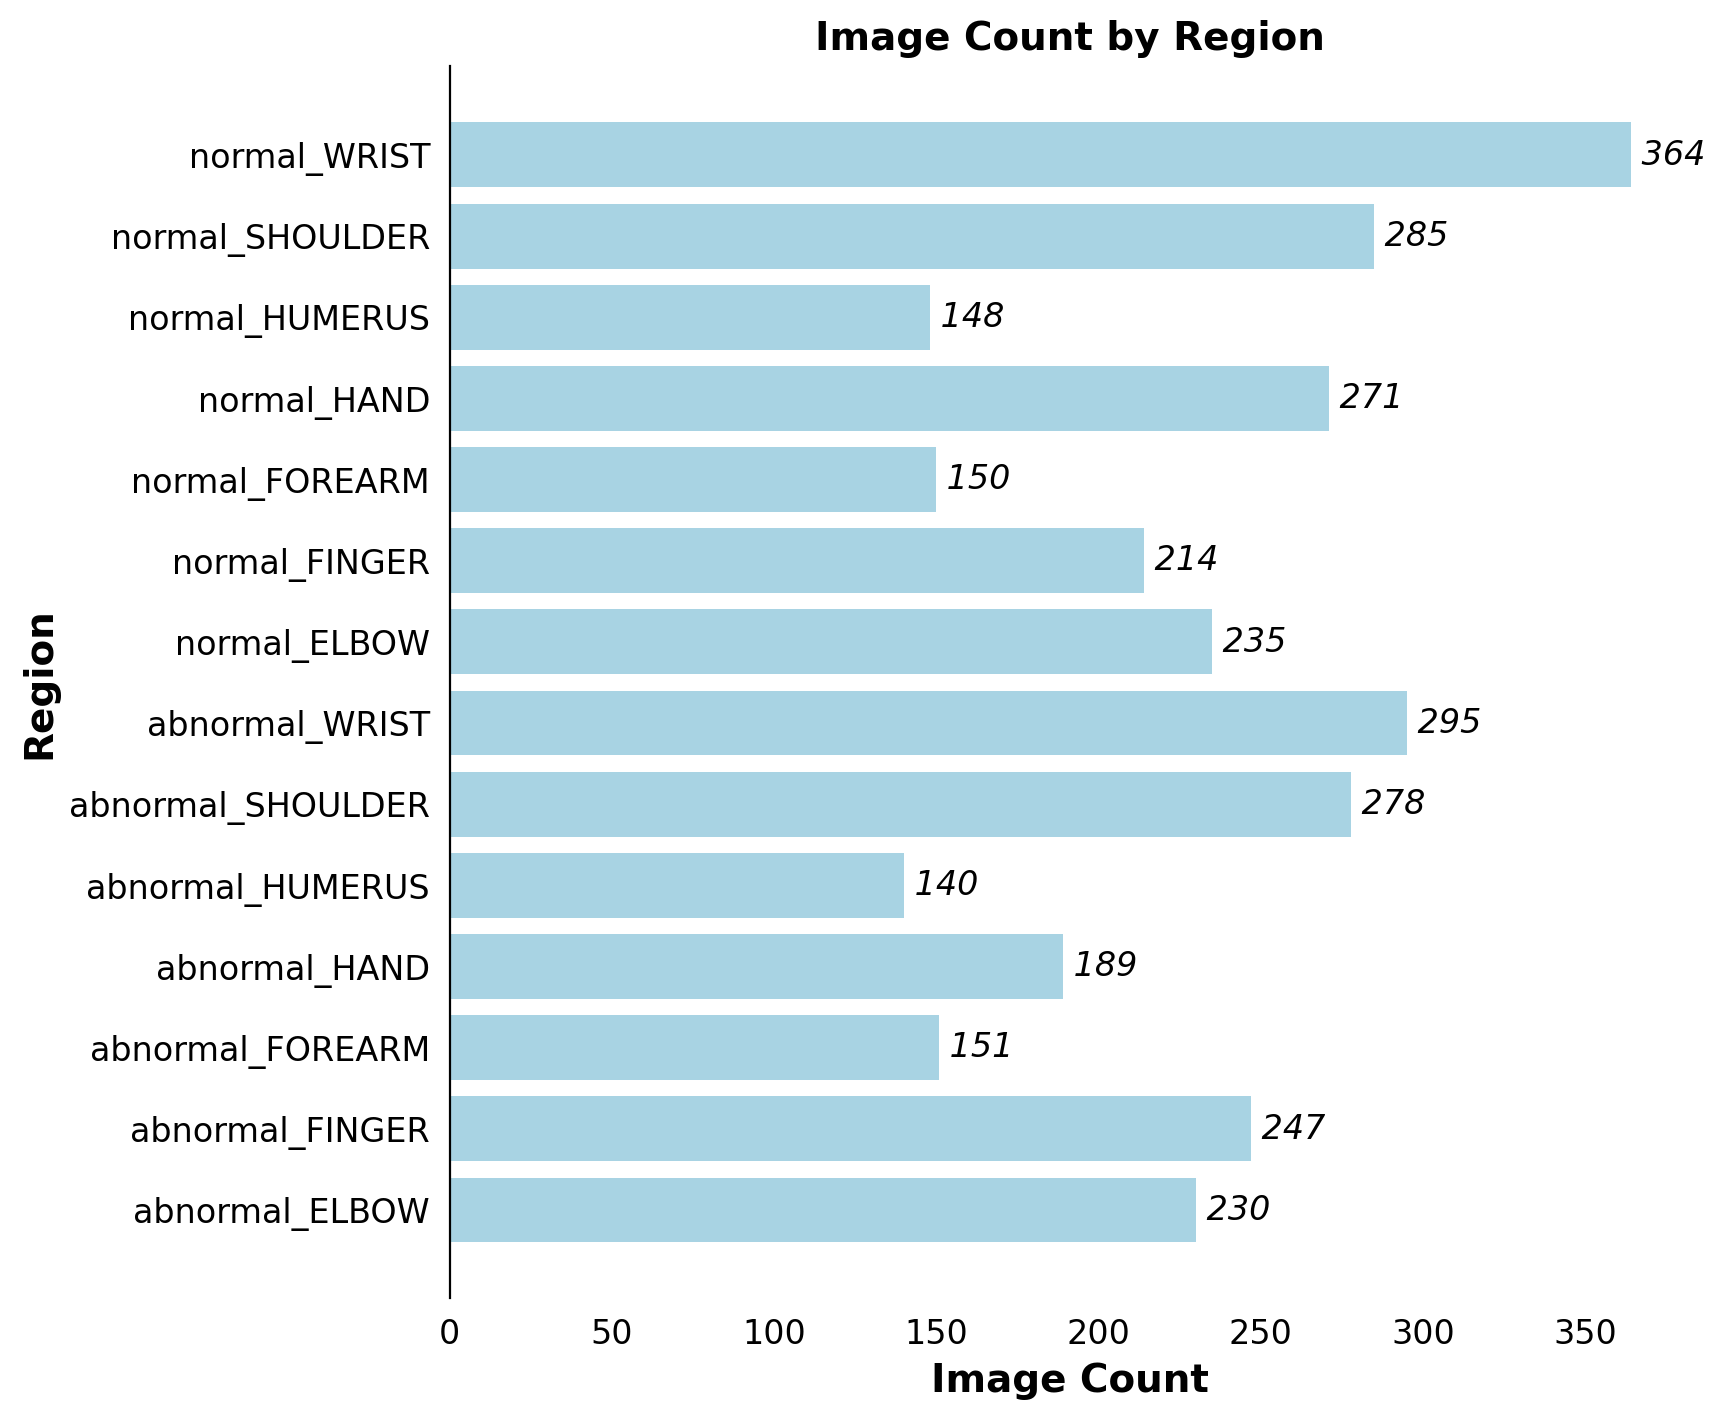

In [129]:
# get count of regions of test images with 14 targets
region_count_14(test_df_14)

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal     2006       normal     2925     4931
1    FINGER     abnormal     1968       normal     3138     5106
2   FOREARM     abnormal      661       normal     1164     1825
3      HAND     abnormal     1484       normal     4059     5543
4   HUMERUS     abnormal      599       normal      673     1272
5  SHOULDER     abnormal     4168       normal     4211     8379
6     WRIST     abnormal     3987       normal     5765     9752

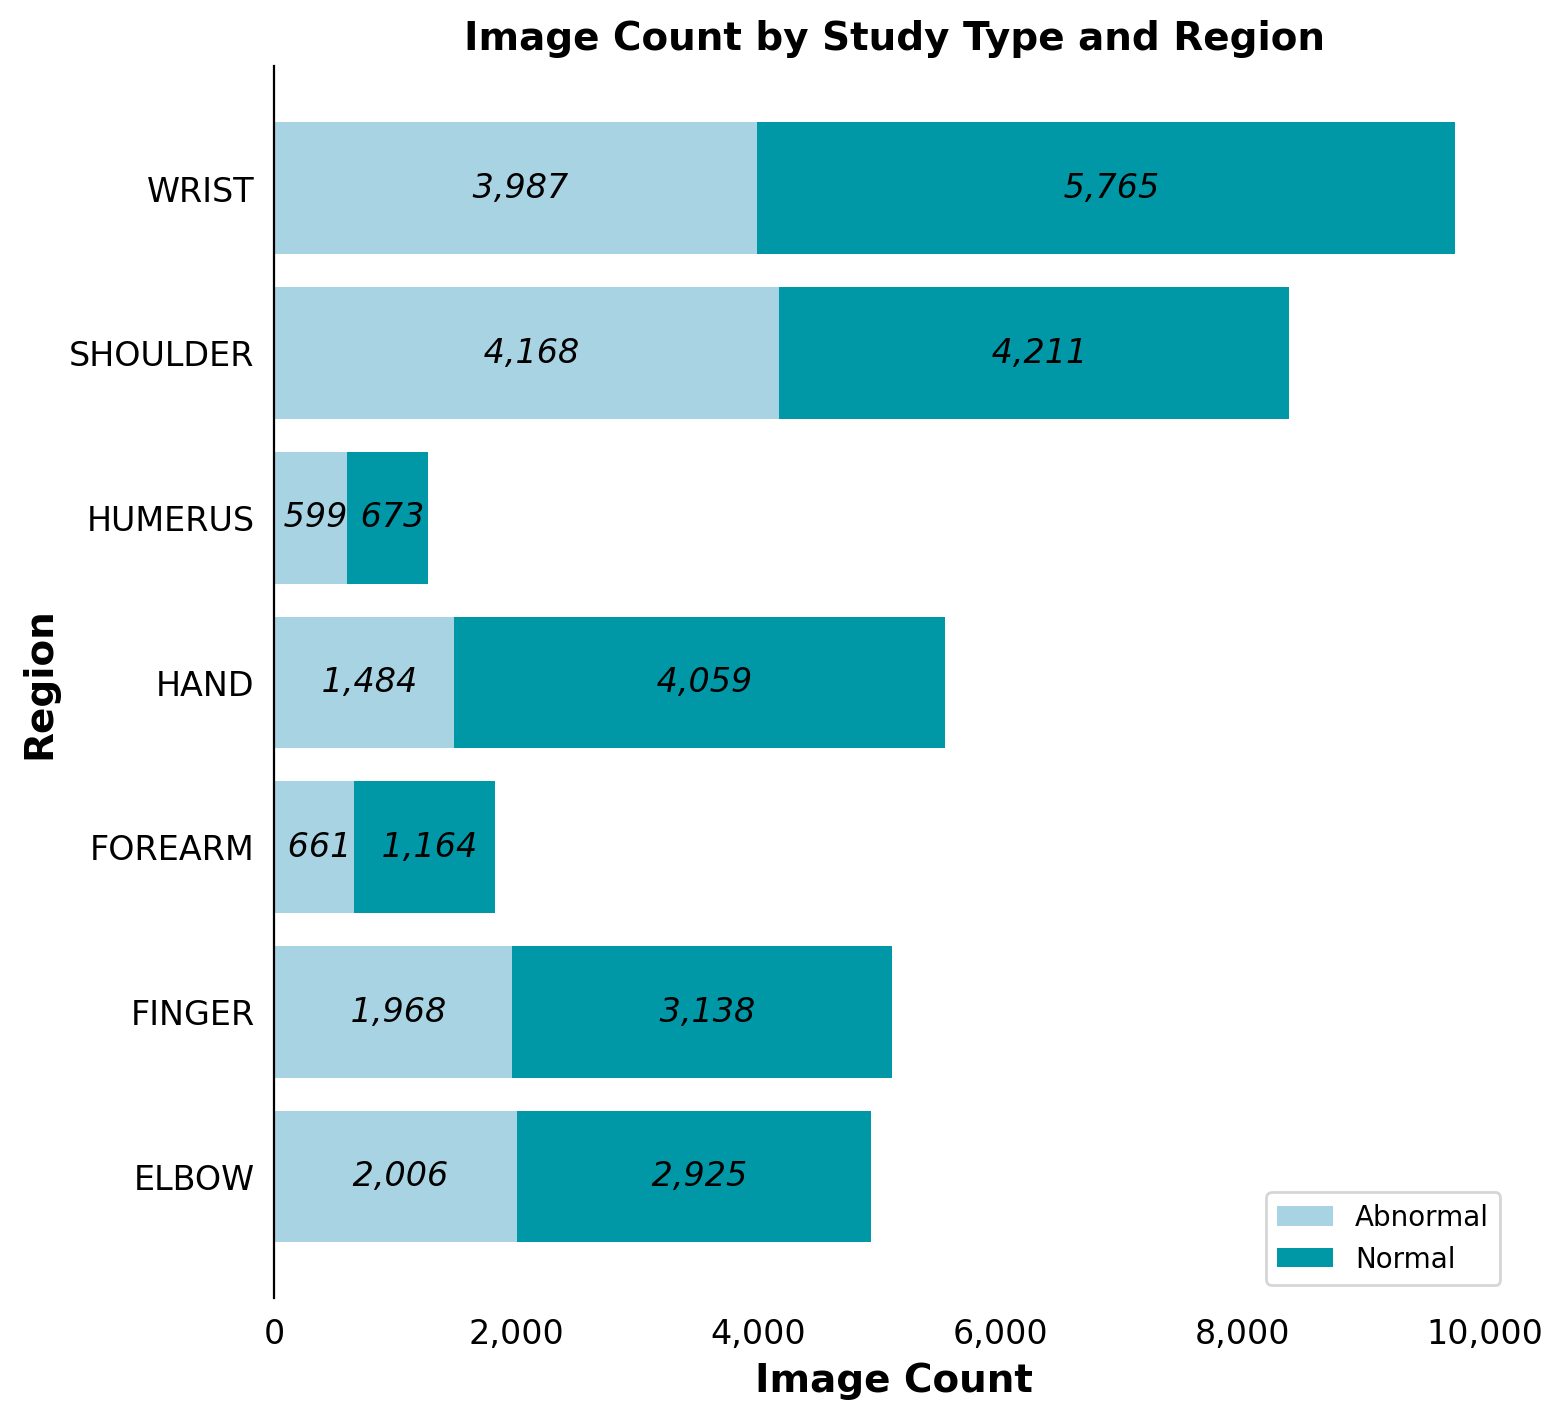

In [175]:
# region types of train data with 14 targets
type_region_14(train_df_14)

Region Study Type_x  Count_x Study Type_y  Count_y  Count_z
0     ELBOW     abnormal      230       normal      235      465
1    FINGER     abnormal      247       normal      214      461
2   FOREARM     abnormal      151       normal      150      301
3      HAND     abnormal      189       normal      271      460
4   HUMERUS     abnormal      140       normal      148      288
5  SHOULDER     abnormal      278       normal      285      563
6     WRIST     abnormal      295       normal      364      659

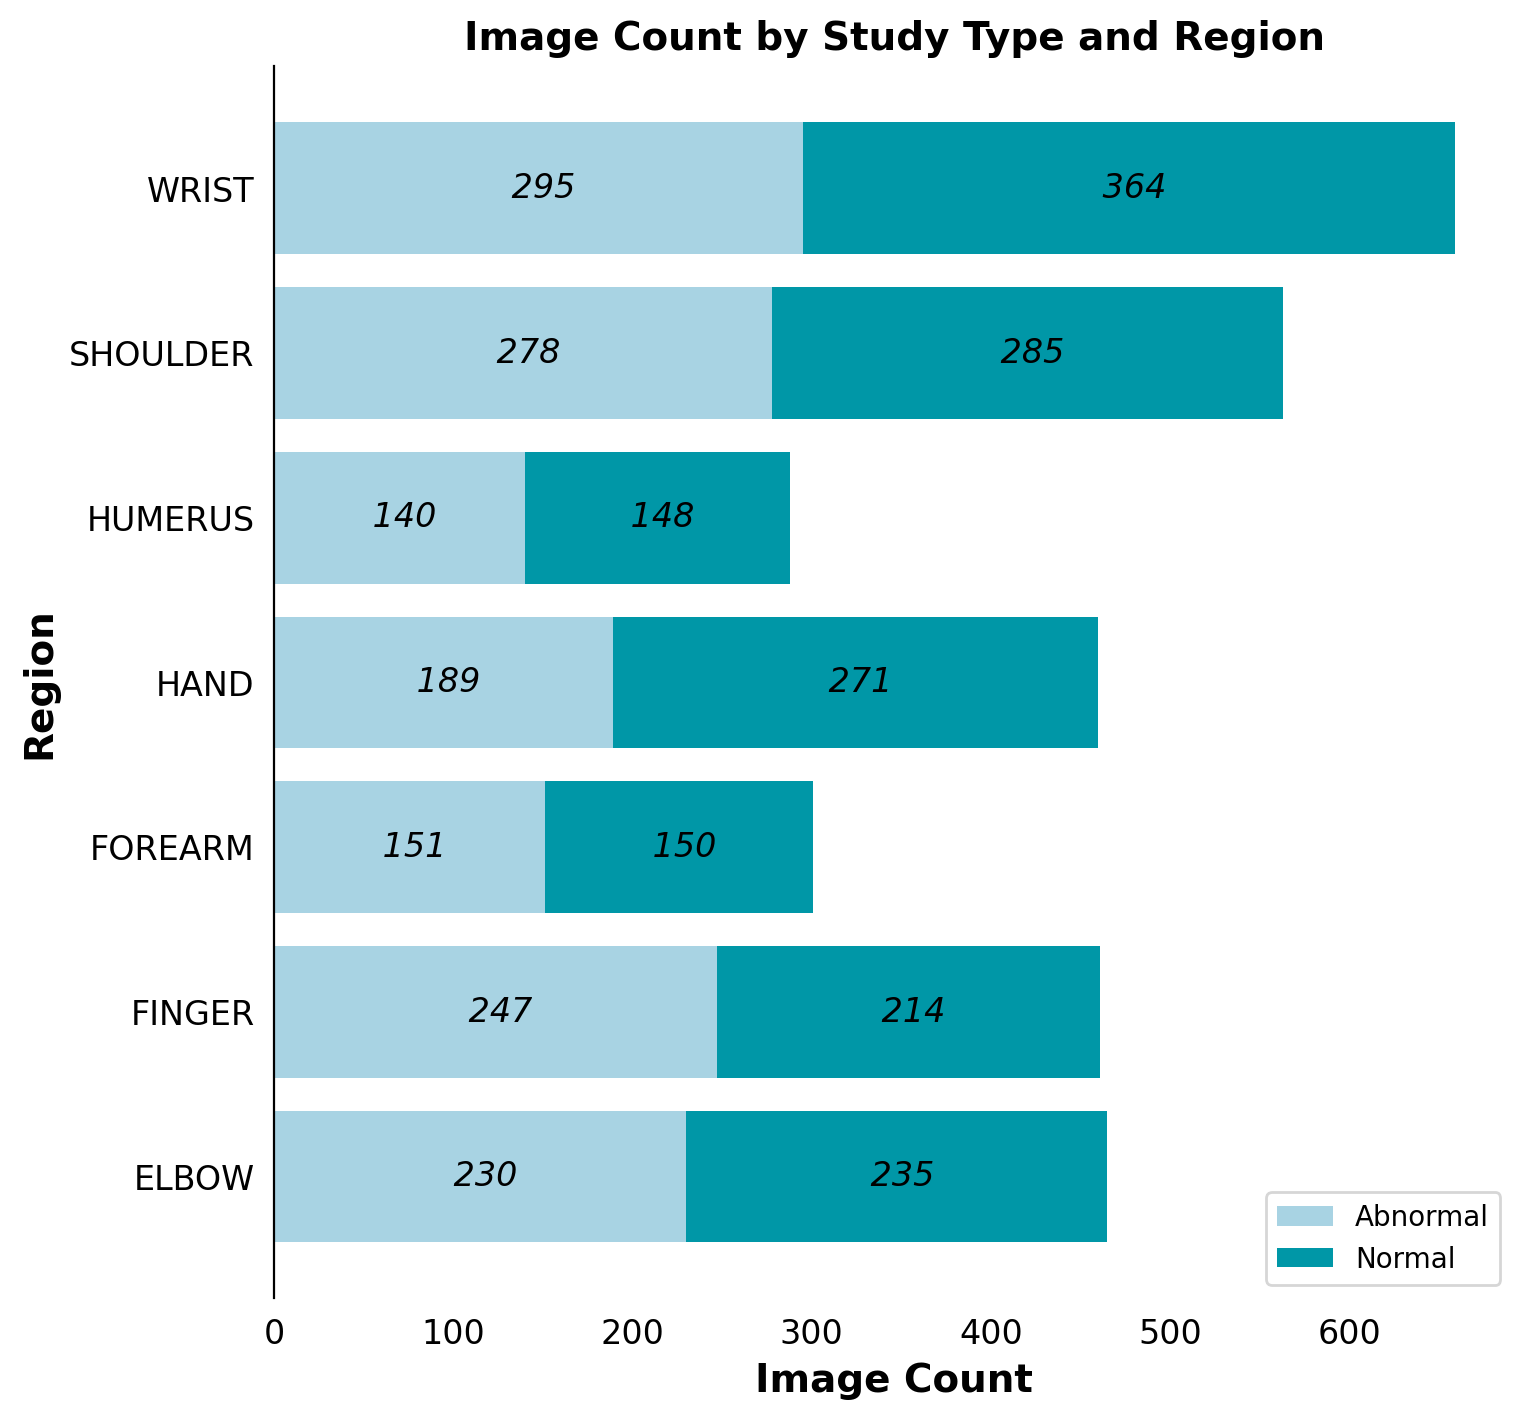

In [176]:
# region types of test data with 14 targets
type_region_14(test_df_14)

In [156]:
# create dataset objects of our data
train_dataset = MuraDataset(train_df)
test_dataset = MuraDataset(test_df)

In [157]:
# create dataloader to check size of images
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [159]:
# look through images and collect data on image shapes
img_sizes = {}
for i in range(500):
    img, label = next(iter(train_loader))
    shape = img.shape
    img_sizes[shape] = img_sizes.get(shape, 0) + 1

In [160]:
# lets look at our image size samples we collected
img_sizes

{torch.Size([1, 3, 512, 420]): 17,
 torch.Size([1, 1, 512, 328]): 1,
 torch.Size([1, 1, 512, 440]): 1,
 torch.Size([1, 3, 512, 425]): 1,
 torch.Size([1, 1, 512, 292]): 2,
 torch.Size([1, 1, 512, 277]): 1,
 torch.Size([1, 1, 512, 512]): 15,
 torch.Size([1, 1, 512, 238]): 2,
 torch.Size([1, 3, 512, 379]): 28,
 torch.Size([1, 1, 512, 486]): 2,
 torch.Size([1, 1, 512, 413]): 1,
 torch.Size([1, 3, 512, 406]): 74,
 torch.Size([1, 1, 362, 512]): 1,
 torch.Size([1, 1, 512, 388]): 2,
 torch.Size([1, 1, 407, 512]): 5,
 torch.Size([1, 1, 512, 265]): 3,
 torch.Size([1, 1, 512, 205]): 1,
 torch.Size([1, 1, 512, 349]): 2,
 torch.Size([1, 1, 512, 164]): 2,
 torch.Size([1, 1, 512, 320]): 2,
 torch.Size([1, 1, 512, 165]): 3,
 torch.Size([1, 1, 512, 411]): 2,
 torch.Size([1, 1, 414, 512]): 2,
 torch.Size([1, 1, 512, 355]): 2,
 torch.Size([1, 1, 429, 512]): 1,
 torch.Size([1, 3, 512, 407]): 13,
 torch.Size([1, 1, 512, 492]): 2,
 torch.Size([1, 3, 405, 512]): 2,
 torch.Size([1, 1, 512, 404]): 4,
 torch.Si

There are many different image sizes and while most have 1 channel, there are some with 3 channels.